# Experimentación - AGCRN

https://arxiv.org/abs/2007.02842


## 1. Obtención de datos



In [40]:
import torch
import torch.nn.functional as F
import pandas as pd
import seaborn as sns
import networkx as nx
sns.set_palette("coolwarm_r")

import matplotlib.pyplot as plt
import numpy as np


import os, sys

path = os.getcwd()

sys.path.insert(1, "/".join(path.split("/")[0:-1]))

from utils import powergrid

In [41]:
#folder_path = "/home/TFM/code_dataset2/datos/Natural Oscillation"
folder_path = "/Users/maguado/Documents/UGR/Master/TFM/datos_2/Natural Oscillation"
name_model = "AGCRN"
results_save_path = "./results"


In [42]:
loader = powergrid.PowerGridDatasetLoader(folder_path, problem="regression")
_,_,_ =loader.process()
limit = 300
#dataset_full = loader.get_dataset( target= 20, intro=300, step=20, limit=limit, one_ts_per_situation=False)

Processing dataset...
Processing:  row_307
Node:  0  not included, including...
Node:  1  not included, including...
Node:  2  not included, including...
Node:  3  not included, including...
Node:  4  not included, including...
Node:  5  not included, including...
Node:  6  not included, including...
Node:  7  not included, including...
Node:  8  not included, including...
Node:  9  not included, including...
Node:  10  not included, including...
Node:  11  not included, including...
Node:  12  not included, including...
Node:  13  not included, including...
Node:  14  not included, including...
Node:  15  not included, including...
Node:  16  not included, including...
Node:  17  not included, including...
Node:  18  not included, including...
Node:  19  not included, including...
Node:  20  not included, including...
Node:  21  not included, including...
Node:  22  not included, including...
Processing:  row_135
Processing:  row_75
Processing:  row_338
Processing:  row_81
Processing:

## Funciones auxiliares - entrenamiento

In [43]:
from utils import pygt_loader

try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterable):
        return iterable
import os
import torch
import torch.nn.functional as F
from sklearn.metrics import r2_score

from torch.optim.lr_scheduler import ReduceLROnPlateau
from utils.utils_graph import format_plot

from utils.utils_graph import reconstruir_predictions, plot_training_and_eval_losses, plot_predictions

from utils.trainer import TrainerModel, TrainerAGCRN
from utils.models import AGCRNModel
dtype = torch.float
device = torch.device("mps")

In [44]:
import itertools


def entrenar_y_evaluar_modelos(param_grid, dataset, dataloader_params, num_early_stop, num_epochs, problem=""):
    """
    Entrena y evalúa modelos con diferentes combinaciones de hiperparámetros, y devuelve el mejor modelo,
    los mejores parámetros y un DataFrame con los resultados.

    Args:
        param_grid (dict): Diccionario con listas de valores de los hiperparámetros a probar.
        n_features (int): Número de características del nodo.
        n_nodes (int): Número de nodos.
        n_target (int): Número de objetivos.
        dataloader (object): Objeto que proporciona los datos para entrenamiento y evaluación.
        num_early_stop (int): Número de épocas para detenerse tempranamente si no hay mejora.
        num_epochs (int): Número de épocas para entrenar.
        lr (float): Tasa de aprendizaje.

    Returns:
        mejor_modelo (object): El mejor modelo entrenado.
        mejores_parametros (tuple): Los mejores parámetros (aggr, conv, lstm).
        resultados_gt (pd.DataFrame): DataFrame con los resultados de todas las combinaciones de hiperparámetros.
    """
    resultados_list = []

    #Vamos a guardar el mejor modelo
    mejor_loss_test = float('inf')
    mejor_trainer = None
    mejores_parametros = None
    mejores_resultados = None

    n_nodes =dataset.features[0].shape[0]
    n_target = dataset.targets[0].shape[1]
    n_features = dataset[0].x.shape[1]


    device =torch.device("mps" if torch.backends.mps.is_available() else "cpu")

    for embedding, hidden, k in tqdm(list(itertools.product(param_grid["embedding"], param_grid["hidden_size"], param_grid["k"]))):
        

        model = AGCRNModel(n_features=n_features, n_nodes=n_nodes, embedding_dim=embedding, hidden_size=hidden,k=k, n_target=n_target, name="AGCRN")

        model.to(device)
        trainer = TrainerAGCRN(model, dataset,device, f"./results/{problem}", dataloader_params)


        losses,eval_losses, r2scores  = trainer.train(num_epochs=num_epochs, steps=50, num_early_stop=num_early_stop)
        r2score_tst,losses_tst, loss_nodes, _, _ = trainer.test()

        results_intermedio = {
            "Embedding": embedding,
            "k": k,
            "Hidden": hidden,
            "Loss_final": losses[-1],
            "R2_eval": np.mean(r2scores[-1]),
            "Loss_eval": np.mean(eval_losses[-1]),
            "R2_tst": np.mean(r2score_tst),
            "Loss_tst": np.mean(losses_tst),
            "Loss_nodes": np.mean(loss_nodes, axis=0).tolist()
        }
        # Añade los resultados a la lista
        resultados_list.append(results_intermedio)

        if np.mean(losses_tst) < mejor_loss_test:
            mejor_loss_test = np.mean(losses_tst)
            mejor_trainer = trainer
            mejores_parametros = {'hidden': hidden, 'K': k, 'embedding': embedding}
            mejores_resultados = results_intermedio

        print("Parámetros: ", hidden, k, embedding)
        print("Resultados: ", resultados_list[-1])

    resultados = pd.DataFrame(resultados_list)

    return mejor_trainer, mejores_parametros, mejores_resultados, resultados


## Prueba - predicción por tipos

In [45]:
dataloader_params2 = {
            "batch_size": 5,
            "data_split_ratio": [0.7, 0.15, 0.15],
            "seed": 42,
            "keep_same": True,
            "use_batch":True
}

param_grid = {
    "hidden_size": [10,20,50, 100],
    "embedding": [3,5, 10, 15], 
    "k": [2, 3, 4]
}
num_early_stop = 0
num_epochs = 30
lr = 0.01

### Gen trip

In [46]:
problem_gt = "gen_trip"
dataset_gt, situations_gt = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem_gt)



Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  184


In [47]:

n_div_gt = loader.div
n_nodes =dataset_gt.features[0].shape[0]
n_target = dataset_gt.targets[0].shape[1]
n_features = dataset_gt[0].x.shape[1]
embedding_dim =5

#### Sencilla 

In [26]:
model_gt = AGCRNModel(n_features=n_features, n_nodes=n_nodes, embedding_dim=embedding_dim, n_target=n_target, name="RecurrentGCNInicial")
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

model_gt.to(device)
trainer_gt = TrainerAGCRN(model_gt, dataset_gt,device, f"./results/{problem_gt}", dataloader_params2)

losses,eval_losses, r2scores  = trainer_gt.train(num_epochs=num_epochs, steps=200, num_early_stop=num_early_stop)




==================== DATASET INFO ===================

Train dataset: 4350
Validation dataset: 930
Test dataset: 942

==================== DATALOADER INFO ===================

DataLoader for train set:
Number of batches: 870
DataLoader for val set:
Number of batches: 186
DataLoader for test set:
Number of batches: 188

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.0860 | Eval Loss: 0.0400 | Eval R2: -5.6928 | 
Epoch 2/30 | Train Loss: 0.0189 | Eval Loss: 0.0228 | Eval R2: -2.0131 | 
Epoch 3/30 | Train Loss: 0.0152 | Eval Loss: 0.0203 | Eval R2: -1.5779 | 
Epoch 4/30 | Train Loss: 0.0138 | Eval Loss: 0.0186 | Eval R2: -1.2508 | 
Epoch 5/30 | Train Loss: 0.0130 | Eval Loss: 0.0177 | Eval R2: -1.1164 | 
Epoch 6/30 | Train Loss: 0.0124 | Eval Loss: 0.0164 | Eval R2: -0.8566 | 
Epoch 7/30 | Train Loss: 0.0121 | Eval Loss: 0.0166 | Eval R2: -0.9129 | 
Epoch 8/30 | Train Loss: 0.0119 | Eval Loss: 0.0156 | Eval R2: -0.6918 | 
Epoch 9/30 | Train Loss: 0.0116 |

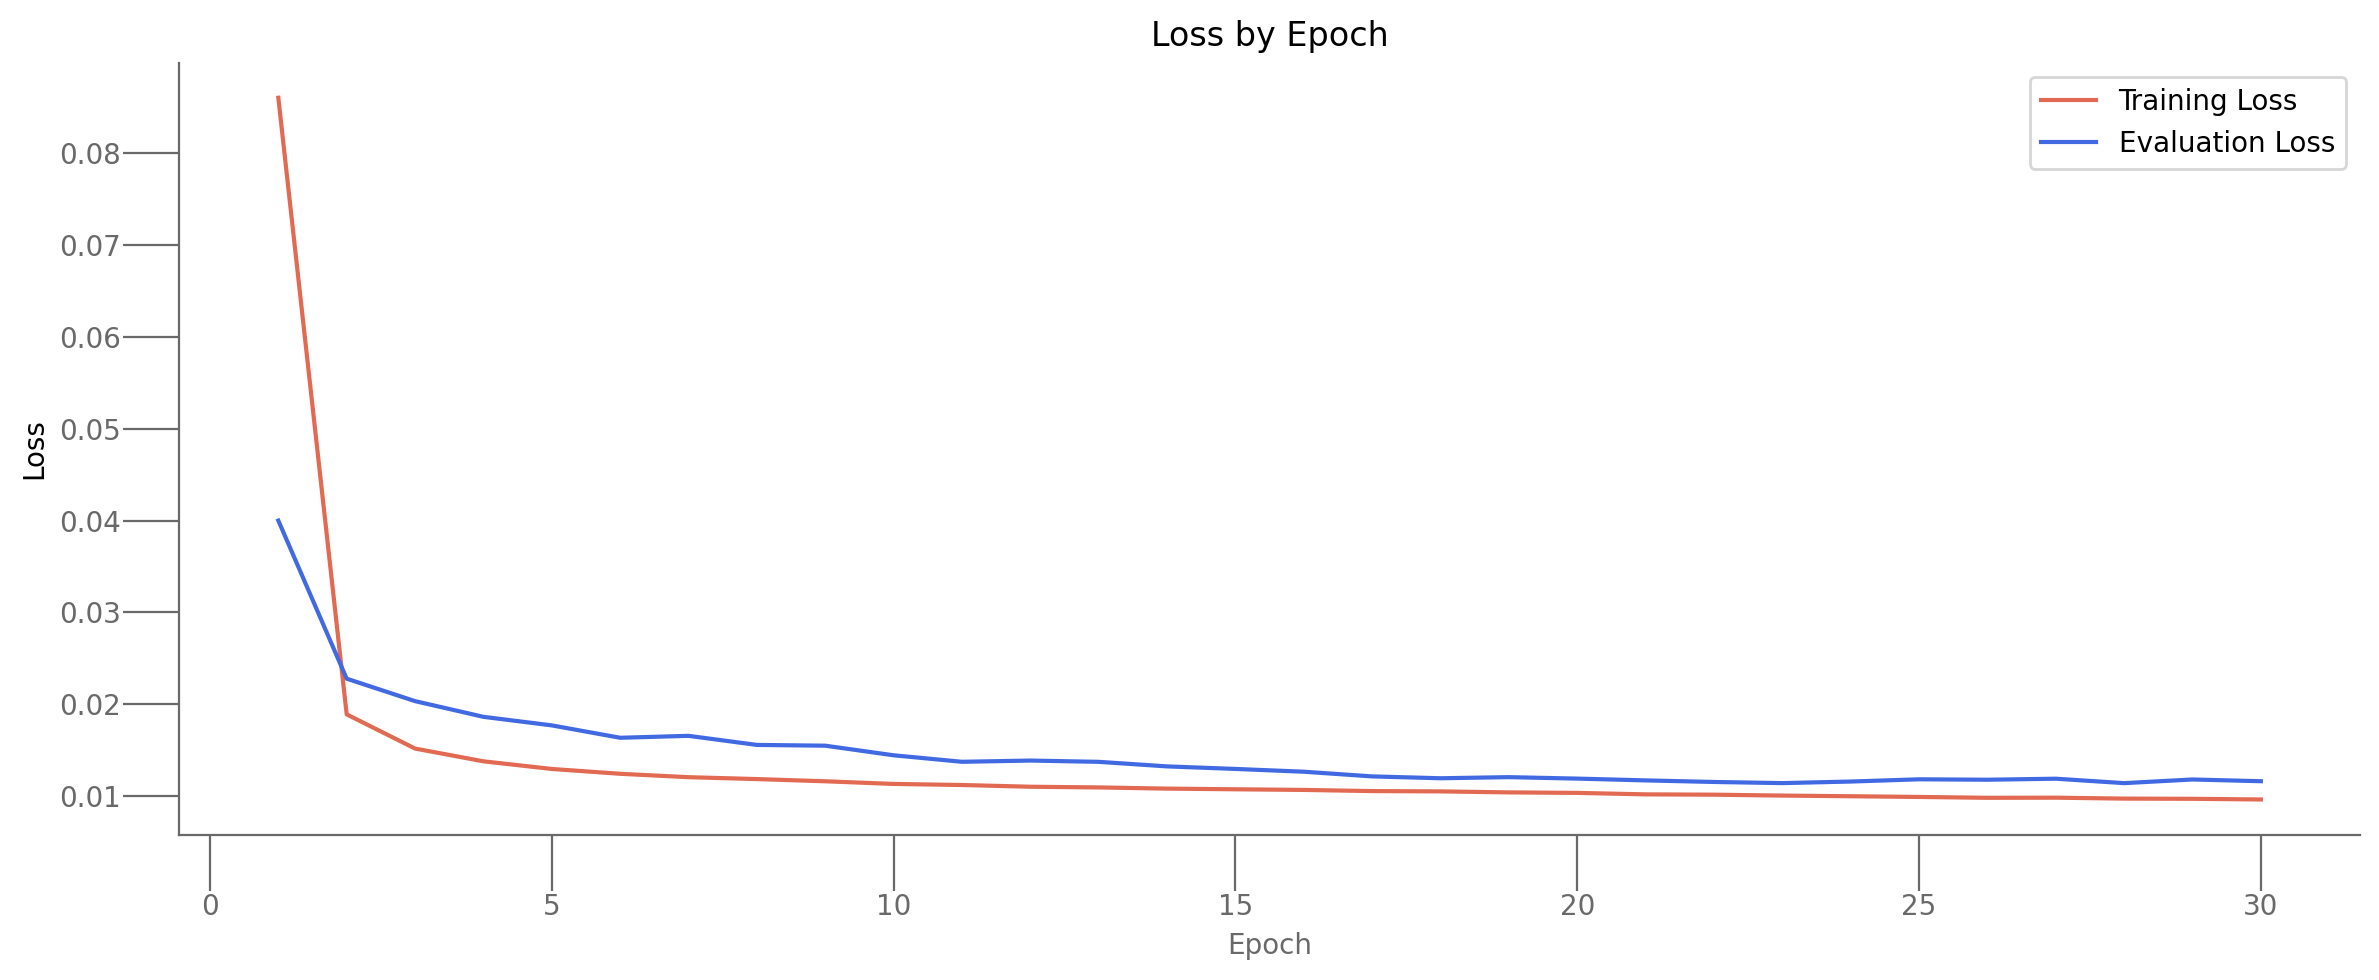


==================== TEST INFO ===================

preds:  (5, 23, 20)
test loss: 0.009161, test r2score 0.034857


In [27]:
plot_training_and_eval_losses(np.array(losses), np.array(eval_losses), num_epochs, format_plot)
losses_tst, r2score_tst, loss_nodes, predictions_gt, real_gt = trainer_gt.test()



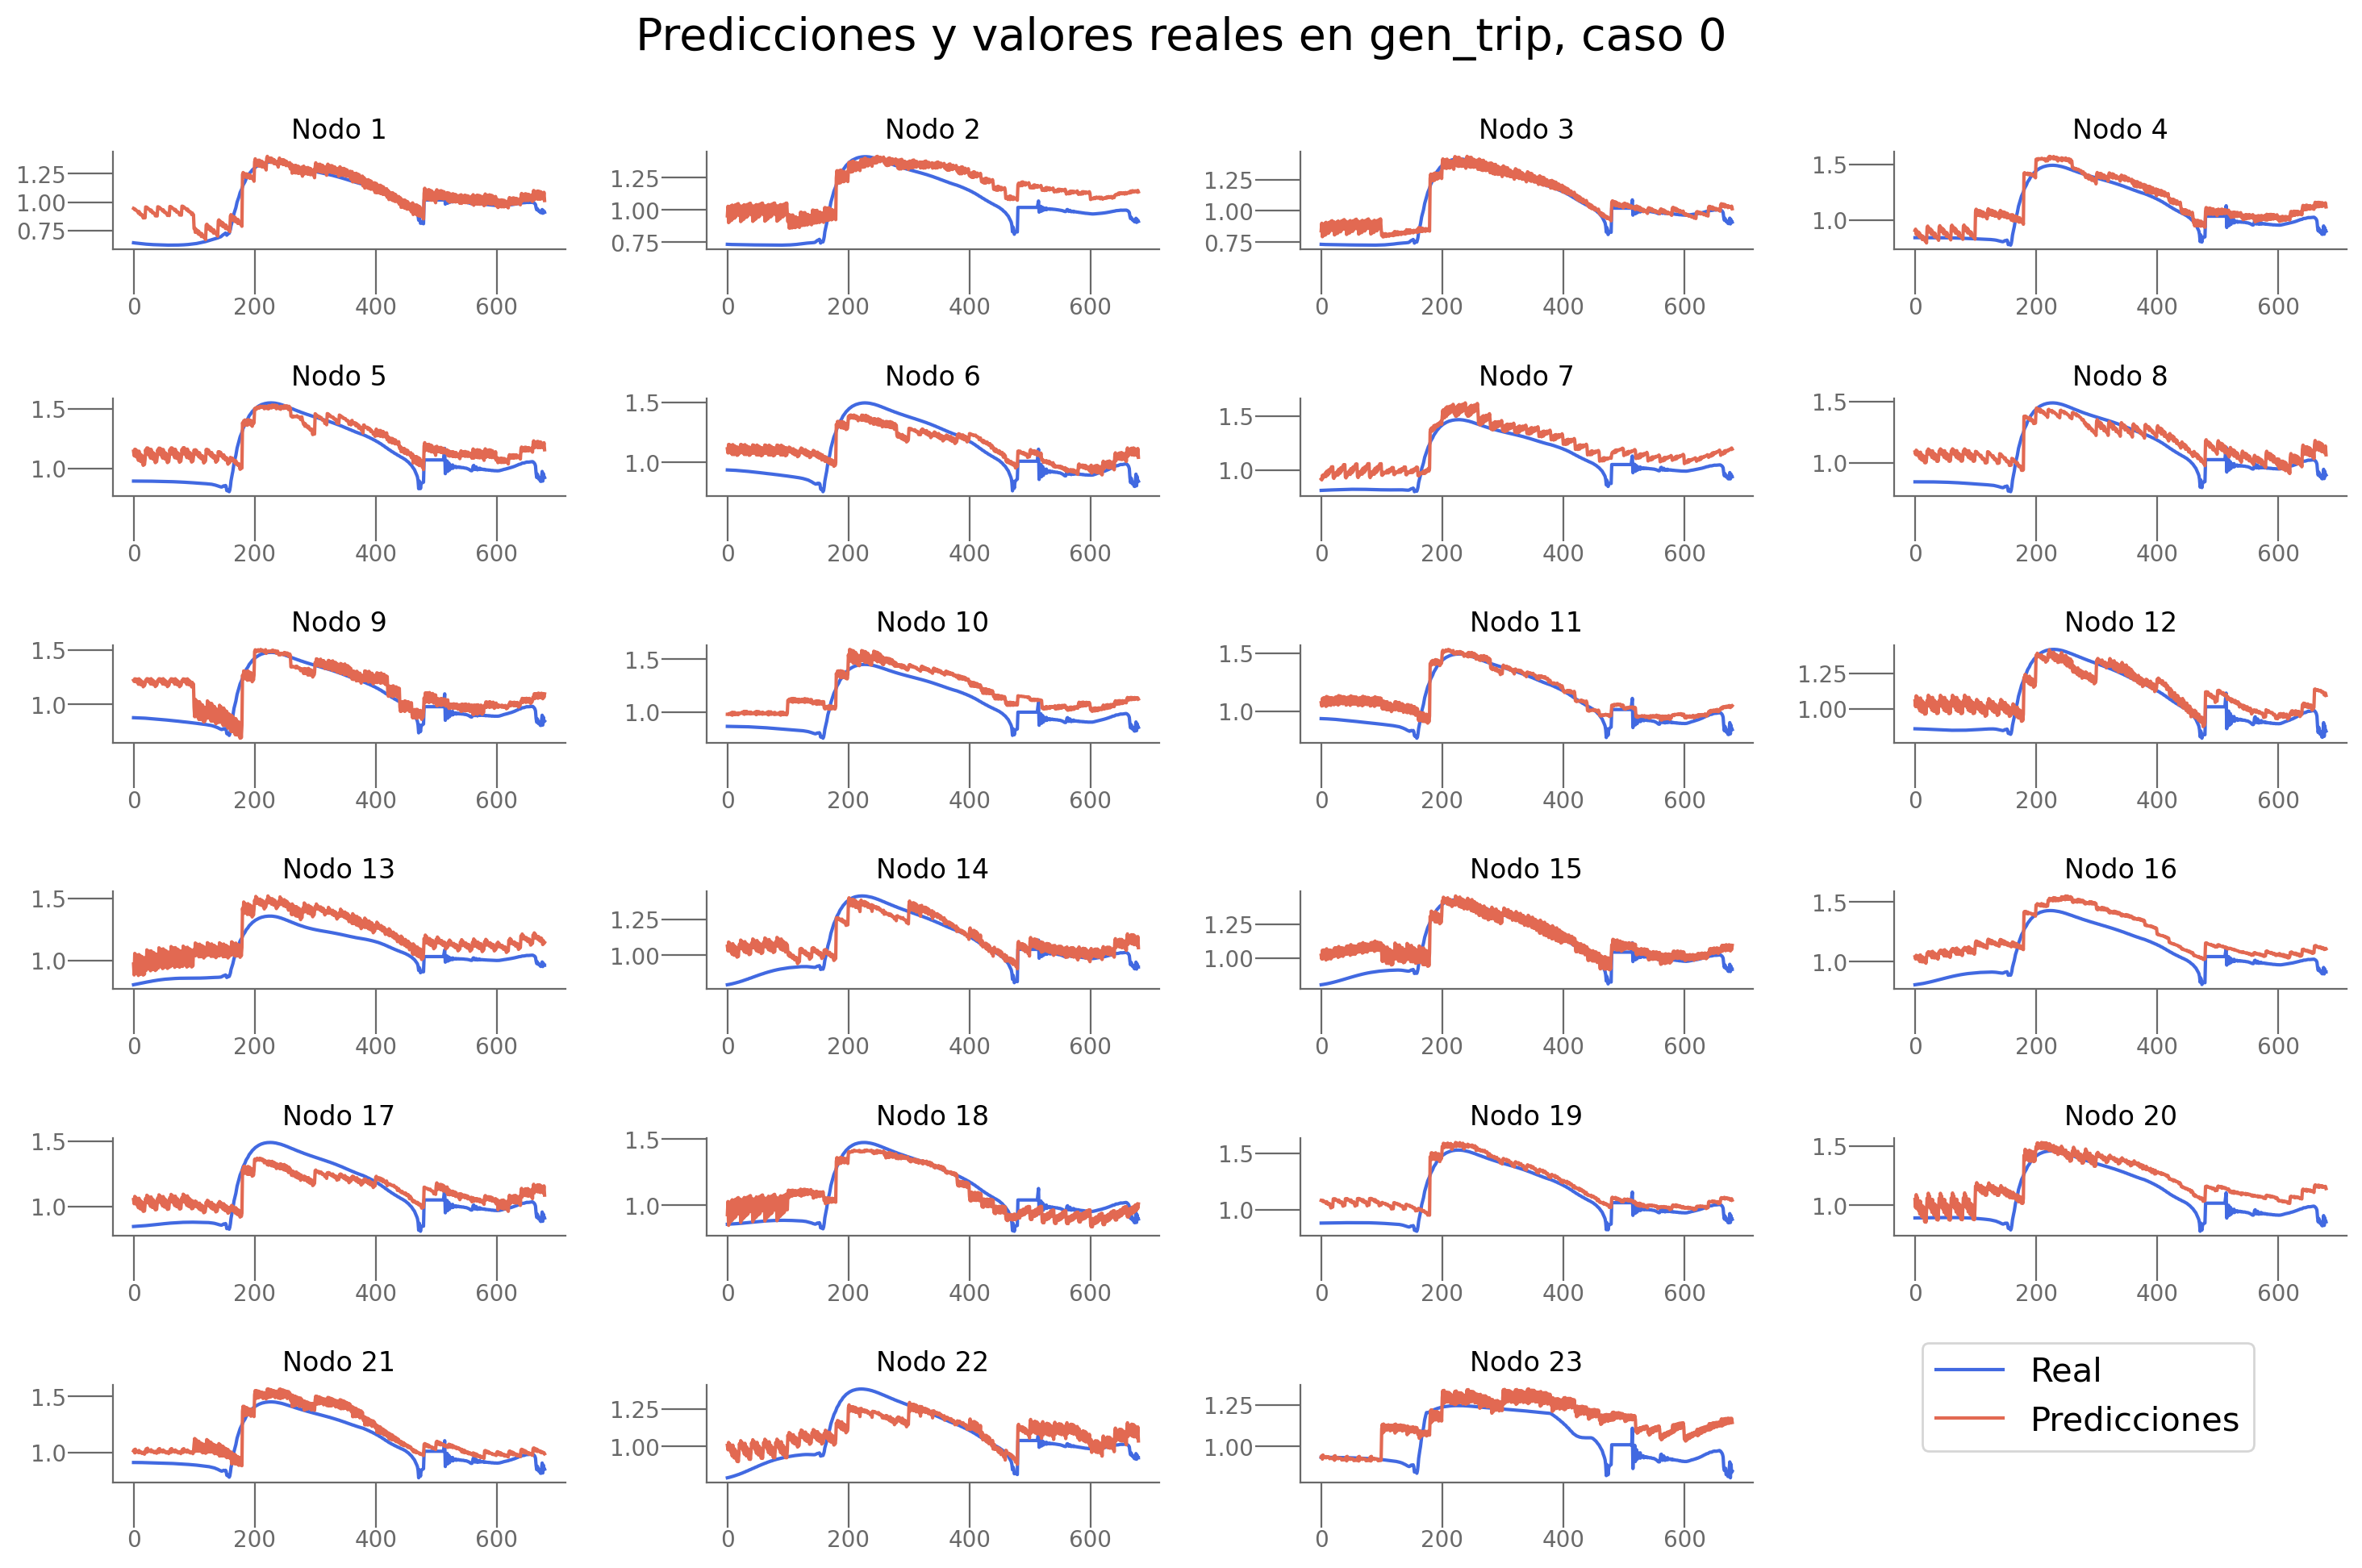

In [32]:
plot_predictions(predictions_gt, real_gt, n_target, 0, n_div_gt, problem_gt)

#### Ajuste de parámetros

In [48]:
from importlib import reload
import utils.trainer
utils.trainer = reload(utils.trainer)
from utils.trainer import TrainerAGCRN

In [49]:


trainer_gt,params_gt, resultados_final_gt, resultados_gt = entrenar_y_evaluar_modelos(param_grid, dataset_gt, dataloader_params2, num_early_stop=num_early_stop, num_epochs=num_epochs, problem=problem_gt)

  0%|          | 0/48 [00:00<?, ?it/s]


==================== DATASET INFO ===================

Train dataset: 4352
Validation dataset: 918
Test dataset: 952

==================== DATALOADER INFO ===================

DataLoader for train set:
Number of batches: 870
DataLoader for val set:
Number of batches: 183
DataLoader for test set:
Number of batches: 190

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.1713 | Eval Loss: 0.0446 | Eval R2: -5.0501 | LR: 0.0010 | 
Epoch 2/30 | Train Loss: 0.0283 | Eval Loss: 0.0231 | Eval R2: -1.9527 | LR: 0.0010 | 
Epoch 3/30 | Train Loss: 0.0194 | Eval Loss: 0.0173 | Eval R2: -0.7496 | LR: 0.0010 | 
Epoch 4/30 | Train Loss: 0.0162 | Eval Loss: 0.0154 | Eval R2: -0.3890 | LR: 0.0010 | 
Epoch 5/30 | Train Loss: 0.0145 | Eval Loss: 0.0143 | Eval R2: -0.1775 | LR: 0.0010 | 
Epoch 6/30 | Train Loss: 0.0135 | Eval Loss: 0.0140 | Eval R2: -0.1347 | LR: 0.0010 | 
Epoch 7/30 | Train Loss: 0.0130 | Eval Loss: 0.0136 | Eval R2: -0.0402 | LR: 0.0010 | 
Epoch 8/30 | Tra

In [16]:
path_save_experiment_gt = results_save_path+f"/{problem_gt}"+ f"/ajustes/{name_model}_results.csv"
resultados_gt.to_csv(path_save_experiment_gt, index=False)


==================== TEST INFO ===================

preds:  (5, 23, 20)
test loss: 0.008577, test R2 score: -0.137767


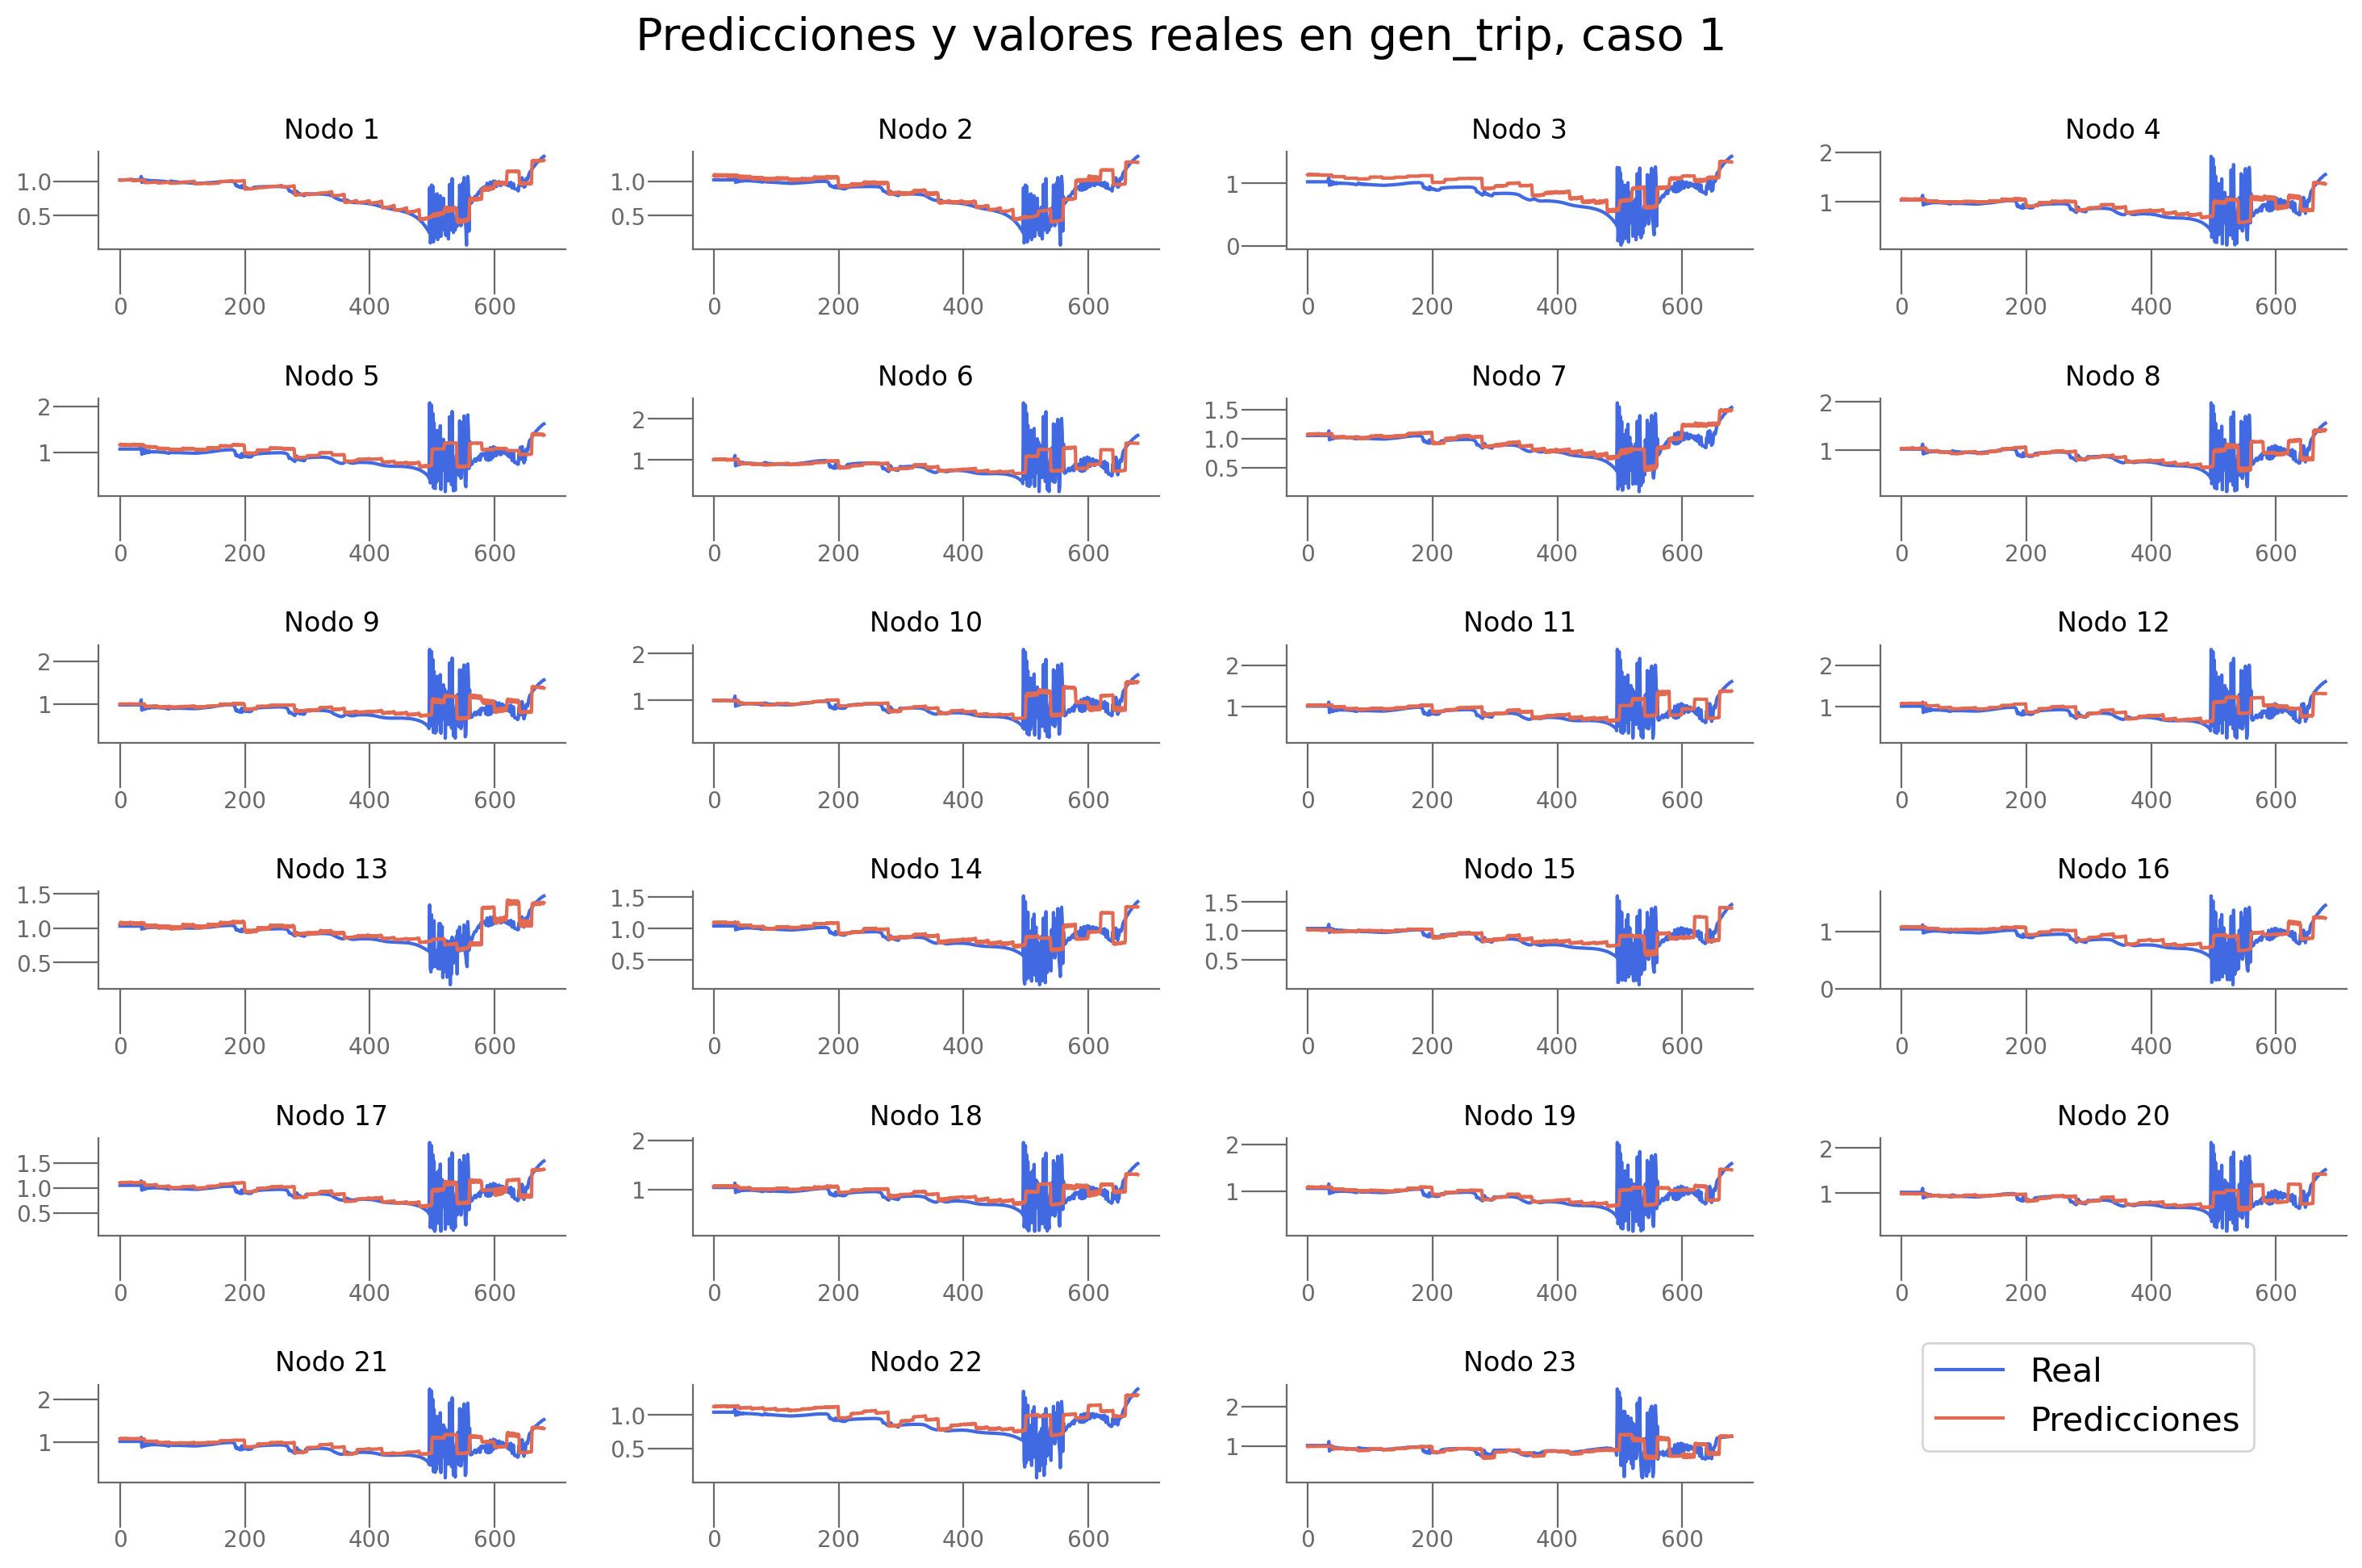

In [17]:
_,_,_, predictions_gt_ajuste,real_gt_ajuste = trainer_gt.test()
plot_predictions(predictions_gt_ajuste, real_gt_ajuste, n_target, 1, n_div_gt, problem_gt)

In [18]:
trainer_gt.save_model(path_save_experiment=path_save_experiment_gt, params = params_gt)


==================== GUARDANDO RESULTADOS ===================

          Modelo                                             Params  \
0           LSTM                                                NaN   
1      MPNN_LSTM                {'hidden_size': 16, 'dropout': 0.2}   
2   LSTM_NOBATCH                                                NaN   
3    DyGrEncoder              {'aggr': 'add', 'conv': 1, 'lstm': 1}   
4      EvolveGCN                                                NaN   
5         MSTGCN  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_...   
6          DCRNN                                     {'hidden': 10}   
7         ASTGCN  {'nb_block': 1, 'K': 2, 'nb_chev_filter': 3, '...   
8         MSTGCN  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_...   
9          MTGNN  {'gcn_depth': 2, 'conv_channels': 16, 'kernel_...   
10         AGCRN             {'hidden': 10, 'K': 2, 'embedding': 3}   

                       Fichero_resultados_experimento  Loss_tst     R2_tst  \
0    

### Bus trip

In [19]:
problem_bt = "bus_trip"
dataset_bt, situations_bt = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem_bt)




Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  86


In [20]:

n_div_bt = loader.div
n_nodes =dataset_bt.features[0].shape[0]
n_target = dataset_bt.targets[0].shape[1]
n_features = dataset_bt[0].x.shape[1]
embedding_dim =5

#### Sencilla 

In [56]:
model_bt = AGCRNModel(n_features=n_features, n_nodes=n_nodes, embedding_dim=embedding_dim, n_target=n_target, name="AGCRN")
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

model_bt.to(device)
trainer_bt = TrainerAGCRN(model_bt, dataset_bt,device, f"./results/{problem_bt}", dataloader_params2)

losses,eval_losses, r2scores  = trainer_bt.train(num_epochs=num_epochs, steps=200, num_early_stop=num_early_stop)




==================== DATASET INFO ===================

Train dataset: 2025
Validation dataset: 435
Test dataset: 430

==================== DATALOADER INFO ===================

DataLoader for train set:
Number of batches: 405
DataLoader for val set:
Number of batches: 87
DataLoader for test set:
Number of batches: 86

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.1393 | Eval Loss: 0.0412 | Eval R2: 0.2645 | 
Epoch 2/30 | Train Loss: 0.0239 | Eval Loss: 0.0210 | Eval R2: 0.5995 | 
Epoch 3/30 | Train Loss: 0.0163 | Eval Loss: 0.0157 | Eval R2: 0.6998 | 
Epoch 4/30 | Train Loss: 0.0134 | Eval Loss: 0.0138 | Eval R2: 0.7324 | 
Epoch 5/30 | Train Loss: 0.0117 | Eval Loss: 0.0133 | Eval R2: 0.7398 | 
Epoch 6/30 | Train Loss: 0.0108 | Eval Loss: 0.0128 | Eval R2: 0.7494 | 
Epoch 7/30 | Train Loss: 0.0102 | Eval Loss: 0.0128 | Eval R2: 0.7494 | 
Epoch 8/30 | Train Loss: 0.0098 | Eval Loss: 0.0130 | Eval R2: 0.7409 | 
Epoch 9/30 | Train Loss: 0.0094 | Eval Loss

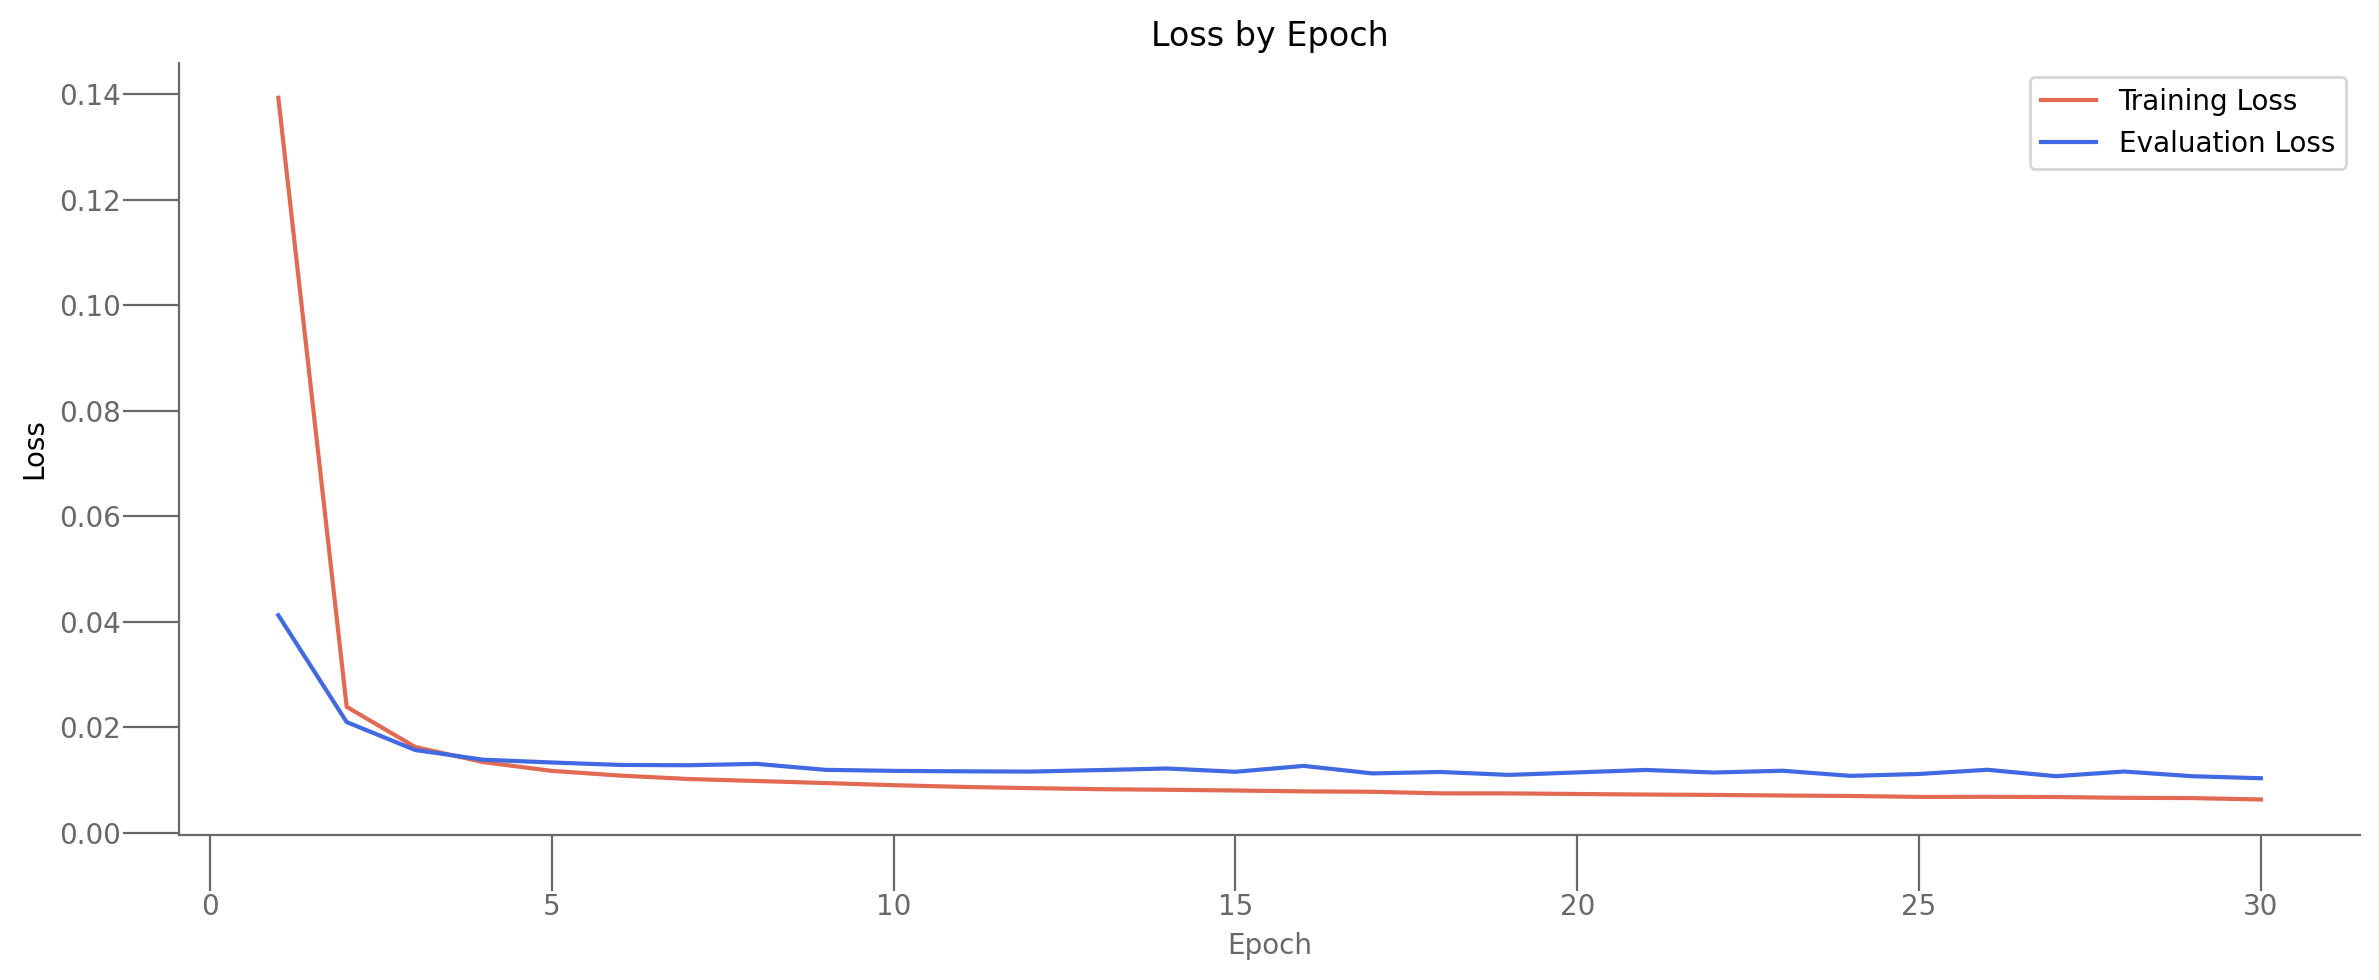


==================== TEST INFO ===================

preds:  (5, 23, 20)
test loss: 0.010044, test r2score 0.827705


In [57]:
plot_training_and_eval_losses(np.array(losses), np.array(eval_losses), num_epochs, format_plot)
losses_tst, r2score_tst, loss_nodes, predictions_bt, real_bt = trainer_bt.test()



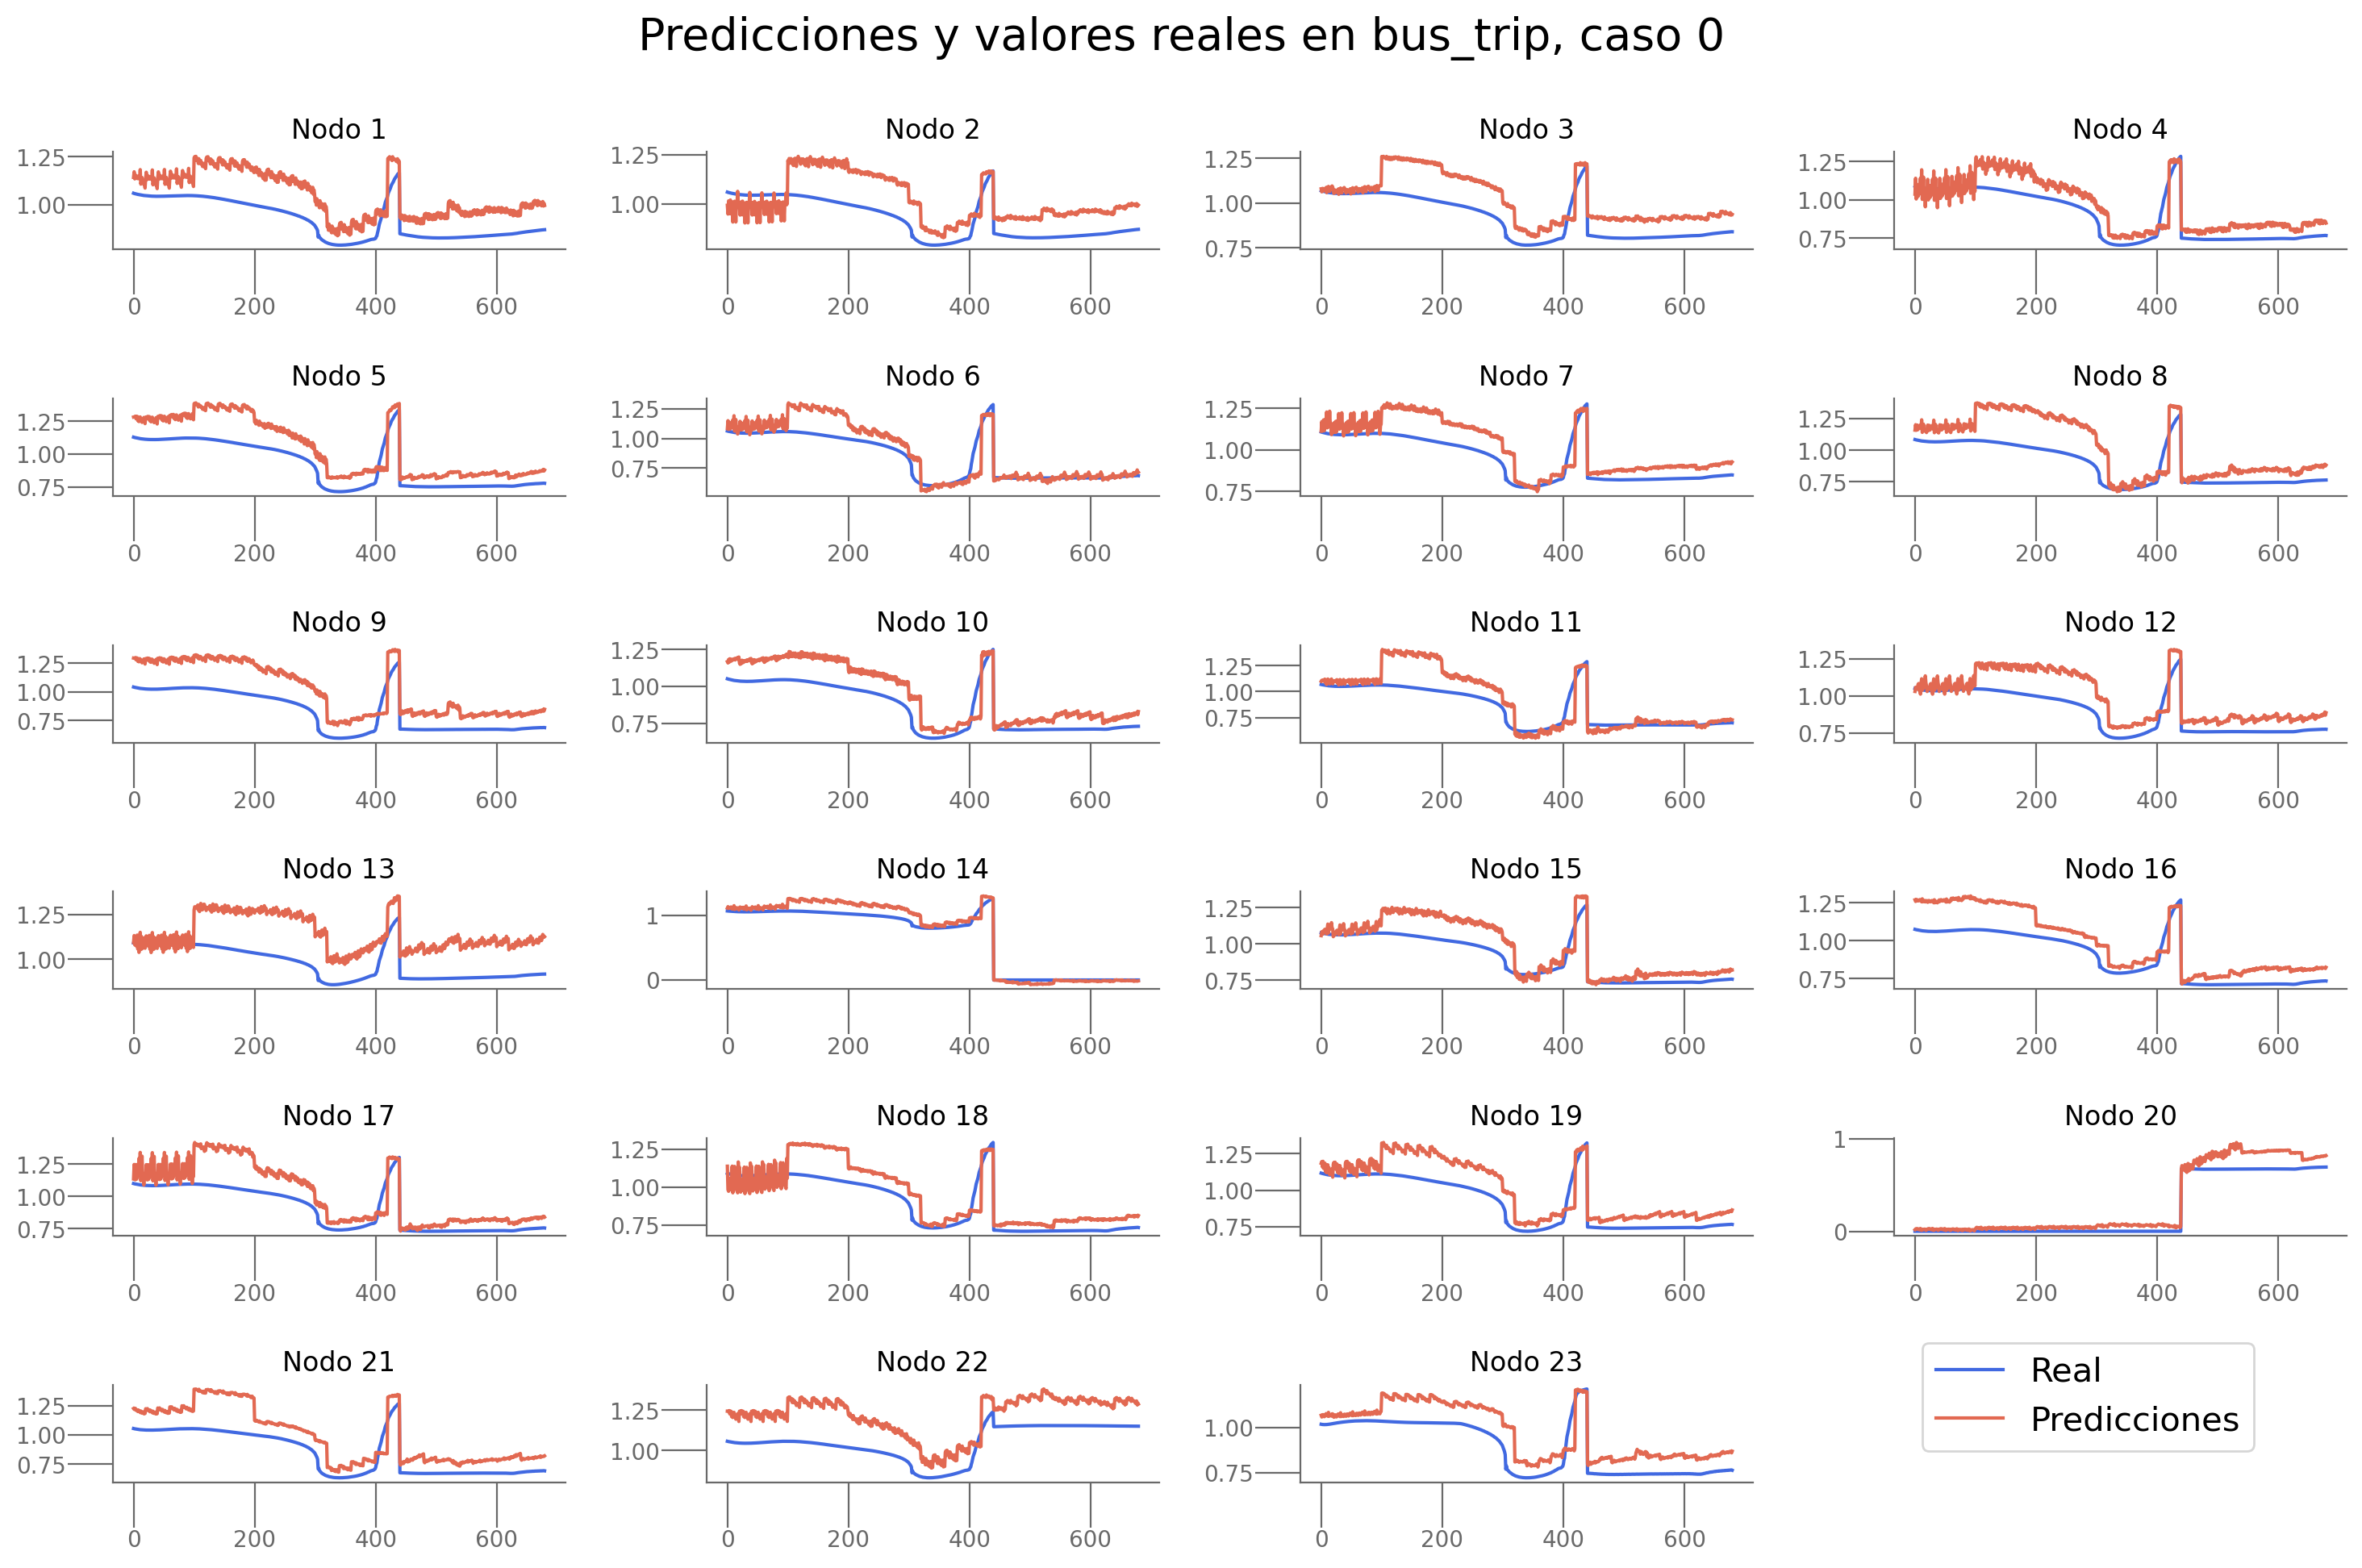

In [58]:
plot_predictions(predictions_bt, real_bt, n_target, 0, n_div_bt, problem_bt)

#### Ajuste de parámetros

In [21]:

trainer_bt,params_bt, resultados_final_bt, resultados_bt = entrenar_y_evaluar_modelos(param_grid, dataset_bt, dataloader_params2, num_early_stop=num_early_stop, num_epochs=num_epochs, problem=problem_bt)

  0%|          | 0/48 [00:00<?, ?it/s]


==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoader for train set:
Number of batches: 401
DataLoader for val set:
Number of batches: 88
DataLoader for test set:
Number of batches: 88

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.2758 | Eval Loss: 0.0637 | Eval R2: -0.0653 | LR: 0.0010 | 
Epoch 2/30 | Train Loss: 0.0494 | Eval Loss: 0.0320 | Eval R2: 0.4687 | LR: 0.0010 | 
Epoch 3/30 | Train Loss: 0.0297 | Eval Loss: 0.0249 | Eval R2: 0.5738 | LR: 0.0010 | 
Epoch 4/30 | Train Loss: 0.0230 | Eval Loss: 0.0214 | Eval R2: 0.6272 | LR: 0.0010 | 
Epoch 5/30 | Train Loss: 0.0195 | Eval Loss: 0.0183 | Eval R2: 0.6818 | LR: 0.0010 | 
Epoch 6/30 | Train Loss: 0.0171 | Eval Loss: 0.0170 | Eval R2: 0.6993 | LR: 0.0010 | 
Epoch 7/30 | Train Loss: 0.0157 | Eval Loss: 0.0155 | Eval R2: 0.7281 | LR: 0.0010 | 
Epoch 8/30 | Train Loss:

  2%|▏         | 1/48 [03:27<2:42:27, 207.40s/it]

preds:  (5, 23, 20)
test loss: 0.008059, test R2 score: 0.889874
Parámetros:  10 2 3
Resultados:  {'Embedding': 3, 'k': 2, 'Hidden': 10, 'Loss_final': 0.007721992675215006, 'R2_eval': 0.8573257923126221, 'Loss_eval': 0.007883261889219284, 'R2_tst': 0.8898744736097549, 'Loss_tst': 0.008058551698923111, 'Loss_nodes': [0.004605220165103674, 0.003817447228357196, 0.005153396632522345, 0.007333970163017511, 0.009056837297976017, 0.010015941224992275, 0.011129062622785568, 0.009416301734745502, 0.009273232892155647, 0.007135654799640179, 0.009720695205032825, 0.0054663848131895065, 0.005406343378126621, 0.00412281509488821, 0.005845661740750074, 0.0071050506085157394, 0.010898761451244354, 0.0077963219955563545, 0.008513771928846836, 0.020715566352009773, 0.01019366830587387, 0.004422900266945362, 0.008201677352190018]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ==================

  4%|▍         | 2/48 [06:35<2:30:08, 195.85s/it]

preds:  (5, 23, 20)
test loss: 0.010849, test R2 score: 0.828675
Parámetros:  10 3 3
Resultados:  {'Embedding': 3, 'k': 3, 'Hidden': 10, 'Loss_final': 0.008270376361906528, 'R2_eval': 0.7331171631813049, 'Loss_eval': 0.013073649257421494, 'R2_tst': 0.8286750373178358, 'Loss_tst': 0.010848809964954853, 'Loss_nodes': [0.003676182124763727, 0.005693867336958647, 0.01167263649404049, 0.012417376041412354, 0.01537164393812418, 0.009966573677957058, 0.007027375977486372, 0.011209300719201565, 0.01911584846675396, 0.007524360436946154, 0.014505401253700256, 0.008695649914443493, 0.004380583297461271, 0.005463440902531147, 0.007335976231843233, 0.007170747499912977, 0.009915785863995552, 0.01389539334923029, 0.011100593023002148, 0.01410108245909214, 0.014735323376953602, 0.025498561561107635, 0.009048912674188614]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================

Dat

  6%|▋         | 3/48 [10:11<2:33:54, 205.22s/it]

preds:  (5, 23, 20)
test loss: 0.009383, test R2 score: 0.864166
Parámetros:  10 4 3
Resultados:  {'Embedding': 3, 'k': 4, 'Hidden': 10, 'Loss_final': 0.00898673664778471, 'R2_eval': 0.7767882943153381, 'Loss_eval': 0.010762481950223446, 'R2_tst': 0.8641660531098981, 'Loss_tst': 0.009383195079863071, 'Loss_nodes': [0.004734134301543236, 0.006502740550786257, 0.011871791444718838, 0.008133355528116226, 0.014361899346113205, 0.012469553388655186, 0.0072050075978040695, 0.011608951725065708, 0.010735984891653061, 0.010234037414193153, 0.012644249945878983, 0.0064582559280097485, 0.006886960472911596, 0.005905895959585905, 0.007059505209326744, 0.007824311032891273, 0.010304481722414494, 0.008528046309947968, 0.009844571352005005, 0.016949404031038284, 0.012291859835386276, 0.005466389004141092, 0.0077920835465192795]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO =================

  8%|▊         | 4/48 [13:23<2:26:32, 199.83s/it]

preds:  (5, 23, 20)
test loss: 0.007369, test R2 score: 0.898855
Parámetros:  20 2 3
Resultados:  {'Embedding': 3, 'k': 2, 'Hidden': 20, 'Loss_final': 0.006480691954493523, 'R2_eval': 0.8410297632217407, 'Loss_eval': 0.008373134769499302, 'R2_tst': 0.8988551779359675, 'Loss_tst': 0.007368509657680988, 'Loss_nodes': [0.003772260155528784, 0.004130468238145113, 0.0064380173571407795, 0.008891621604561806, 0.007035763934254646, 0.010274805128574371, 0.006895852275192738, 0.009056169539690018, 0.014710170216858387, 0.008512097410857677, 0.007750167977064848, 0.005030664149671793, 0.0040914216078817844, 0.004800640046596527, 0.006544406991451979, 0.004507938399910927, 0.009699513204395771, 0.007427491247653961, 0.007246829569339752, 0.011777409352362156, 0.008987958543002605, 0.004476118367165327, 0.007417916785925627]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO =================

 10%|█         | 5/48 [16:52<2:25:39, 203.24s/it]

preds:  (5, 23, 20)
test loss: 0.008122, test R2 score: 0.881518
Parámetros:  20 3 3
Resultados:  {'Embedding': 3, 'k': 3, 'Hidden': 20, 'Loss_final': 0.006505104247480631, 'R2_eval': 0.8143547177314758, 'Loss_eval': 0.008996766060590744, 'R2_tst': 0.881518194151813, 'Loss_tst': 0.00812242366373539, 'Loss_nodes': [0.0035596827510744333, 0.007416833657771349, 0.009113353677093983, 0.008007004857063293, 0.00874689593911171, 0.010357177816331387, 0.006445967126637697, 0.00879752729088068, 0.009390207007527351, 0.00846430566161871, 0.00914865080267191, 0.004694563802331686, 0.0028101778589189053, 0.007193630561232567, 0.009306064806878567, 0.0066818613559007645, 0.009867626242339611, 0.01413399912416935, 0.007180361542850733, 0.012670725584030151, 0.009682340547442436, 0.0038938217330724, 0.009252944961190224]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================

Data

 12%|█▎        | 6/48 [20:15<2:22:14, 203.21s/it]

preds:  (5, 23, 20)
test loss: 0.013650, test R2 score: 0.770810
Parámetros:  20 4 3
Resultados:  {'Embedding': 3, 'k': 4, 'Hidden': 20, 'Loss_final': 0.008055200800299644, 'R2_eval': 0.6503574252128601, 'Loss_eval': 0.016009299084544182, 'R2_tst': 0.7708095610526319, 'Loss_tst': 0.013649586588144302, 'Loss_nodes': [0.009841996245086193, 0.011769802309572697, 0.01202383916825056, 0.024515600875020027, 0.010500391945242882, 0.020438261330127716, 0.041207097470760345, 0.012649216689169407, 0.011395812034606934, 0.018108651041984558, 0.011504852212965488, 0.010281370021402836, 0.005193223711103201, 0.005044770427048206, 0.016543490812182426, 0.006960421800613403, 0.01180215459316969, 0.008222073316574097, 0.015137328766286373, 0.01923445612192154, 0.013636430725455284, 0.005109282676130533, 0.012819983996450901]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================

D

 15%|█▍        | 7/48 [23:53<2:22:10, 208.06s/it]

preds:  (5, 23, 20)
test loss: 0.007138, test R2 score: 0.896343
Parámetros:  50 2 3
Resultados:  {'Embedding': 3, 'k': 2, 'Hidden': 50, 'Loss_final': 0.005504393018782139, 'R2_eval': 0.8294950127601624, 'Loss_eval': 0.008240336552262306, 'R2_tst': 0.8963428293237189, 'Loss_tst': 0.007137930020689964, 'Loss_nodes': [0.0026300291065126657, 0.004612990189343691, 0.007332364097237587, 0.008769898675382137, 0.007717026863247156, 0.008241688832640648, 0.004682532977312803, 0.007746319752186537, 0.011051095090806484, 0.009172548539936543, 0.009879358112812042, 0.004842766094952822, 0.0035753941629081964, 0.003745986381545663, 0.005281575955450535, 0.007250819820910692, 0.00842103362083435, 0.006768815219402313, 0.0077270641922950745, 0.01327202096581459, 0.009952322579920292, 0.0047873263247311115, 0.0067114029079675674]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ================

 17%|█▋        | 8/48 [28:28<2:32:51, 229.29s/it]

preds:  (5, 23, 20)
test loss: 0.011766, test R2 score: 0.804481
Parámetros:  50 3 3
Resultados:  {'Embedding': 3, 'k': 3, 'Hidden': 50, 'Loss_final': 0.006274660117924213, 'R2_eval': 0.694976270198822, 'Loss_eval': 0.013500642031431198, 'R2_tst': 0.8044809727864163, 'Loss_tst': 0.01176620926707983, 'Loss_nodes': [0.005108069162815809, 0.013568985275924206, 0.02200290374457836, 0.01185096800327301, 0.01749694161117077, 0.009940776973962784, 0.009475473314523697, 0.009465987794101238, 0.02302514761686325, 0.010682051070034504, 0.020805684849619865, 0.005015258211642504, 0.0215044766664505, 0.008309450000524521, 0.00674160523340106, 0.007155314087867737, 0.011411484330892563, 0.007963803596794605, 0.01114918477833271, 0.01192526612430811, 0.010532268323004246, 0.0062193842604756355, 0.00927229505032301]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoade

 19%|█▉        | 9/48 [33:12<2:40:15, 246.56s/it]

preds:  (5, 23, 20)
test loss: 0.013894, test R2 score: 0.764466
Parámetros:  50 4 3
Resultados:  {'Embedding': 3, 'k': 4, 'Hidden': 50, 'Loss_final': 0.00840278435498476, 'R2_eval': 0.6652849316596985, 'Loss_eval': 0.01502156164497137, 'R2_tst': 0.7644656612238233, 'Loss_tst': 0.0138939144089818, 'Loss_nodes': [0.006878390442579985, 0.010528725571930408, 0.008068160153925419, 0.011308938264846802, 0.009681208059191704, 0.016582466661930084, 0.00900700781494379, 0.014536082744598389, 0.01624995656311512, 0.016306322067975998, 0.013608586974442005, 0.010641111060976982, 0.025312326848506927, 0.006249134428799152, 0.013181817717850208, 0.013552343472838402, 0.021333279088139534, 0.008781657554209232, 0.02158464677631855, 0.017307182773947716, 0.01886456459760666, 0.010706945322453976, 0.019289158284664154]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================

DataLo

 21%|██        | 10/48 [38:35<2:51:00, 270.02s/it]

preds:  (5, 23, 20)
test loss: 0.008381, test R2 score: 0.875734
Parámetros:  100 2 3
Resultados:  {'Embedding': 3, 'k': 2, 'Hidden': 100, 'Loss_final': 0.005467897746711969, 'R2_eval': 0.7821609377861023, 'Loss_eval': 0.010119791142642498, 'R2_tst': 0.8757344563870798, 'Loss_tst': 0.008381068706512451, 'Loss_nodes': [0.00317877228371799, 0.004869537428021431, 0.008222292177379131, 0.008160699158906937, 0.010513980872929096, 0.009297828190028667, 0.005557205993682146, 0.007973690517246723, 0.010463539510965347, 0.010009996592998505, 0.009012462571263313, 0.006405109539628029, 0.003903004340827465, 0.011245855130255222, 0.008023515343666077, 0.0062510669231414795, 0.009604660794138908, 0.01181186642497778, 0.00959512684494257, 0.014860590919852257, 0.010277412831783295, 0.004620746709406376, 0.008905596099793911]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================

 23%|██▎       | 11/48 [45:15<3:10:59, 309.71s/it]

preds:  (5, 23, 20)
test loss: 0.010766, test R2 score: 0.819169
Parámetros:  100 3 3
Resultados:  {'Embedding': 3, 'k': 3, 'Hidden': 100, 'Loss_final': 0.0063406070694327354, 'R2_eval': 0.7114143967628479, 'Loss_eval': 0.012334260158240795, 'R2_tst': 0.8191687195412278, 'Loss_tst': 0.010766142047941685, 'Loss_nodes': [0.009024710394442081, 0.009849997237324715, 0.01018220279365778, 0.01174162421375513, 0.010285825468599796, 0.011463128961622715, 0.02189224772155285, 0.010812063701450825, 0.015043185092508793, 0.01579400710761547, 0.011906064115464687, 0.005731436889618635, 0.004877150058746338, 0.006819066591560841, 0.009929490275681019, 0.008521613664925098, 0.010534866712987423, 0.009142414666712284, 0.014130272902548313, 0.011974265798926353, 0.012211711145937443, 0.0040199039503932, 0.011734030209481716]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================

D

 25%|██▌       | 12/48 [52:38<3:30:09, 350.27s/it]

preds:  (5, 23, 20)
test loss: 0.010341, test R2 score: 0.835878
Parámetros:  100 4 3
Resultados:  {'Embedding': 3, 'k': 4, 'Hidden': 100, 'Loss_final': 0.0072904424741864204, 'R2_eval': 0.6850292682647705, 'Loss_eval': 0.013468638993799686, 'R2_tst': 0.8358784287802808, 'Loss_tst': 0.0103414636105299, 'Loss_nodes': [0.005842635408043861, 0.01132718101143837, 0.009134293533861637, 0.010306191630661488, 0.009848078712821007, 0.011175984516739845, 0.008685480803251266, 0.010740340687334538, 0.013370336033403873, 0.01206883229315281, 0.01608540676534176, 0.005909779574722052, 0.00439640274271369, 0.006663140840828419, 0.008879908360540867, 0.007509461138397455, 0.017235632985830307, 0.007838878780603409, 0.013136831112205982, 0.015225359238684177, 0.010247389785945415, 0.005141299217939377, 0.017084812745451927]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================

D

 27%|██▋       | 13/48 [55:57<2:57:36, 304.46s/it]

preds:  (5, 23, 20)
test loss: 0.007309, test R2 score: 0.898086
Parámetros:  10 2 5
Resultados:  {'Embedding': 5, 'k': 2, 'Hidden': 10, 'Loss_final': 0.006950949318706989, 'R2_eval': 0.8458027243614197, 'Loss_eval': 0.008196181617677212, 'R2_tst': 0.8980864453726712, 'Loss_tst': 0.007308680098503828, 'Loss_nodes': [0.0026431342121213675, 0.005621807649731636, 0.00529135949909687, 0.00655978312715888, 0.00912274420261383, 0.008310364559292793, 0.006835764739662409, 0.0083283307030797, 0.009316685609519482, 0.010696307756006718, 0.00929736252874136, 0.00872702244669199, 0.002816219115629792, 0.0036285235546529293, 0.003936133813112974, 0.006409735884517431, 0.008889080956578255, 0.008979043923318386, 0.007619478274136782, 0.01312281470745802, 0.01055558118969202, 0.0038317283615469933, 0.007560627069324255]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================

Data

 29%|██▉       | 14/48 [59:29<2:36:48, 276.73s/it]

preds:  (5, 23, 20)
test loss: 0.013611, test R2 score: 0.775466
Parámetros:  10 3 5
Resultados:  {'Embedding': 5, 'k': 3, 'Hidden': 10, 'Loss_final': 0.009420165792107582, 'R2_eval': 0.6949132084846497, 'Loss_eval': 0.014660612680017948, 'R2_tst': 0.7754663206423215, 'Loss_tst': 0.013610794208943844, 'Loss_nodes': [0.00630211504176259, 0.01063337828963995, 0.0055864062160253525, 0.0185557808727026, 0.01992790214717388, 0.013662565499544144, 0.007408181205391884, 0.012891030870378017, 0.019045311957597733, 0.02129228226840496, 0.01285942830145359, 0.011798840947449207, 0.007643514778465033, 0.006385209038853645, 0.010959275998175144, 0.010801304131746292, 0.013907996006309986, 0.025338904932141304, 0.011908913031220436, 0.018712542951107025, 0.021342940628528595, 0.011274284683167934, 0.014810151420533657]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================

Data

 31%|███▏      | 15/48 [1:03:13<2:23:25, 260.77s/it]

preds:  (5, 23, 20)
test loss: 0.014352, test R2 score: 0.764605
Parámetros:  10 4 5
Resultados:  {'Embedding': 5, 'k': 4, 'Hidden': 10, 'Loss_final': 0.011346209794282913, 'R2_eval': 0.6976184248924255, 'Loss_eval': 0.014621817506849766, 'R2_tst': 0.7646052058592481, 'Loss_tst': 0.014352374710142612, 'Loss_nodes': [0.0086115887388587, 0.045436467975378036, 0.008627085946500301, 0.010420494712889194, 0.01642906479537487, 0.014833208173513412, 0.011754191480576992, 0.00945317093282938, 0.013743114657700062, 0.028655527159571648, 0.010976437479257584, 0.010918231680989265, 0.009732700884342194, 0.007622502278536558, 0.006192386150360107, 0.011902963742613792, 0.014145703054964542, 0.01152747217565775, 0.010516722686588764, 0.015707064419984818, 0.014107346534729004, 0.011343017220497131, 0.027448134496808052]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================

Dat

 33%|███▎      | 16/48 [1:06:32<2:09:06, 242.07s/it]

preds:  (5, 23, 20)
test loss: 0.014491, test R2 score: 0.746845
Parámetros:  20 2 5
Resultados:  {'Embedding': 5, 'k': 2, 'Hidden': 20, 'Loss_final': 0.006154434289783239, 'R2_eval': 0.6794964075088501, 'Loss_eval': 0.014504510909318924, 'R2_tst': 0.7468452970486826, 'Loss_tst': 0.014491050504148006, 'Loss_nodes': [0.008700547739863396, 0.005802697967737913, 0.005987107288092375, 0.012347557581961155, 0.021517198532819748, 0.010788483545184135, 0.0073778582736849785, 0.015335164032876492, 0.029105953872203827, 0.01550404354929924, 0.022090429440140724, 0.012545591220259666, 0.018405037000775337, 0.007192996330559254, 0.01626773364841938, 0.006278904154896736, 0.02096603810787201, 0.010246449150145054, 0.017145119607448578, 0.015887679532170296, 0.02679266780614853, 0.018419627100229263, 0.008589311502873898]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================

D

 35%|███▌      | 17/48 [1:09:56<1:59:15, 230.83s/it]

preds:  (5, 23, 20)
test loss: 0.010177, test R2 score: 0.846650
Parámetros:  20 3 5
Resultados:  {'Embedding': 5, 'k': 3, 'Hidden': 20, 'Loss_final': 0.0073307231068611145, 'R2_eval': 0.7325052618980408, 'Loss_eval': 0.011937743984162807, 'R2_tst': 0.8466495779537815, 'Loss_tst': 0.010177397169172764, 'Loss_nodes': [0.005824188701808453, 0.006506635341793299, 0.008883543312549591, 0.01124825980514288, 0.011421487666666508, 0.01268568355590105, 0.007854579947888851, 0.009157613851130009, 0.012670873664319515, 0.011487753130495548, 0.013018414378166199, 0.00957630854099989, 0.005631947889924049, 0.006690191105008125, 0.0074226935394108295, 0.010042707435786724, 0.011149019934237003, 0.020738545805215836, 0.010358587838709354, 0.012001272290945053, 0.016222698614001274, 0.0065466477535665035, 0.006940487306565046]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================

 38%|███▊      | 18/48 [1:13:48<1:55:28, 230.96s/it]

preds:  (5, 23, 20)
test loss: 0.010630, test R2 score: 0.832043
Parámetros:  20 4 5
Resultados:  {'Embedding': 5, 'k': 4, 'Hidden': 20, 'Loss_final': 0.008214344270527363, 'R2_eval': 0.6832501888275146, 'Loss_eval': 0.01381387747824192, 'R2_tst': 0.8320434479232252, 'Loss_tst': 0.010630270466208458, 'Loss_nodes': [0.006703450810164213, 0.0066141183488070965, 0.007979975081980228, 0.010506313294172287, 0.010626386851072311, 0.015236277133226395, 0.0071390969678759575, 0.011494919657707214, 0.015532181598246098, 0.012167378328740597, 0.010481176897883415, 0.00865718349814415, 0.012453079223632812, 0.009129858575761318, 0.008595994673669338, 0.006018282845616341, 0.014868817292153835, 0.013239046558737755, 0.011991217732429504, 0.01342914067208767, 0.011728774756193161, 0.008443901315331459, 0.01145964302122593]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================



 40%|███▉      | 19/48 [1:17:25<1:49:34, 226.70s/it]

preds:  (5, 23, 20)
test loss: 0.011140, test R2 score: 0.815404
Parámetros:  50 2 5
Resultados:  {'Embedding': 5, 'k': 2, 'Hidden': 50, 'Loss_final': 0.006378175690770149, 'R2_eval': 0.7293844819068909, 'Loss_eval': 0.012175729498267174, 'R2_tst': 0.8154043179566197, 'Loss_tst': 0.01114033441990614, 'Loss_nodes': [0.012353550642728806, 0.005449270363897085, 0.0064294650219380856, 0.012222585268318653, 0.02587059698998928, 0.00987768080085516, 0.005692504812031984, 0.016590628772974014, 0.022294215857982635, 0.009546295739710331, 0.009406187571585178, 0.008171201683580875, 0.005307126324623823, 0.006899651605635881, 0.007047411520034075, 0.0065562548115849495, 0.020960098132491112, 0.007307031657546759, 0.008970867842435837, 0.013429969549179077, 0.012356462888419628, 0.015239894390106201, 0.008248726837337017]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================


 42%|████▏     | 20/48 [1:21:46<1:50:38, 237.10s/it]

preds:  (5, 23, 20)
test loss: 0.009750, test R2 score: 0.850625
Parámetros:  50 3 5
Resultados:  {'Embedding': 5, 'k': 3, 'Hidden': 50, 'Loss_final': 0.007098132744431496, 'R2_eval': 0.7114686965942383, 'Loss_eval': 0.012138059362769127, 'R2_tst': 0.8506246153860098, 'Loss_tst': 0.00975046493113041, 'Loss_nodes': [0.006171011831611395, 0.00923185609281063, 0.0075492532923817635, 0.008886761032044888, 0.01343939546495676, 0.011347904801368713, 0.008744225837290287, 0.012720688246190548, 0.013900977559387684, 0.010590902529656887, 0.014026029966771603, 0.00844539050012827, 0.00477171503007412, 0.005345899146050215, 0.006898531224578619, 0.00672301696613431, 0.01184818148612976, 0.011046984232962132, 0.009411369450390339, 0.012709739618003368, 0.010019365698099136, 0.010795767419040203, 0.009635735303163528]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================

Data

 44%|████▍     | 21/48 [1:26:12<1:50:33, 245.70s/it]

preds:  (5, 23, 20)
test loss: 0.011873, test R2 score: 0.811569
Parámetros:  50 4 5
Resultados:  {'Embedding': 5, 'k': 4, 'Hidden': 50, 'Loss_final': 0.008245791308581829, 'R2_eval': 0.6768398880958557, 'Loss_eval': 0.014477741904556751, 'R2_tst': 0.8115693297371943, 'Loss_tst': 0.011872961185872555, 'Loss_nodes': [0.00843427237123251, 0.01134223211556673, 0.007713582832366228, 0.01014946773648262, 0.0131688779219985, 0.012005516327917576, 0.02054676227271557, 0.009134622290730476, 0.014127487316727638, 0.011382034979760647, 0.011075463145971298, 0.010961081832647324, 0.008971619419753551, 0.01003472600132227, 0.0070952135138213634, 0.013491556979715824, 0.013477716594934464, 0.016101742163300514, 0.01192876324057579, 0.018410123884677887, 0.01573900878429413, 0.0068282182328403, 0.010957976803183556]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoad

 46%|████▌     | 22/48 [1:31:24<1:55:10, 265.78s/it]

preds:  (5, 23, 20)
test loss: 0.009601, test R2 score: 0.853358
Parámetros:  100 2 5
Resultados:  {'Embedding': 5, 'k': 2, 'Hidden': 100, 'Loss_final': 0.006972033064812422, 'R2_eval': 0.7364049553871155, 'Loss_eval': 0.01143469475209713, 'R2_tst': 0.8533581217357991, 'Loss_tst': 0.009601040743291378, 'Loss_nodes': [0.007663227617740631, 0.004786267410963774, 0.00768879521638155, 0.008767474442720413, 0.011574097909033298, 0.010149592533707619, 0.0062188939191401005, 0.010356631129980087, 0.012214780785143375, 0.00972610805183649, 0.012770487926900387, 0.006982083898037672, 0.007064072415232658, 0.005714069586247206, 0.008091321215033531, 0.01741340011358261, 0.013010179623961449, 0.008586909621953964, 0.011605544947087765, 0.010683892294764519, 0.014520430006086826, 0.006970533635467291, 0.008265144191682339]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================


 48%|████▊     | 23/48 [1:37:50<2:05:46, 301.88s/it]

preds:  (5, 23, 20)
test loss: 0.012689, test R2 score: 0.795196
Parámetros:  100 3 5
Resultados:  {'Embedding': 5, 'k': 3, 'Hidden': 100, 'Loss_final': 0.007575714495033026, 'R2_eval': 0.6478275656700134, 'Loss_eval': 0.015201013535261154, 'R2_tst': 0.7951961571708007, 'Loss_tst': 0.012688945978879929, 'Loss_nodes': [0.006853185594081879, 0.00801295880228281, 0.010906270705163479, 0.01129647996276617, 0.0147332102060318, 0.011941320262849331, 0.007607086095958948, 0.011296795681118965, 0.01319940760731697, 0.009339160285890102, 0.05599244683980942, 0.007648705970495939, 0.009376557543873787, 0.007189303170889616, 0.008640400134027004, 0.006708179134875536, 0.011404290795326233, 0.020778648555278778, 0.016792507842183113, 0.014875221997499466, 0.012388872914016247, 0.006190501619130373, 0.008674257434904575]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================

Da

 50%|█████     | 24/48 [1:44:51<2:15:00, 337.52s/it]

preds:  (5, 23, 20)
test loss: 0.012746, test R2 score: 0.792608
Parámetros:  100 4 5
Resultados:  {'Embedding': 5, 'k': 4, 'Hidden': 100, 'Loss_final': 0.008823690004646778, 'R2_eval': 0.6345197558403015, 'Loss_eval': 0.015851488336920738, 'R2_tst': 0.7926078604757503, 'Loss_tst': 0.012746458873152733, 'Loss_nodes': [0.006949601694941521, 0.011721416376531124, 0.009903562255203724, 0.011892322450876236, 0.0154643002897501, 0.013912391848862171, 0.00851754192262888, 0.01227572187781334, 0.015654800459742546, 0.009545725770294666, 0.015022661536931992, 0.012315026484429836, 0.009969068691134453, 0.007579044904559851, 0.02629683166742325, 0.010933343321084976, 0.014451086521148682, 0.02003874070942402, 0.011094743385910988, 0.015454855747520924, 0.018454154953360558, 0.006619747262448072, 0.00910183135420084]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================

Dat

 52%|█████▏    | 25/48 [1:48:13<1:53:47, 296.83s/it]

preds:  (5, 23, 20)
test loss: 0.011136, test R2 score: 0.826794
Parámetros:  10 2 10
Resultados:  {'Embedding': 10, 'k': 2, 'Hidden': 10, 'Loss_final': 0.007295082323253155, 'R2_eval': 0.7109331488609314, 'Loss_eval': 0.013418509624898434, 'R2_tst': 0.8267940073827578, 'Loss_tst': 0.011136374436318874, 'Loss_nodes': [0.007189829833805561, 0.00893845409154892, 0.007644645869731903, 0.007184654474258423, 0.02242210879921913, 0.012341824360191822, 0.008635909296572208, 0.014421812258660793, 0.01110543217509985, 0.014093228615820408, 0.018936021253466606, 0.006387898698449135, 0.006578242406249046, 0.008539444766938686, 0.008239737711846828, 0.009637177921831608, 0.010928057134151459, 0.009022669866681099, 0.014536532573401928, 0.013497227802872658, 0.015123038552701473, 0.009013306349515915, 0.011719366535544395]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================


 54%|█████▍    | 26/48 [1:51:41<1:39:02, 270.12s/it]

preds:  (5, 23, 20)
test loss: 0.023728, test R2 score: 0.573989
Parámetros:  10 3 10
Resultados:  {'Embedding': 10, 'k': 3, 'Hidden': 10, 'Loss_final': 0.012338048778474331, 'R2_eval': 0.49995458126068115, 'Loss_eval': 0.02397722192108631, 'R2_tst': 0.5739888743471621, 'Loss_tst': 0.023727791383862495, 'Loss_nodes': [0.045645084232091904, 0.011176425032317638, 0.012257665395736694, 0.020136067643761635, 0.018680298700928688, 0.012916922569274902, 0.15071843564510345, 0.026735452935099602, 0.016874801367521286, 0.018534887582063675, 0.014402618631720543, 0.012028752826154232, 0.02529934234917164, 0.007082385942339897, 0.00865168496966362, 0.01755369082093239, 0.027795130386948586, 0.009625930339097977, 0.026763390749692917, 0.024013210088014603, 0.012825793586671352, 0.010264936834573746, 0.01575625315308571]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================

D

 56%|█████▋    | 27/48 [1:55:17<1:28:53, 253.95s/it]

preds:  (5, 23, 20)
test loss: 0.021621, test R2 score: 0.622653
Parámetros:  10 4 10
Resultados:  {'Embedding': 10, 'k': 4, 'Hidden': 10, 'Loss_final': 0.017091181129217148, 'R2_eval': 0.5215715765953064, 'Loss_eval': 0.024005163460969925, 'R2_tst': 0.6226528332684995, 'Loss_tst': 0.02162071317434311, 'Loss_nodes': [0.022672688588500023, 0.008747362531721592, 0.013130870647728443, 0.014399775303900242, 0.028456605970859528, 0.023352913558483124, 0.013829771429300308, 0.020729228854179382, 0.020272107794880867, 0.018629468977451324, 0.0313410721719265, 0.015389690175652504, 0.01377407368272543, 0.01815970055758953, 0.021289722993969917, 0.02525464817881584, 0.029523340985178947, 0.010729890316724777, 0.058069005608558655, 0.029118483886122704, 0.013510068878531456, 0.007954278029501438, 0.038941655308008194]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================

Da

 58%|█████▊    | 28/48 [1:58:24<1:17:58, 233.93s/it]

preds:  (5, 23, 20)
test loss: 0.010159, test R2 score: 0.846881
Parámetros:  20 2 10
Resultados:  {'Embedding': 10, 'k': 2, 'Hidden': 20, 'Loss_final': 0.007278143428266048, 'R2_eval': 0.7519637942314148, 'Loss_eval': 0.011391278356313705, 'R2_tst': 0.846880866853541, 'Loss_tst': 0.010158701799809933, 'Loss_nodes': [0.006595246028155088, 0.0051019261591136456, 0.009234104305505753, 0.009043002501130104, 0.014642111025750637, 0.012028280645608902, 0.007823001593351364, 0.010707716457545757, 0.010332384146749973, 0.00855694618076086, 0.017106102779507637, 0.007153230719268322, 0.004964490421116352, 0.004129538778215647, 0.007669446058571339, 0.007218309212476015, 0.014889216050505638, 0.016774071380496025, 0.016247764229774475, 0.014477457851171494, 0.01309863943606615, 0.00569223752245307, 0.010164893232285976]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================


 60%|██████    | 29/48 [2:02:05<1:12:51, 230.06s/it]

preds:  (5, 23, 20)
test loss: 0.013607, test R2 score: 0.771118
Parámetros:  20 3 10
Resultados:  {'Embedding': 10, 'k': 3, 'Hidden': 20, 'Loss_final': 0.009110125713050365, 'R2_eval': 0.6653377413749695, 'Loss_eval': 0.015141183510422707, 'R2_tst': 0.7711178767361333, 'Loss_tst': 0.013606754131615162, 'Loss_nodes': [0.007498484570533037, 0.016090692952275276, 0.013901149854063988, 0.01159947831183672, 0.01841649040579796, 0.01597171276807785, 0.010166916996240616, 0.014193067327141762, 0.02896789275109768, 0.014021147042512894, 0.01481920387595892, 0.007586847059428692, 0.009715495631098747, 0.012083438225090504, 0.009103498421609402, 0.011837149038910866, 0.0169825479388237, 0.010045693255960941, 0.02251066453754902, 0.019728166982531548, 0.012746300548315048, 0.006536567583680153, 0.008432768285274506]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================

Data

 62%|██████▎   | 30/48 [2:05:58<1:09:18, 231.01s/it]

preds:  (5, 23, 20)
test loss: 0.013342, test R2 score: 0.784629
Parámetros:  20 4 10
Resultados:  {'Embedding': 10, 'k': 4, 'Hidden': 20, 'Loss_final': 0.01085268147289753, 'R2_eval': 0.6743582487106323, 'Loss_eval': 0.01486447174102068, 'R2_tst': 0.7846285702349391, 'Loss_tst': 0.013341707177460194, 'Loss_nodes': [0.0185798779129982, 0.012808679603040218, 0.011938326992094517, 0.009751392528414726, 0.01240555103868246, 0.014249017462134361, 0.011734608560800552, 0.01730252616107464, 0.024277042597532272, 0.010340374894440174, 0.011731967329978943, 0.012631588615477085, 0.00747748464345932, 0.00819224864244461, 0.009017431177198887, 0.008785274811089039, 0.017792344093322754, 0.008765808306634426, 0.025051884353160858, 0.01881934329867363, 0.013379553332924843, 0.007929198443889618, 0.013897726312279701]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================

DataL

 65%|██████▍   | 31/48 [2:09:39<1:04:36, 228.01s/it]

preds:  (5, 23, 20)
test loss: 0.016473, test R2 score: 0.709065
Parámetros:  50 2 10
Resultados:  {'Embedding': 10, 'k': 2, 'Hidden': 50, 'Loss_final': 0.006823524367064238, 'R2_eval': 0.5774862170219421, 'Loss_eval': 0.018828071653842926, 'R2_tst': 0.7090646356217862, 'Loss_tst': 0.016472788527607918, 'Loss_nodes': [0.011788713745772839, 0.007777275517582893, 0.01609780266880989, 0.019344724714756012, 0.02528572827577591, 0.029986442998051643, 0.0160518866032362, 0.011975564993917942, 0.01912117749452591, 0.015462091192603111, 0.024662481620907784, 0.00854604970663786, 0.005435535218566656, 0.005656333640217781, 0.01718819886445999, 0.015953782945871353, 0.016336385160684586, 0.03777826949954033, 0.01513662375509739, 0.01576528139412403, 0.02495354600250721, 0.006199910771101713, 0.012370320968329906]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoa

 67%|██████▋   | 32/48 [2:13:56<1:03:04, 236.53s/it]

preds:  (5, 23, 20)
test loss: 0.021326, test R2 score: 0.611839
Parámetros:  50 3 10
Resultados:  {'Embedding': 10, 'k': 3, 'Hidden': 50, 'Loss_final': 0.009337129071354866, 'R2_eval': 0.49022358655929565, 'Loss_eval': 0.022976117208600044, 'R2_tst': 0.6118390830528618, 'Loss_tst': 0.021326035261154175, 'Loss_nodes': [0.01260255929082632, 0.012688794173300266, 0.01311434805393219, 0.013862994499504566, 0.013810092583298683, 0.015471951104700565, 0.04544757306575775, 0.017293913289904594, 0.01944664865732193, 0.03155258670449257, 0.01948360912501812, 0.009661865420639515, 0.033774252980947495, 0.02317795716226101, 0.009716740809381008, 0.08267613500356674, 0.02014501392841339, 0.015449151396751404, 0.022944843396544456, 0.020608313381671906, 0.011046532541513443, 0.016352210193872452, 0.010170716792345047]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================

Data

 69%|██████▉   | 33/48 [2:19:01<1:04:16, 257.09s/it]

preds:  (5, 23, 20)
test loss: 0.019228, test R2 score: 0.662830
Parámetros:  50 4 10
Resultados:  {'Embedding': 10, 'k': 4, 'Hidden': 50, 'Loss_final': 0.011629804037511349, 'R2_eval': 0.5528160333633423, 'Loss_eval': 0.021122407168149948, 'R2_tst': 0.6628300476920989, 'Loss_tst': 0.01922798901796341, 'Loss_nodes': [0.011413443833589554, 0.010941253043711185, 0.033876992762088776, 0.014737587422132492, 0.019877981394529343, 0.017108796164393425, 0.01934409886598587, 0.02086734212934971, 0.015498895198106766, 0.014338826760649681, 0.014049116522073746, 0.011611209250986576, 0.007163584232330322, 0.016469525173306465, 0.05590164288878441, 0.015869414433836937, 0.02376449853181839, 0.017013363540172577, 0.035506781190633774, 0.025321567431092262, 0.01672409661114216, 0.013201356865465641, 0.011642372235655785]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================

Da

 71%|███████   | 34/48 [2:24:46<1:06:09, 283.54s/it]

preds:  (5, 23, 20)
test loss: 0.012948, test R2 score: 0.793836
Parámetros:  100 2 10
Resultados:  {'Embedding': 10, 'k': 2, 'Hidden': 100, 'Loss_final': 0.0078110345639288425, 'R2_eval': 0.6556214690208435, 'Loss_eval': 0.01558694802224636, 'R2_tst': 0.7938359486050559, 'Loss_tst': 0.012947565875947475, 'Loss_nodes': [0.006088025867938995, 0.009523686021566391, 0.013773996382951736, 0.00947745144367218, 0.019480761140584946, 0.012092739343643188, 0.012354272417724133, 0.012459649704396725, 0.01592959277331829, 0.027173621580004692, 0.01173690240830183, 0.010180382989346981, 0.00578739307820797, 0.005888303741812706, 0.01015570666640997, 0.00905978586524725, 0.01269639190286398, 0.02576502412557602, 0.01856895536184311, 0.013867834582924843, 0.016145212575793266, 0.008114905096590519, 0.011473455466330051]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================

Dat

 73%|███████▎  | 35/48 [2:31:46<1:10:18, 324.52s/it]

preds:  (5, 23, 20)
test loss: 0.013788, test R2 score: 0.778818
Parámetros:  100 3 10
Resultados:  {'Embedding': 10, 'k': 3, 'Hidden': 100, 'Loss_final': 0.008998870849609375, 'R2_eval': 0.6132011413574219, 'Loss_eval': 0.017178192734718323, 'R2_tst': 0.7788183022104267, 'Loss_tst': 0.013788395561277866, 'Loss_nodes': [0.018486710265278816, 0.020262476056814194, 0.008856764994561672, 0.012238547205924988, 0.009976894594728947, 0.015797710046172142, 0.011195211671292782, 0.015441004186868668, 0.014461761340498924, 0.00997106172144413, 0.01974228210747242, 0.00947157759219408, 0.008670572191476822, 0.007715544197708368, 0.009050765074789524, 0.00818388070911169, 0.022664731368422508, 0.011422738432884216, 0.012748208828270435, 0.031817175447940826, 0.01170757133513689, 0.006347021088004112, 0.02090292051434517]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================



 75%|███████▌  | 36/48 [2:40:11<1:15:42, 378.55s/it]

preds:  (5, 23, 20)
test loss: 0.014530, test R2 score: 0.763777
Parámetros:  100 4 10
Resultados:  {'Embedding': 10, 'k': 4, 'Hidden': 100, 'Loss_final': 0.010553604923188686, 'R2_eval': 0.6023702621459961, 'Loss_eval': 0.017710726708173752, 'R2_tst': 0.7637768363206502, 'Loss_tst': 0.014529540203511715, 'Loss_nodes': [0.009741447865962982, 0.010813768021762371, 0.011857218109071255, 0.0176985040307045, 0.015203402377665043, 0.01691540889441967, 0.011173733510077, 0.017052868381142616, 0.01786857470870018, 0.01577761396765709, 0.01912112534046173, 0.017371445894241333, 0.008825810626149178, 0.007928743027150631, 0.010805834084749222, 0.010675156489014626, 0.0231237281113863, 0.013332131318747997, 0.013420048169791698, 0.029275448992848396, 0.01268219854682684, 0.012338525615632534, 0.01117666345089674]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoa

 77%|███████▋  | 37/48 [2:43:17<58:49, 320.91s/it]  

preds:  (5, 23, 20)
test loss: 0.014502, test R2 score: 0.755569
Parámetros:  10 2 15
Resultados:  {'Embedding': 15, 'k': 2, 'Hidden': 10, 'Loss_final': 0.009791988879442215, 'R2_eval': 0.5996029376983643, 'Loss_eval': 0.018895713612437248, 'R2_tst': 0.755568692117955, 'Loss_tst': 0.014501688070595264, 'Loss_nodes': [0.012056819163262844, 0.01413701381534338, 0.01120905764400959, 0.010443489998579025, 0.012042180635035038, 0.020147724077105522, 0.010155739262700081, 0.012683100067079067, 0.0136307617649436, 0.008653136901557446, 0.0114882942289114, 0.009145120158791542, 0.00951177254319191, 0.009330532513558865, 0.012019205838441849, 0.013071970082819462, 0.016171999275684357, 0.0116804838180542, 0.023922739550471306, 0.016957305371761322, 0.049602195620536804, 0.010048755444586277, 0.015429455786943436]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================

DataLo

 79%|███████▉  | 38/48 [2:46:50<48:04, 288.44s/it]

preds:  (5, 23, 20)
test loss: 0.034245, test R2 score: 0.366255
Parámetros:  10 3 15
Resultados:  {'Embedding': 15, 'k': 3, 'Hidden': 10, 'Loss_final': 0.022372538223862648, 'R2_eval': 0.3283306658267975, 'Loss_eval': 0.03288324177265167, 'R2_tst': 0.3662554155477081, 'Loss_tst': 0.034245286136865616, 'Loss_nodes': [0.1876911073923111, 0.021407486870884895, 0.016842670738697052, 0.020764581859111786, 0.04398695006966591, 0.01879965141415596, 0.017801525071263313, 0.024825436994433403, 0.024413766339421272, 0.03208804503083229, 0.01242317259311676, 0.018214954063296318, 0.012021935544908047, 0.013557136058807373, 0.027744758874177933, 0.019986175000667572, 0.03438173606991768, 0.04121670126914978, 0.08592171967029572, 0.030725987628102303, 0.030090242624282837, 0.01484212838113308, 0.03789379820227623]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoad

 81%|████████▏ | 39/48 [2:50:37<40:29, 269.99s/it]

preds:  (5, 23, 20)
test loss: 0.041175, test R2 score: 0.277741
Parámetros:  10 4 15
Resultados:  {'Embedding': 15, 'k': 4, 'Hidden': 10, 'Loss_final': 0.036200448870658875, 'R2_eval': 0.08136587589979172, 'Loss_eval': 0.04665255546569824, 'R2_tst': 0.2777406724597043, 'Loss_tst': 0.04117470607161522, 'Loss_nodes': [0.01936468854546547, 0.09235977381467819, 0.03966434672474861, 0.032583869993686676, 0.020906122401356697, 0.06315945088863373, 0.04174443706870079, 0.04287657514214516, 0.023680228739976883, 0.12432370334863663, 0.036652348935604095, 0.019122367724776268, 0.012895405292510986, 0.023224400356411934, 0.024657098576426506, 0.04536474123597145, 0.01762404851615429, 0.01782774180173874, 0.04725241661071777, 0.03649165853857994, 0.023363113403320312, 0.03938937932252884, 0.10249035805463791]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoader 

 83%|████████▎ | 40/48 [2:53:57<33:12, 249.12s/it]

preds:  (5, 23, 20)
test loss: 0.022147, test R2 score: 0.587682
Parámetros:  20 2 15
Resultados:  {'Embedding': 15, 'k': 2, 'Hidden': 20, 'Loss_final': 0.011410159058868885, 'R2_eval': 0.4350595772266388, 'Loss_eval': 0.02597319334745407, 'R2_tst': 0.5876821226676167, 'Loss_tst': 0.022146882489323616, 'Loss_nodes': [0.012814744375646114, 0.010434224270284176, 0.012831369414925575, 0.013463065959513187, 0.017173955217003822, 0.019622255116701126, 0.0261872299015522, 0.031101228669285774, 0.0323638953268528, 0.02666953206062317, 0.056843101978302, 0.039352767169475555, 0.021783431991934776, 0.009186401963233948, 0.015423029661178589, 0.019213171675801277, 0.03456544503569603, 0.0325486995279789, 0.02164105325937271, 0.01768391579389572, 0.019227048382163048, 0.007458055391907692, 0.011790706776082516]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoader

 85%|████████▌ | 41/48 [2:57:40<28:08, 241.15s/it]

preds:  (5, 23, 20)
test loss: 0.020474, test R2 score: 0.654815
Parámetros:  20 3 15
Resultados:  {'Embedding': 15, 'k': 3, 'Hidden': 20, 'Loss_final': 0.012864743359386921, 'R2_eval': 0.5848091244697571, 'Loss_eval': 0.020304860547184944, 'R2_tst': 0.6548148128544148, 'Loss_tst': 0.02047373726963997, 'Loss_nodes': [0.014209567569196224, 0.010820150375366211, 0.03119918517768383, 0.018978729844093323, 0.02564353495836258, 0.017029263079166412, 0.018423564732074738, 0.015024245716631413, 0.015383659861981869, 0.01484525203704834, 0.016590772196650505, 0.009209578856825829, 0.031403422355651855, 0.012934432365000248, 0.03843531385064125, 0.010963228531181812, 0.02678605727851391, 0.026711352169513702, 0.025485871359705925, 0.019069643691182137, 0.012807419523596764, 0.01709388941526413, 0.0418478287756443]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================

DataL

 88%|████████▊ | 42/48 [3:01:15<23:20, 233.49s/it]

preds:  (5, 23, 20)
test loss: 0.031182, test R2 score: 0.437215
Parámetros:  20 4 15
Resultados:  {'Embedding': 15, 'k': 4, 'Hidden': 20, 'Loss_final': 0.020838821306824684, 'R2_eval': 0.2871992886066437, 'Loss_eval': 0.03434533625841141, 'R2_tst': 0.43721520128133096, 'Loss_tst': 0.031182436272501945, 'Loss_nodes': [0.034291498363018036, 0.02280389703810215, 0.02936389483511448, 0.04904608428478241, 0.03769461810588837, 0.024757176637649536, 0.0265660360455513, 0.026015646755695343, 0.03799298405647278, 0.03645920380949974, 0.019698621705174446, 0.035084620118141174, 0.008875257335603237, 0.01885046809911728, 0.06466798484325409, 0.013411473482847214, 0.022776665166020393, 0.048733506351709366, 0.04789036512374878, 0.02847924269735813, 0.020460186526179314, 0.020146943628787994, 0.043129634112119675]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoad

 90%|████████▉ | 43/48 [3:04:56<19:07, 229.52s/it]

preds:  (5, 23, 20)
test loss: 0.018698, test R2 score: 0.667417
Parámetros:  50 2 15
Resultados:  {'Embedding': 15, 'k': 2, 'Hidden': 50, 'Loss_final': 0.00931332353502512, 'R2_eval': 0.479608416557312, 'Loss_eval': 0.023053286597132683, 'R2_tst': 0.6674165168823095, 'Loss_tst': 0.018697619438171387, 'Loss_nodes': [0.008494223468005657, 0.016637742519378662, 0.03198667988181114, 0.015850119292736053, 0.012982677668333054, 0.017442064359784126, 0.015958979725837708, 0.030331917107105255, 0.0194181427359581, 0.010769153945147991, 0.02365701273083687, 0.015213671140372753, 0.025446100160479546, 0.014052280224859715, 0.009021804668009281, 0.014692655764520168, 0.014759036712348461, 0.03366604819893837, 0.02907240390777588, 0.02975897118449211, 0.01392200868576765, 0.013858560472726822, 0.013053023256361485]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================

DataLo

 92%|█████████▏| 44/48 [3:09:30<16:11, 242.80s/it]

preds:  (5, 23, 20)
test loss: 0.019298, test R2 score: 0.663564
Parámetros:  50 3 15
Resultados:  {'Embedding': 15, 'k': 3, 'Hidden': 50, 'Loss_final': 0.011729825288057327, 'R2_eval': 0.5419031977653503, 'Loss_eval': 0.020374219864606857, 'R2_tst': 0.6635639764892973, 'Loss_tst': 0.01929822750389576, 'Loss_nodes': [0.010875248350203037, 0.016723383218050003, 0.01427436713129282, 0.01842869073152542, 0.018672745674848557, 0.023408187553286552, 0.014203298836946487, 0.05424579232931137, 0.020031096413731575, 0.034664519131183624, 0.021771905943751335, 0.009612496942281723, 0.017634935677051544, 0.015789931640028954, 0.017110152170062065, 0.00984225794672966, 0.022221986204385757, 0.020051686093211174, 0.014157715253531933, 0.02068709023296833, 0.02031661756336689, 0.01401460263878107, 0.01512056589126587]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================

DataL

 94%|█████████▍| 45/48 [3:14:38<13:07, 262.45s/it]

preds:  (5, 23, 20)
test loss: 0.021516, test R2 score: 0.631536
Parámetros:  50 4 15
Resultados:  {'Embedding': 15, 'k': 4, 'Hidden': 50, 'Loss_final': 0.016171876341104507, 'R2_eval': 0.45224034786224365, 'Loss_eval': 0.025368189439177513, 'R2_tst': 0.6315360819982232, 'Loss_tst': 0.021516311913728714, 'Loss_nodes': [0.0145913390442729, 0.015348299406468868, 0.019653644412755966, 0.020885372534394264, 0.022924769669771194, 0.032339781522750854, 0.012778466567397118, 0.01907293312251568, 0.016594165936112404, 0.02085922658443451, 0.01837308518588543, 0.011475157923996449, 0.016392234712839127, 0.014073488302528858, 0.029720209538936615, 0.01661347784101963, 0.018730761483311653, 0.016023697331547737, 0.03606782481074333, 0.02066182531416416, 0.018644990399479866, 0.02931741066277027, 0.053733039647340775]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================

Data

 96%|█████████▌| 46/48 [3:20:13<09:28, 284.14s/it]

preds:  (5, 23, 20)
test loss: 0.014991, test R2 score: 0.742835
Parámetros:  100 2 15
Resultados:  {'Embedding': 15, 'k': 2, 'Hidden': 100, 'Loss_final': 0.008698215708136559, 'R2_eval': 0.5370164513587952, 'Loss_eval': 0.02020643837749958, 'R2_tst': 0.7428348927218622, 'Loss_tst': 0.014991405420005322, 'Loss_nodes': [0.012414478696882725, 0.020675770938396454, 0.02411743439733982, 0.018566032871603966, 0.01686672493815422, 0.014618641696870327, 0.013411329127848148, 0.01661895215511322, 0.012634188868105412, 0.011711628176271915, 0.02123209275305271, 0.009432260878384113, 0.011192020028829575, 0.008192933164536953, 0.01089388132095337, 0.01339289452880621, 0.021669091656804085, 0.01481203455477953, 0.01777351275086403, 0.016691504046320915, 0.021279264241456985, 0.006991771049797535, 0.00961385853588581]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================

Data

 98%|█████████▊| 47/48 [3:27:40<05:33, 333.24s/it]

preds:  (5, 23, 20)
test loss: 0.017137, test R2 score: 0.721626
Parámetros:  100 3 15
Resultados:  {'Embedding': 15, 'k': 3, 'Hidden': 100, 'Loss_final': 0.012488072738051414, 'R2_eval': 0.5110229253768921, 'Loss_eval': 0.021915463730692863, 'R2_tst': 0.7216262908842009, 'Loss_tst': 0.017137236893177032, 'Loss_nodes': [0.007966745644807816, 0.014936073683202267, 0.015282616019248962, 0.014314725063741207, 0.020085766911506653, 0.016634849831461906, 0.024917351081967354, 0.02851981669664383, 0.016319775953888893, 0.017646363005042076, 0.024149440228939056, 0.011083179153501987, 0.011770468205213547, 0.009395959787070751, 0.011018682271242142, 0.014223582111299038, 0.023696471005678177, 0.013660218566656113, 0.01584995910525322, 0.01829250529408455, 0.013755973428487778, 0.009055037051439285, 0.04158090054988861]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================

100%|██████████| 48/48 [3:36:20<00:00, 270.42s/it]

preds:  (5, 23, 20)
test loss: 0.023897, test R2 score: 0.613023
Parámetros:  100 4 15
Resultados:  {'Embedding': 15, 'k': 4, 'Hidden': 100, 'Loss_final': 0.01820768415927887, 'R2_eval': 0.39982298016548157, 'Loss_eval': 0.02999333292245865, 'R2_tst': 0.6130225581180321, 'Loss_tst': 0.023897318169474602, 'Loss_nodes': [0.014367004856467247, 0.02908196859061718, 0.027889449149370193, 0.018033437430858612, 0.026277273893356323, 0.027480460703372955, 0.01516511756926775, 0.025833018124103546, 0.024270839989185333, 0.016578413546085358, 0.014131310395896435, 0.016963079571723938, 0.014150936156511307, 0.00968445185571909, 0.01853695511817932, 0.011320741847157478, 0.022710483521223068, 0.01266328152269125, 0.05999985709786415, 0.027376394718885422, 0.021632783114910126, 0.015075004659593105, 0.08041605353355408]}


In [22]:
path_save_experiment_bt = results_save_path+f"/{problem_bt}"+ f"/ajustes/{name_model}_results.csv"
resultados_bt.to_csv(path_save_experiment_bt, index=False)


==================== TEST INFO ===================

preds:  (5, 23, 20)
test loss: 0.007138, test R2 score: 0.896343


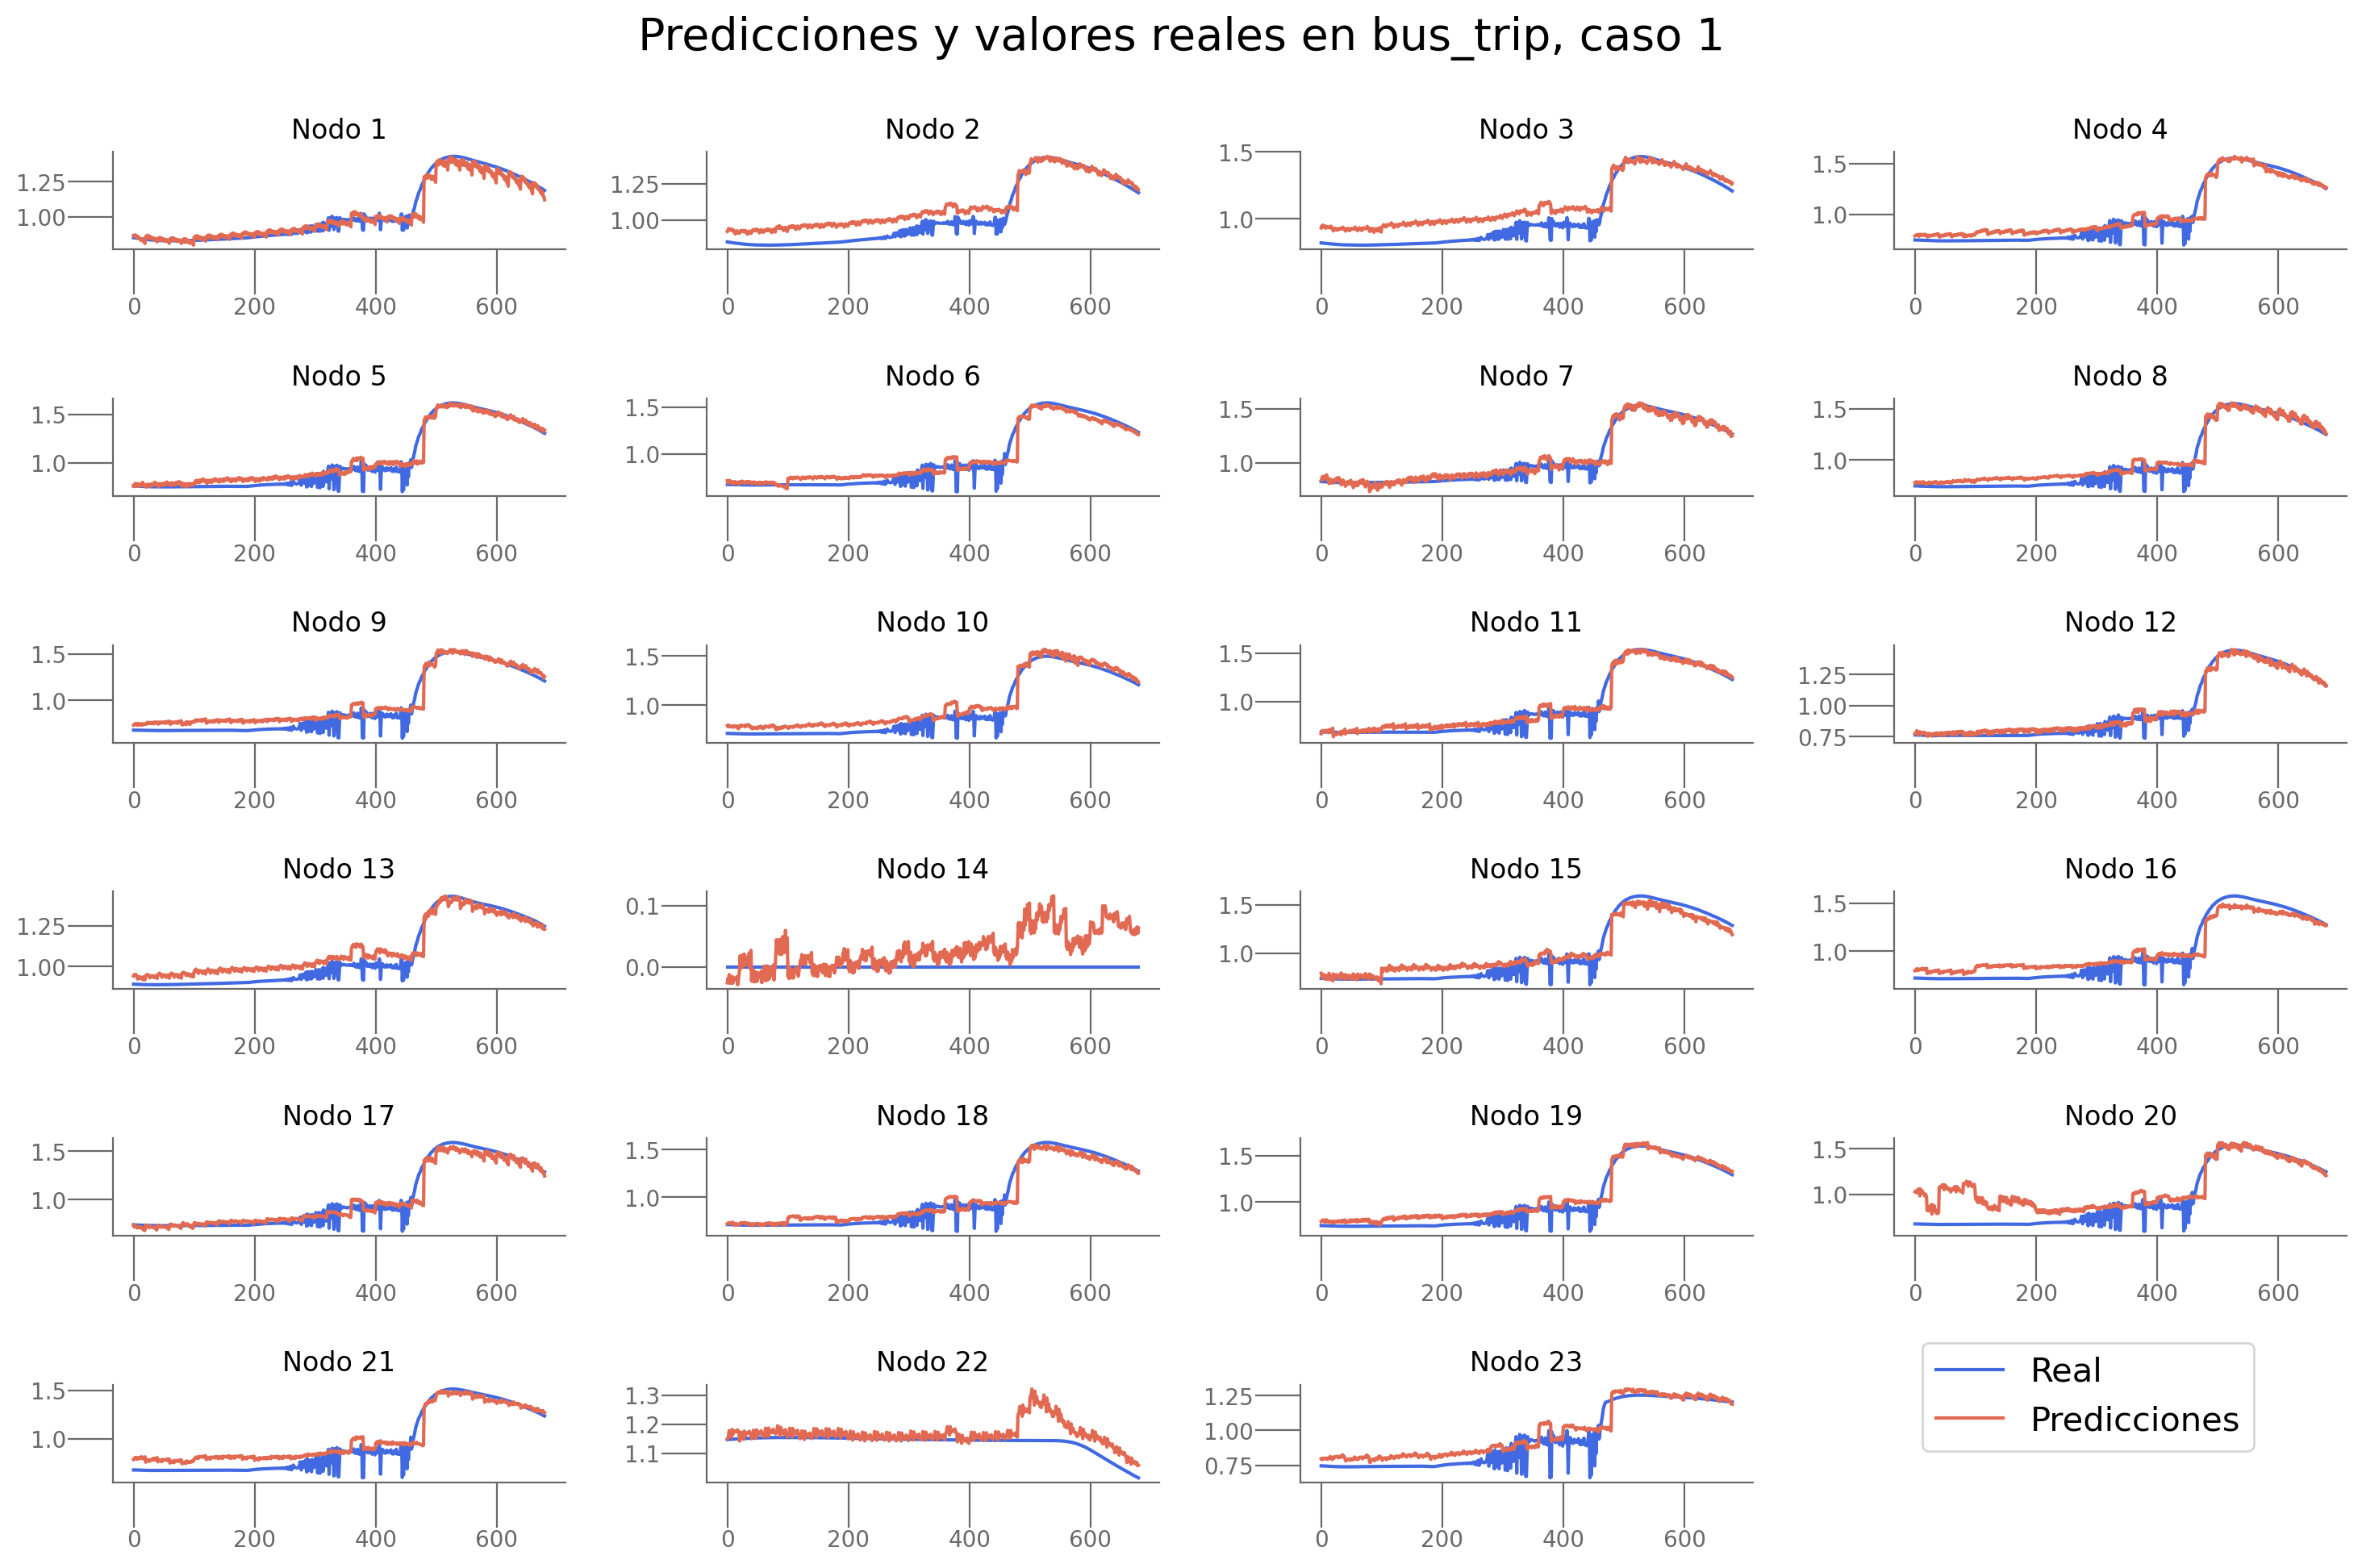

In [23]:
_,_,_, predictions_bt_ajuste,real_bt_ajuste = trainer_bt.test()
plot_predictions(predictions_bt_ajuste, real_bt_ajuste, n_target, 1, n_div_bt, problem_bt)

In [21]:
trainer_bt.save_model(path_save_experiment=path_save_experiment_bt, params = params_bt)


==================== GUARDANDO RESULTADOS ===================

         Modelo                                             Params  \
0          LSTM                                                NaN   
1  LSTM_NOBATCH                                                NaN   
2     MPNN_LSTM                                          (32, 0.8)   
3   DyGrEncoder              {'aggr': 'add', 'conv': 1, 'lstm': 1}   
4         DCRNN                                     {'hidden': 60}   
5     EvolveGCN                                                NaN   
6        ASTGCN  {'nb_block': 1, 'nb_chev_filter': 2, 'nb_time_...   
7         AGCRN            {'hidden': 10, 'K': 10, 'embedding': 3}   

                      Fichero_resultados_experimento  Loss_tst    R2_tst  \
0                                                NaN  0.005474  0.923150   
1                                                NaN  0.005606  0.865487   
2    ./results/bus_trip/ajustes/MPNNLSTM_results.csv  0.006753  0.845855   
3

### Bus fault

In [7]:
problem_bf = "bus_fault"
dataset_bf, situations_bf = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem_bf)




Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  86


In [8]:

n_div_bf = loader.div
n_nodes =dataset_bf.features[0].shape[0]
n_target = dataset_bf.targets[0].shape[1]
n_features = dataset_bf[0].x.shape[1]
embedding_dim =5

#### Sencilla 

In [9]:
model_bf = AGCRNModel(n_features=n_features, n_nodes=n_nodes, embedding_dim=embedding_dim, hidden_size=n_nodes, n_target=n_target, name="AGCRN")
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

model_bf.to(device)
trainer_bf = TrainerAGCRN(model_bf, dataset_bf,device, f"./results/{problem_bf}", dataloader_params2)

losses,eval_losses, r2scores  = trainer_bf.train(num_epochs=num_epochs, steps=200, num_early_stop=num_early_stop)




==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoader for train set:
Number of batches: 401
DataLoader for val set:
Number of batches: 88
DataLoader for test set:
Number of batches: 88

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.1304 | Eval Loss: 0.0582 | Eval R2: -0.4831 | LR: 0.0010 | 
Epoch 2/30 | Train Loss: 0.0390 | Eval Loss: 0.0427 | Eval R2: 0.1271 | LR: 0.0010 | 
Epoch 3/30 | Train Loss: 0.0316 | Eval Loss: 0.0367 | Eval R2: 0.2959 | LR: 0.0010 | 
Epoch 4/30 | Train Loss: 0.0288 | Eval Loss: 0.0343 | Eval R2: 0.3385 | LR: 0.0010 | 
Epoch 5/30 | Train Loss: 0.0269 | Eval Loss: 0.0335 | Eval R2: 0.3316 | LR: 0.0010 | 
Epoch 6/30 | Train Loss: 0.0258 | Eval Loss: 0.0326 | Eval R2: 0.3533 | LR: 0.0010 | 
Epoch 7/30 | Train Loss: 0.0247 | Eval Loss: 0.0311 | Eval R2: 0.4063 | LR: 0.0010 | 
Epoch 8/30 | Train Loss:

KeyboardInterrupt: 

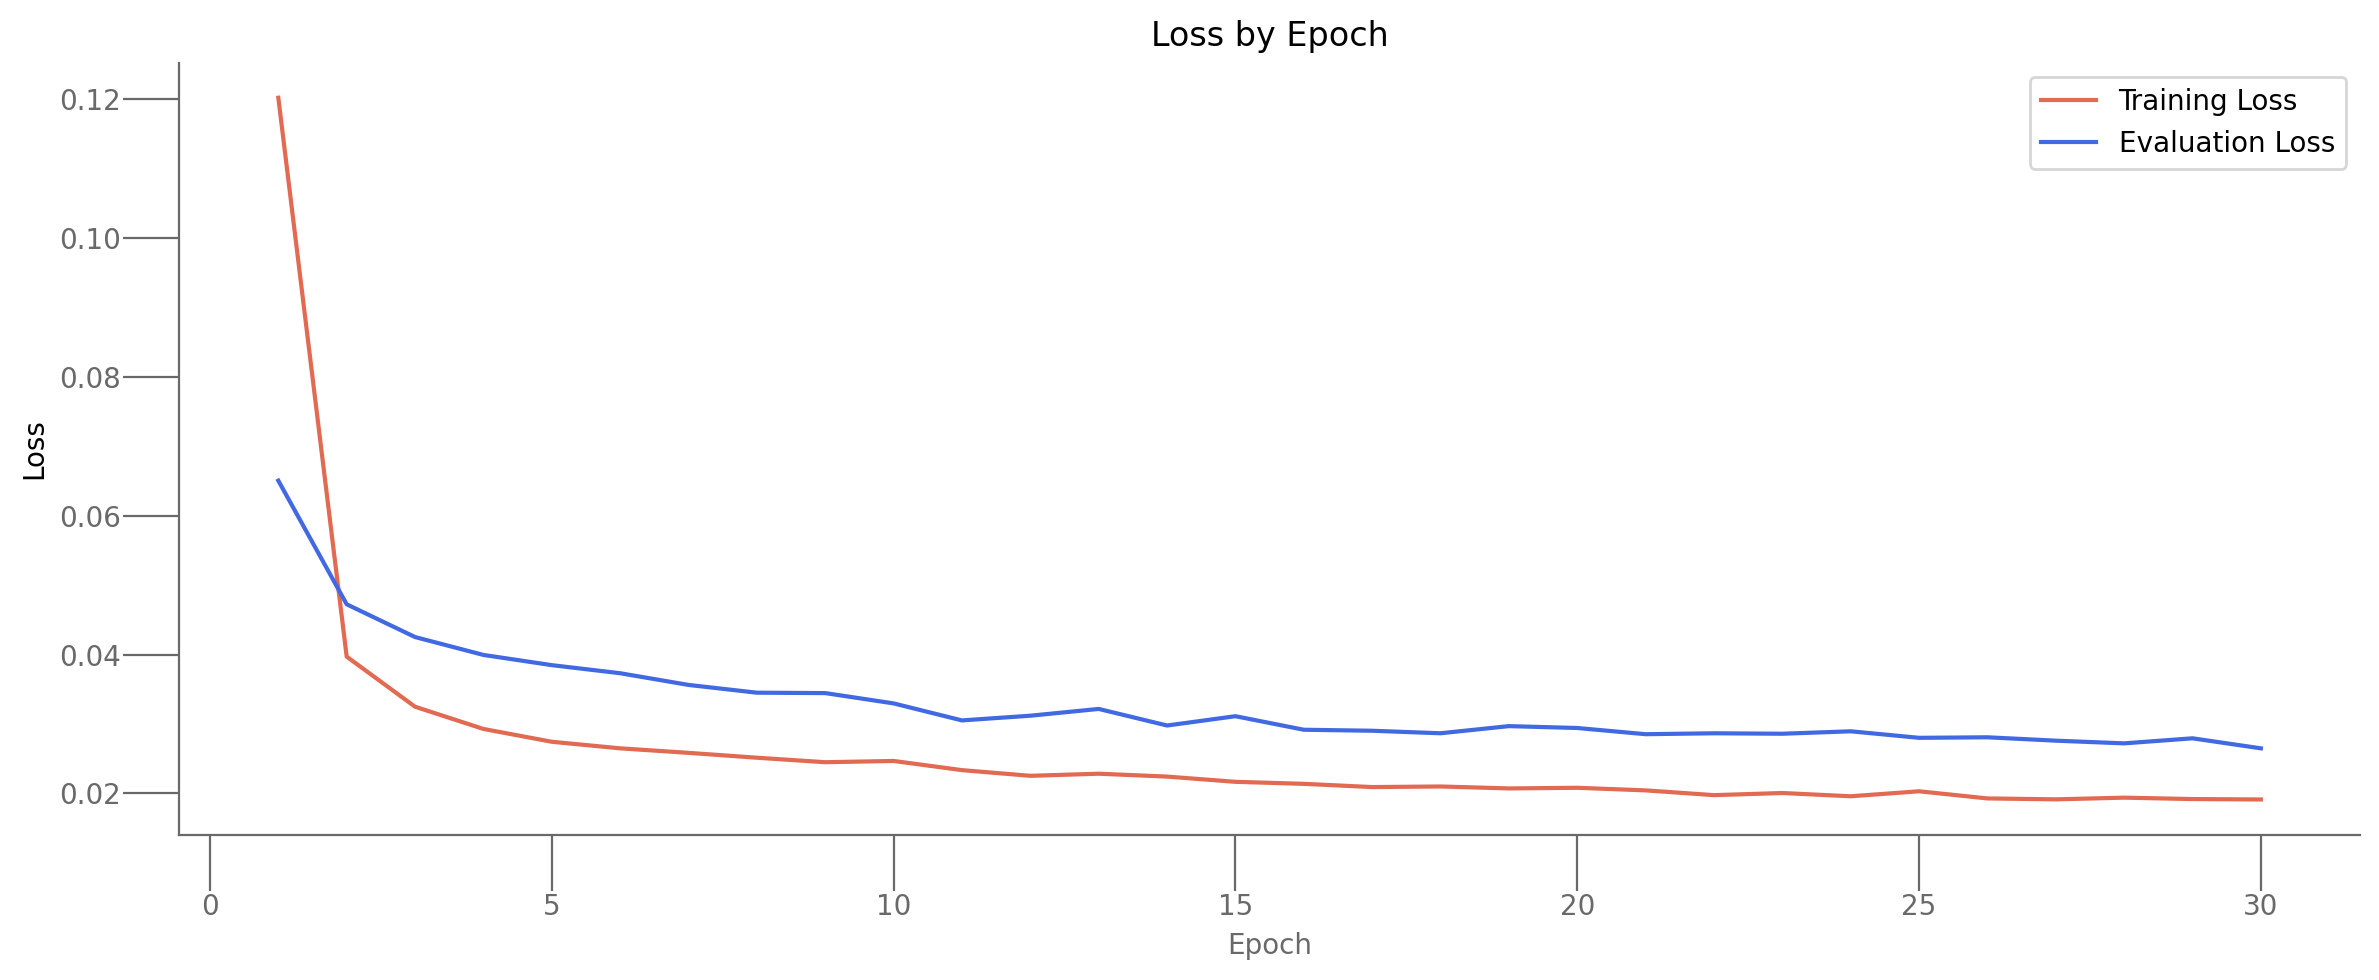


==================== TEST INFO ===================

preds:  (5, 23, 20)
test loss: 0.021107, test r2score 0.318805


In [66]:
plot_training_and_eval_losses(np.array(losses), np.array(eval_losses), num_epochs, format_plot)
losses_tst, r2score_tst, loss_nodes, predictions_bf, real_bf = trainer_bf.test()



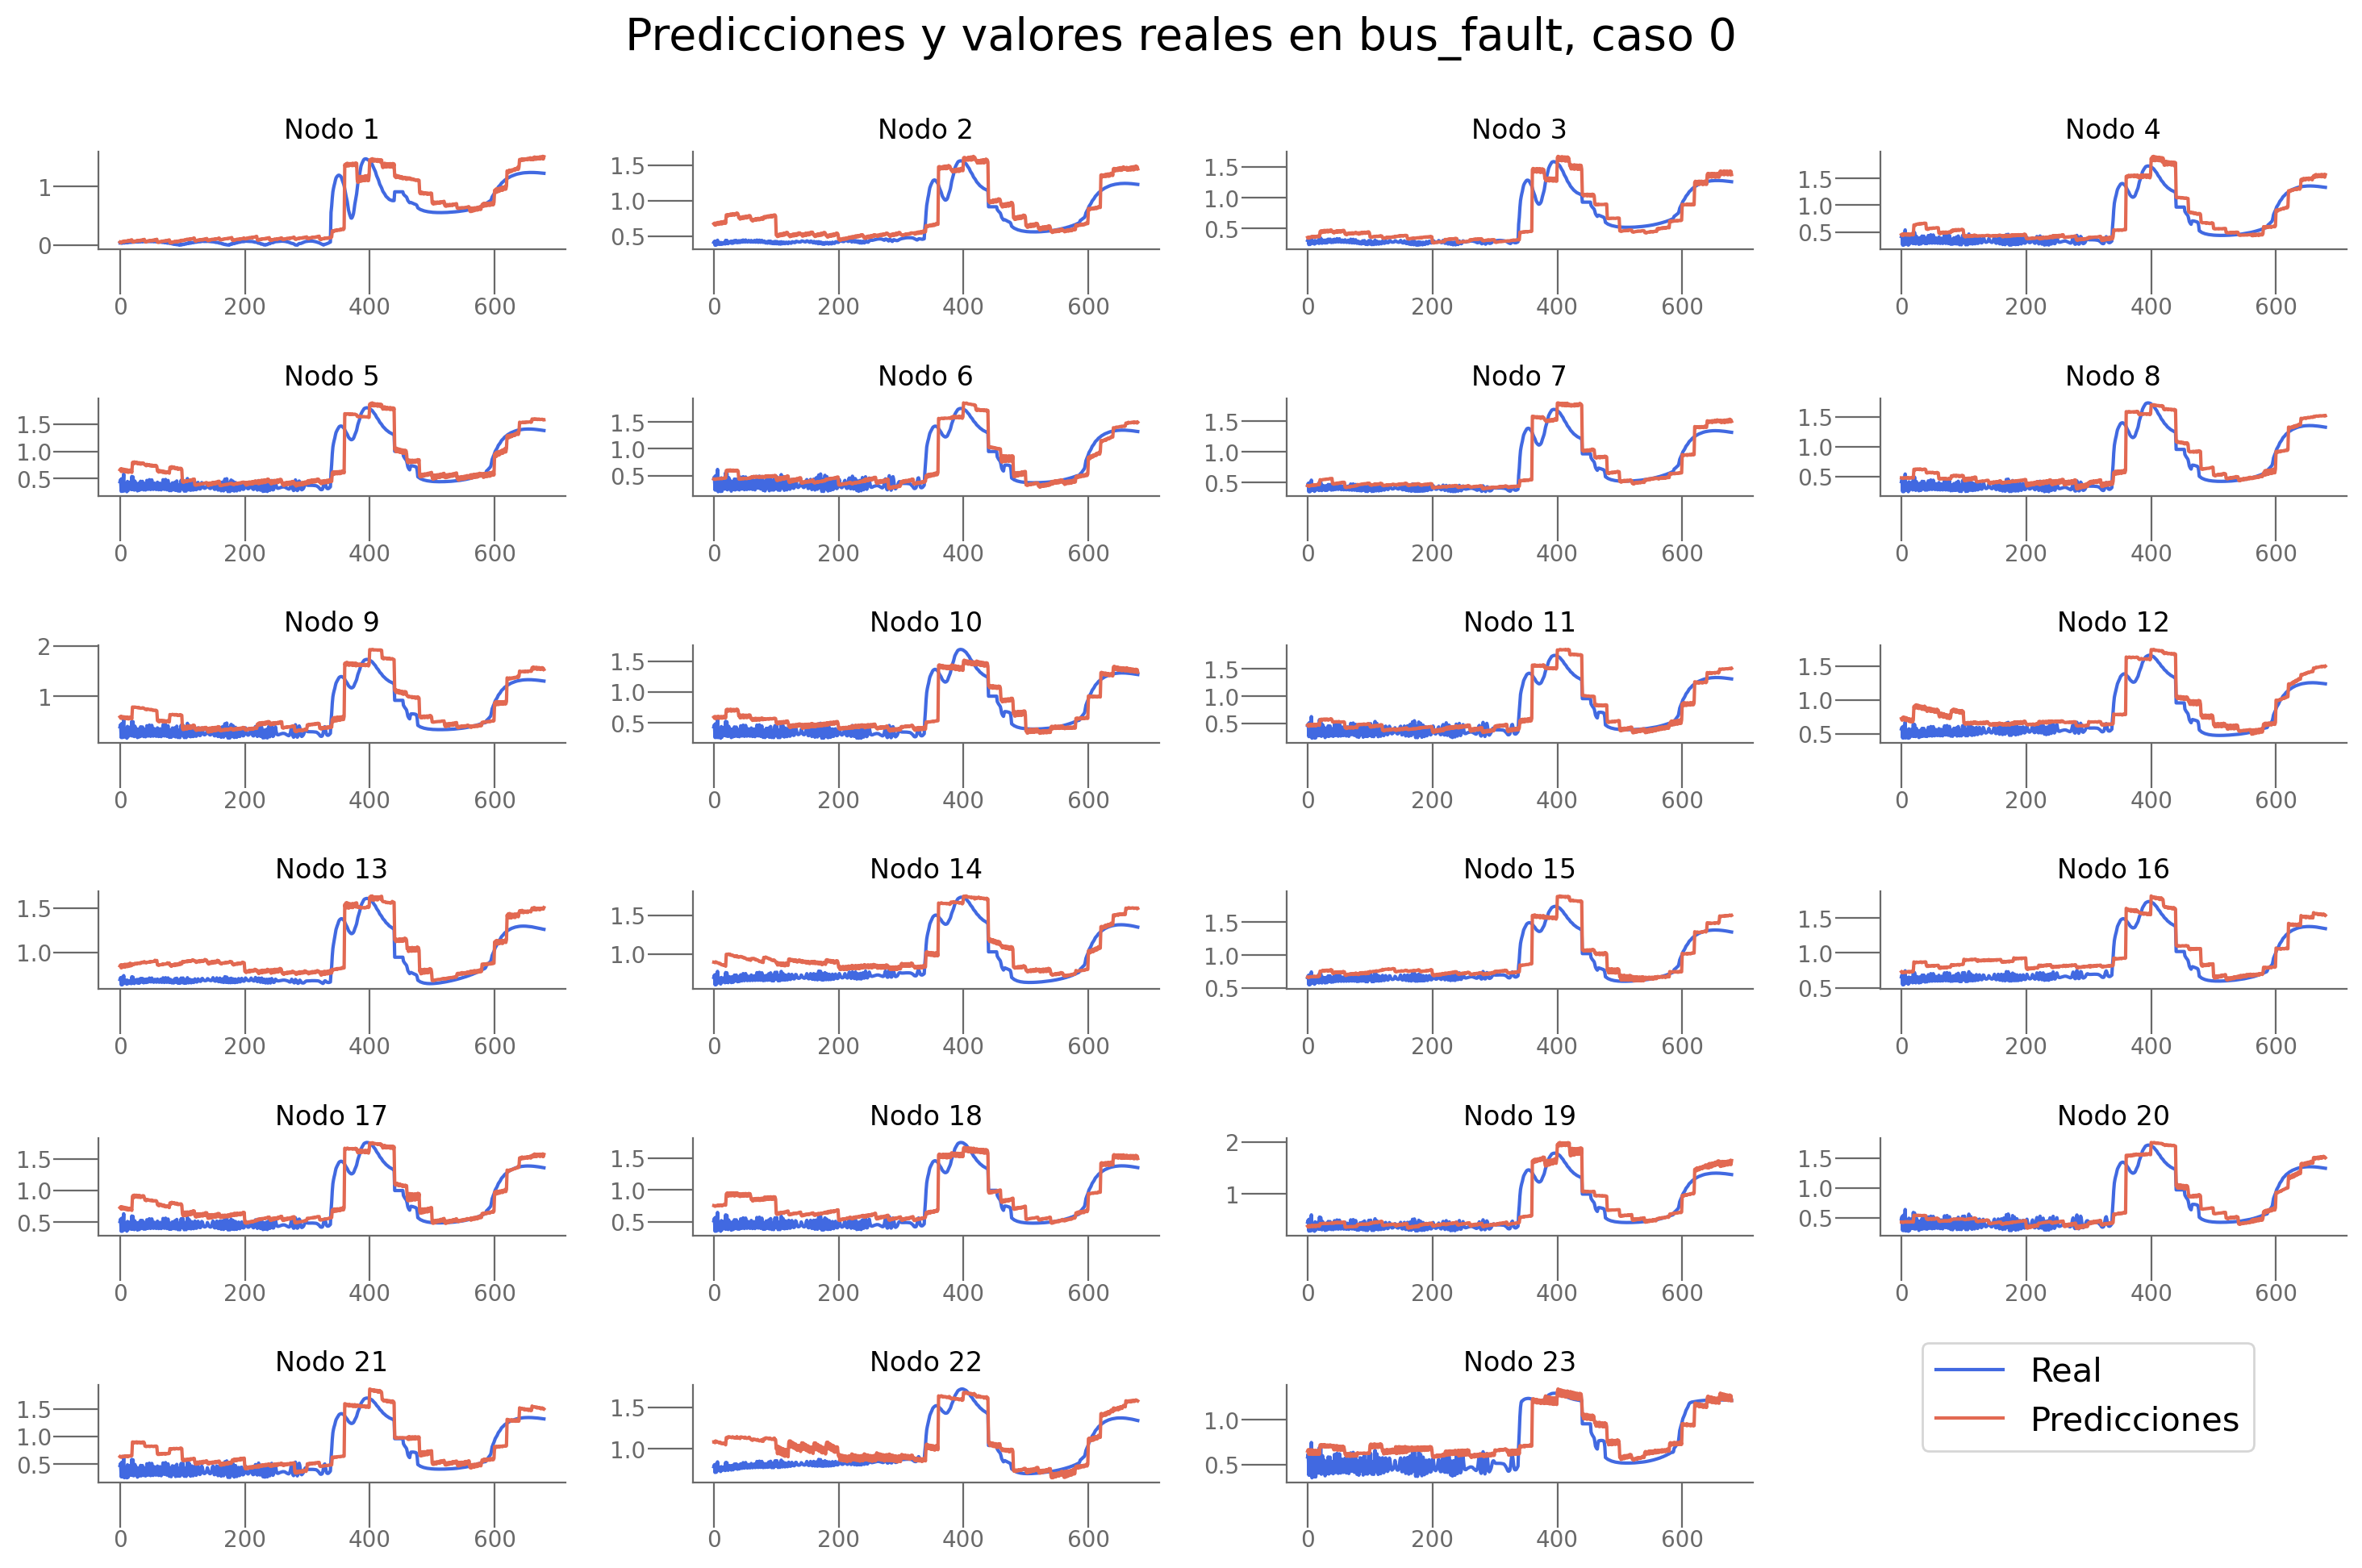

In [67]:
plot_predictions(predictions_bf, real_bf, n_target, 0, n_div_bf, problem_bf)

#### Ajuste de parámetros

In [24]:


trainer_bf,params_bf, resultados_final_bf, resultados_bf = entrenar_y_evaluar_modelos(param_grid, dataset_bf, dataloader_params2, num_early_stop=num_early_stop, num_epochs=num_epochs, problem=problem_bf)

  0%|          | 0/48 [00:00<?, ?it/s]


==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoader for train set:
Number of batches: 401
DataLoader for val set:
Number of batches: 88
DataLoader for test set:
Number of batches: 88

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.2042 | Eval Loss: 0.0912 | Eval R2: -2.3399 | LR: 0.0010 | 
Epoch 2/30 | Train Loss: 0.0630 | Eval Loss: 0.0588 | Eval R2: -0.6411 | LR: 0.0010 | 
Epoch 3/30 | Train Loss: 0.0464 | Eval Loss: 0.0471 | Eval R2: -0.1871 | LR: 0.0010 | 
Epoch 4/30 | Train Loss: 0.0392 | Eval Loss: 0.0434 | Eval R2: -0.1147 | LR: 0.0010 | 
Epoch 5/30 | Train Loss: 0.0346 | Eval Loss: 0.0392 | Eval R2: 0.0618 | LR: 0.0010 | 
Epoch 6/30 | Train Loss: 0.0322 | Eval Loss: 0.0369 | Eval R2: 0.1598 | LR: 0.0010 | 
Epoch 7/30 | Train Loss: 0.0305 | Eval Loss: 0.0353 | Eval R2: 0.2262 | LR: 0.0010 | 
Epoch 8/30 | Train Lo

  2%|▏         | 1/48 [03:25<2:40:39, 205.09s/it]

preds:  (5, 23, 20)
test loss: 0.021063, test R2 score: 0.187448
Parámetros:  10 2 3
Resultados:  {'Embedding': 3, 'k': 2, 'Hidden': 10, 'Loss_final': 0.02073092944920063, 'R2_eval': 0.5269676446914673, 'Loss_eval': 0.02645576000213623, 'R2_tst': 0.18744806164450925, 'Loss_tst': 0.021062610670924187, 'Loss_nodes': [0.013592889532446861, 0.011880671605467796, 0.014633354730904102, 0.019940698519349098, 0.02651485987007618, 0.02480468712747097, 0.021907849237322807, 0.02155132032930851, 0.027243750169873238, 0.02153072878718376, 0.04701412096619606, 0.01554170623421669, 0.009880178608000278, 0.013556129299104214, 0.02230205200612545, 0.019736599177122116, 0.025192515924572945, 0.02128947526216507, 0.02568601444363594, 0.024930495768785477, 0.024752028286457062, 0.011411604471504688, 0.019546272233128548]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoad

  4%|▍         | 2/48 [06:51<2:37:49, 205.86s/it]

preds:  (5, 23, 20)
test loss: 0.025922, test R2 score: -0.050155
Parámetros:  10 3 3
Resultados:  {'Embedding': 3, 'k': 3, 'Hidden': 10, 'Loss_final': 0.023048829287290573, 'R2_eval': 0.3687343895435333, 'Loss_eval': 0.03164328262209892, 'R2_tst': -0.050154995411182644, 'Loss_tst': 0.02592175453901291, 'Loss_nodes': [0.01825679838657379, 0.016827791929244995, 0.029729293659329414, 0.02601333148777485, 0.05629833787679672, 0.02486424520611763, 0.026939215138554573, 0.01944379135966301, 0.03177754208445549, 0.0273627620190382, 0.032802995294332504, 0.017850549891591072, 0.01712164841592312, 0.022349467501044273, 0.022396966814994812, 0.030901731923222542, 0.0223078690469265, 0.02737615816295147, 0.030130429193377495, 0.025309650227427483, 0.03435404598712921, 0.014481265097856522, 0.021304504945874214]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoade

  6%|▋         | 3/48 [10:22<2:36:18, 208.40s/it]

preds:  (5, 23, 20)
test loss: 0.030928, test R2 score: -0.660355
Parámetros:  10 4 3
Resultados:  {'Embedding': 3, 'k': 4, 'Hidden': 10, 'Loss_final': 0.02582395263016224, 'R2_eval': 0.18818803131580353, 'Loss_eval': 0.037207119166851044, 'R2_tst': -0.6603553691602492, 'Loss_tst': 0.03092753328382969, 'Loss_nodes': [0.02076089382171631, 0.018663322553038597, 0.03170733526349068, 0.023546040058135986, 0.11435814201831818, 0.02891499549150467, 0.030269872397184372, 0.03399930149316788, 0.03126850724220276, 0.02647600695490837, 0.02872028946876526, 0.024662399664521217, 0.010497699491679668, 0.02428569830954075, 0.021583380177617073, 0.022962726652622223, 0.03917449712753296, 0.04352819547057152, 0.028392095118761063, 0.0347411073744297, 0.03081047348678112, 0.01991933211684227, 0.022091031074523926]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoader f

  8%|▊         | 4/48 [13:17<2:23:08, 195.20s/it]

preds:  (5, 23, 20)
test loss: 0.022844, test R2 score: -0.021246
Parámetros:  20 2 3
Resultados:  {'Embedding': 3, 'k': 2, 'Hidden': 20, 'Loss_final': 0.019023949280381203, 'R2_eval': 0.4848829209804535, 'Loss_eval': 0.027182389050722122, 'R2_tst': -0.021246019070263564, 'Loss_tst': 0.022843850776553154, 'Loss_nodes': [0.016435304656624794, 0.011885001324117184, 0.019323961809277534, 0.022482341155409813, 0.03295949101448059, 0.026765502989292145, 0.020176909863948822, 0.02842305228114128, 0.02756980061531067, 0.02289196290075779, 0.023111797869205475, 0.015409075655043125, 0.009946225211024284, 0.01409572921693325, 0.025990407913923264, 0.026621704921126366, 0.03625655174255371, 0.026126064360141754, 0.022833114489912987, 0.026108557358384132, 0.02900618128478527, 0.022821946069598198, 0.018167870119214058]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================

D

 10%|█         | 5/48 [16:48<2:23:48, 200.67s/it]

preds:  (5, 23, 20)
test loss: 0.025788, test R2 score: -0.083580
Parámetros:  20 3 3
Resultados:  {'Embedding': 3, 'k': 3, 'Hidden': 20, 'Loss_final': 0.019855892285704613, 'R2_eval': 0.29069754481315613, 'Loss_eval': 0.030492909252643585, 'R2_tst': -0.08358037435872483, 'Loss_tst': 0.025787686929106712, 'Loss_nodes': [0.025879574939608574, 0.014559286646544933, 0.029066817834973335, 0.02688603289425373, 0.04013725742697716, 0.027241986244916916, 0.02905878983438015, 0.023832004517316818, 0.030959391966462135, 0.022984765470027924, 0.028751535341143608, 0.018219750374555588, 0.016355391591787338, 0.018333079293370247, 0.032415226101875305, 0.02233218215405941, 0.023509694263339043, 0.0424664244055748, 0.026217607781291008, 0.025608830153942108, 0.03248004615306854, 0.013565552420914173, 0.022255510091781616]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================

D

 12%|█▎        | 6/48 [20:31<2:25:54, 208.45s/it]

preds:  (5, 23, 20)
test loss: 0.027719, test R2 score: -0.065613
Parámetros:  20 4 3
Resultados:  {'Embedding': 3, 'k': 4, 'Hidden': 20, 'Loss_final': 0.021787267178297043, 'R2_eval': 0.32437288761138916, 'Loss_eval': 0.03193645179271698, 'R2_tst': -0.0656129463142126, 'Loss_tst': 0.02771906740963459, 'Loss_nodes': [0.027172120288014412, 0.022876154631376266, 0.03810049965977669, 0.02794315665960312, 0.029750458896160126, 0.03262529522180557, 0.028262078762054443, 0.024289824068546295, 0.042975328862667084, 0.02596299536526203, 0.0317770279943943, 0.015321583487093449, 0.017659591510891914, 0.018787706270813942, 0.026835935190320015, 0.033702537417411804, 0.024720449000597, 0.024457460269331932, 0.027394454926252365, 0.03726501762866974, 0.041118260473012924, 0.015808213502168655, 0.022732364013791084]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoa

 15%|█▍        | 7/48 [24:08<2:24:18, 211.20s/it]

preds:  (5, 23, 20)
test loss: 0.027263, test R2 score: 0.012793
Parámetros:  50 2 3
Resultados:  {'Embedding': 3, 'k': 2, 'Hidden': 50, 'Loss_final': 0.01716691441833973, 'R2_eval': 0.4011645019054413, 'Loss_eval': 0.02864292450249195, 'R2_tst': 0.012792652126394233, 'Loss_tst': 0.027262967079877853, 'Loss_nodes': [0.019621629267930984, 0.014946742914617062, 0.022199461236596107, 0.02875002659857273, 0.025317663326859474, 0.035439085215330124, 0.02071204036474228, 0.024435557425022125, 0.040825799107551575, 0.024929778650403023, 0.027065914124250412, 0.016040585935115814, 0.015160316601395607, 0.022885175421833992, 0.03578036278486252, 0.03319896012544632, 0.022122474387288094, 0.026777444407343864, 0.024982905015349388, 0.04247349873185158, 0.03985680639743805, 0.04434904828667641, 0.0191769078373909]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoa

 17%|█▋        | 8/48 [28:14<2:28:07, 222.19s/it]

preds:  (5, 23, 20)
test loss: 0.028904, test R2 score: 0.070078
Parámetros:  50 3 3
Resultados:  {'Embedding': 3, 'k': 3, 'Hidden': 50, 'Loss_final': 0.018499448895454407, 'R2_eval': 0.3002209961414337, 'Loss_eval': 0.03200085088610649, 'R2_tst': 0.07007823565304151, 'Loss_tst': 0.028904210776090622, 'Loss_nodes': [0.026663390919566154, 0.020052459090948105, 0.02959895133972168, 0.03344593942165375, 0.02716430276632309, 0.03585726395249367, 0.029129009693861008, 0.03261234983801842, 0.03836014121770859, 0.02910425141453743, 0.029319535940885544, 0.018442928791046143, 0.013957217335700989, 0.025728853419423103, 0.0366419292986393, 0.028904540464282036, 0.027544496580958366, 0.02996971644461155, 0.03342722728848457, 0.03775373473763466, 0.037105854600667953, 0.01869405061006546, 0.025318633764982224]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoader 

 19%|█▉        | 9/48 [32:41<2:33:34, 236.27s/it]

preds:  (5, 23, 20)
test loss: 0.036508, test R2 score: -0.349128
Parámetros:  50 4 3
Resultados:  {'Embedding': 3, 'k': 4, 'Hidden': 50, 'Loss_final': 0.02068152464926243, 'R2_eval': 0.015477844513952732, 'Loss_eval': 0.037897538393735886, 'R2_tst': -0.3491275369009799, 'Loss_tst': 0.03650836646556854, 'Loss_nodes': [0.03523876145482063, 0.02234295755624771, 0.022718990221619606, 0.03323625400662422, 0.043405577540397644, 0.05061179772019386, 0.05466625839471817, 0.035753246396780014, 0.04253006726503372, 0.036650869995355606, 0.041878893971443176, 0.018589463084936142, 0.018719501793384552, 0.04594935476779938, 0.05854329839348793, 0.03186959773302078, 0.02716456726193428, 0.032548144459724426, 0.042357008904218674, 0.05103340372443199, 0.042074888944625854, 0.019955532625317574, 0.031853996217250824]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoa

 21%|██        | 10/48 [37:52<2:44:10, 259.23s/it]

preds:  (5, 23, 20)
test loss: 0.026477, test R2 score: 0.094931
Parámetros:  100 2 3
Resultados:  {'Embedding': 3, 'k': 2, 'Hidden': 100, 'Loss_final': 0.017062047496438026, 'R2_eval': 0.44273442029953003, 'Loss_eval': 0.027700383216142654, 'R2_tst': 0.09493110843457958, 'Loss_tst': 0.026477450504899025, 'Loss_nodes': [0.02021986059844494, 0.014158492907881737, 0.02488362230360508, 0.03184298425912857, 0.02553710527718067, 0.03592228889465332, 0.023995762690901756, 0.023803681135177612, 0.03856854513287544, 0.02709841914474964, 0.026764623820781708, 0.01635359413921833, 0.011491816490888596, 0.01965373568236828, 0.03693188726902008, 0.02939778007566929, 0.0229467935860157, 0.026475034654140472, 0.02838105522096157, 0.040167395025491714, 0.04065961018204689, 0.02031257003545761, 0.0234147310256958]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoader f

 23%|██▎       | 11/48 [44:15<3:03:11, 297.08s/it]

preds:  (5, 23, 20)
test loss: 0.030715, test R2 score: -0.085020
Parámetros:  100 3 3
Resultados:  {'Embedding': 3, 'k': 3, 'Hidden': 100, 'Loss_final': 0.0184140894562006, 'R2_eval': 0.19034028053283691, 'Loss_eval': 0.033448755741119385, 'R2_tst': -0.08501992859815101, 'Loss_tst': 0.030715029686689377, 'Loss_nodes': [0.02399330586194992, 0.020046474412083626, 0.028665559366345406, 0.03352385014295578, 0.03897077590227127, 0.03576354682445526, 0.033541467040777206, 0.029667353257536888, 0.037227898836135864, 0.028772948309779167, 0.031841278076171875, 0.018996400758624077, 0.021413473412394524, 0.024848615750670433, 0.0337836854159832, 0.03516930714249611, 0.025382526218891144, 0.037775132805109024, 0.03416727855801582, 0.037369273602962494, 0.044401511549949646, 0.024475431069731712, 0.02664857544004917]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================

Dat

 25%|██▌       | 12/48 [51:16<3:20:58, 334.97s/it]

preds:  (5, 23, 20)
test loss: 0.035184, test R2 score: -0.358188
Parámetros:  100 4 3
Resultados:  {'Embedding': 3, 'k': 4, 'Hidden': 100, 'Loss_final': 0.021211842074990273, 'R2_eval': 0.05577046051621437, 'Loss_eval': 0.03958622366189957, 'R2_tst': -0.3581880918127325, 'Loss_tst': 0.03518426790833473, 'Loss_nodes': [0.025185473263263702, 0.01998625136911869, 0.022856809198856354, 0.03330416604876518, 0.04394790157675743, 0.04500840604305267, 0.04165680706501007, 0.05141831561923027, 0.037692468613386154, 0.031524933874607086, 0.06194929778575897, 0.02684340626001358, 0.02330086939036846, 0.02646462805569172, 0.04576630890369415, 0.033231642097234726, 0.03253054991364479, 0.03296877071261406, 0.03661029413342476, 0.04616263881325722, 0.03918692469596863, 0.02448425441980362, 0.027157150208950043]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoader f

 27%|██▋       | 13/48 [54:31<2:50:41, 292.62s/it]

preds:  (5, 23, 20)
test loss: 0.022203, test R2 score: 0.101532
Parámetros:  10 2 5
Resultados:  {'Embedding': 5, 'k': 2, 'Hidden': 10, 'Loss_final': 0.0211337823420763, 'R2_eval': 0.4480055570602417, 'Loss_eval': 0.027401871979236603, 'R2_tst': 0.10153229782683285, 'Loss_tst': 0.0222034715116024, 'Loss_nodes': [0.015237431973218918, 0.021197371184825897, 0.017711374908685684, 0.02545253001153469, 0.026373229920864105, 0.027967406436800957, 0.01935390941798687, 0.028705058619379997, 0.03383193910121918, 0.029287191107869148, 0.022544924169778824, 0.014575239270925522, 0.013081050477921963, 0.015469735488295555, 0.015996800735592842, 0.0179931428283453, 0.024976639077067375, 0.027919083833694458, 0.02218623273074627, 0.025525469332933426, 0.028138356283307076, 0.015383257530629635, 0.021772420033812523]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoa

 29%|██▉       | 14/48 [57:54<2:30:20, 265.32s/it]

preds:  (5, 23, 20)
test loss: 0.026804, test R2 score: -0.473970
Parámetros:  10 3 5
Resultados:  {'Embedding': 5, 'k': 3, 'Hidden': 10, 'Loss_final': 0.023728832602500916, 'R2_eval': 0.25524699687957764, 'Loss_eval': 0.03276361525058746, 'R2_tst': -0.47397004230160744, 'Loss_tst': 0.026803655549883842, 'Loss_nodes': [0.016933059319853783, 0.018015174195170403, 0.01586865447461605, 0.02660045586526394, 0.030120188370347023, 0.03275879845023155, 0.022585906088352203, 0.022371647879481316, 0.04213278740644455, 0.0291749220341444, 0.024117523804306984, 0.02454589679837227, 0.021603690460324287, 0.035296183079481125, 0.01735007017850876, 0.020302515476942062, 0.02319202572107315, 0.03842146322131157, 0.025320451706647873, 0.05738012492656708, 0.0343826562166214, 0.013362865895032883, 0.024647049605846405]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoad

 31%|███▏      | 15/48 [1:01:09<2:14:14, 244.07s/it]

preds:  (5, 23, 20)
test loss: 0.028676, test R2 score: -0.184678
Parámetros:  10 4 5
Resultados:  {'Embedding': 5, 'k': 4, 'Hidden': 10, 'Loss_final': 0.02794441021978855, 'R2_eval': 0.2459031492471695, 'Loss_eval': 0.03413302078843117, 'R2_tst': -0.1846782789680777, 'Loss_tst': 0.028675707057118416, 'Loss_nodes': [0.03431589528918266, 0.023831075057387352, 0.029053358361124992, 0.023539843037724495, 0.03463742136955261, 0.03806467726826668, 0.025438863784074783, 0.0327046737074852, 0.040125127881765366, 0.03262954577803612, 0.0314461924135685, 0.026435477659106255, 0.013897745870053768, 0.017221542075276375, 0.02117951400578022, 0.02331598475575447, 0.02982795052230358, 0.027959506958723068, 0.030010702088475227, 0.030913440510630608, 0.039181821048259735, 0.030272984877228737, 0.023537950590252876]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoade

 33%|███▎      | 16/48 [1:04:17<2:01:15, 227.37s/it]

preds:  (5, 23, 20)
test loss: 0.024271, test R2 score: -0.054606
Parámetros:  20 2 5
Resultados:  {'Embedding': 5, 'k': 2, 'Hidden': 20, 'Loss_final': 0.019446182996034622, 'R2_eval': 0.44492366909980774, 'Loss_eval': 0.028325475752353668, 'R2_tst': -0.054606064301702, 'Loss_tst': 0.024271292611956596, 'Loss_nodes': [0.01578710973262787, 0.019144050776958466, 0.016100719571113586, 0.02952328883111477, 0.03694523125886917, 0.028538519516587257, 0.016797011718153954, 0.028600098565220833, 0.03396551311016083, 0.030152617022395134, 0.027917928993701935, 0.020593859255313873, 0.016514373943209648, 0.019065478816628456, 0.01780792511999607, 0.021406283602118492, 0.023601742461323738, 0.02900383435189724, 0.023331772536039352, 0.028768574818968773, 0.027943052351474762, 0.02564486861228943, 0.021085944026708603]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================

Dat

 35%|███▌      | 17/48 [1:07:51<1:55:20, 223.23s/it]

preds:  (5, 23, 20)
test loss: 0.031335, test R2 score: -0.496544
Parámetros:  20 3 5
Resultados:  {'Embedding': 5, 'k': 3, 'Hidden': 20, 'Loss_final': 0.021052177995443344, 'R2_eval': 0.12919779121875763, 'Loss_eval': 0.03545115143060684, 'R2_tst': -0.49654422659962627, 'Loss_tst': 0.03133530914783478, 'Loss_nodes': [0.02016625553369522, 0.014726439490914345, 0.023361386731266975, 0.028670495375990868, 0.03440847992897034, 0.030333584174513817, 0.019435333088040352, 0.030441677197813988, 0.042341556400060654, 0.030200326815247536, 0.031069664284586906, 0.01874634437263012, 0.05751359835267067, 0.03144197538495064, 0.04255581274628639, 0.051363859325647354, 0.031304534524679184, 0.03194760903716087, 0.034457311034202576, 0.03224606812000275, 0.03814693167805672, 0.021911093965172768, 0.0239217821508646]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoa

 38%|███▊      | 18/48 [1:11:37<1:52:00, 224.00s/it]

preds:  (5, 23, 20)
test loss: 0.028703, test R2 score: -0.082274
Parámetros:  20 4 5
Resultados:  {'Embedding': 5, 'k': 4, 'Hidden': 20, 'Loss_final': 0.023676255717873573, 'R2_eval': 0.14465874433517456, 'Loss_eval': 0.03563202917575836, 'R2_tst': -0.08227445098380075, 'Loss_tst': 0.028702817857265472, 'Loss_nodes': [0.0336507149040699, 0.0173416156321764, 0.04480766877532005, 0.026029866188764572, 0.03619655221700668, 0.030195051804184914, 0.020085906609892845, 0.03164255991578102, 0.034626562148332596, 0.026913590729236603, 0.027990924194455147, 0.019446082413196564, 0.0180461835116148, 0.025439225137233734, 0.025002561509609222, 0.023861028254032135, 0.029718833044171333, 0.03412666171789169, 0.03122548945248127, 0.03394053131341934, 0.03298444300889969, 0.034652892500162125, 0.022239793092012405]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoad

 40%|███▉      | 19/48 [1:15:02<1:45:33, 218.41s/it]

preds:  (5, 23, 20)
test loss: 0.026357, test R2 score: 0.034347
Parámetros:  50 2 5
Resultados:  {'Embedding': 5, 'k': 2, 'Hidden': 50, 'Loss_final': 0.017734255641698837, 'R2_eval': 0.36563435196876526, 'Loss_eval': 0.029259227216243744, 'R2_tst': 0.034346721496633356, 'Loss_tst': 0.026357144117355347, 'Loss_nodes': [0.023245591670274734, 0.01839650794863701, 0.020774871110916138, 0.025673169642686844, 0.03580455854535103, 0.031997378915548325, 0.023533590137958527, 0.02825581468641758, 0.03895431011915207, 0.027937965467572212, 0.026523906737565994, 0.022796614095568657, 0.02181791327893734, 0.01970398984849453, 0.02152245119214058, 0.022185035049915314, 0.029666423797607422, 0.03128647431731224, 0.02474118396639824, 0.030605075880885124, 0.030115468427538872, 0.027951641008257866, 0.022724367678165436]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================

Data

 42%|████▏     | 20/48 [1:19:15<1:46:44, 228.72s/it]

preds:  (5, 23, 20)
test loss: 0.038682, test R2 score: -0.920791
Parámetros:  50 3 5
Resultados:  {'Embedding': 5, 'k': 3, 'Hidden': 50, 'Loss_final': 0.020358065143227577, 'R2_eval': -0.08028696477413177, 'Loss_eval': 0.03964931145310402, 'R2_tst': -0.9207911221166672, 'Loss_tst': 0.038682326674461365, 'Loss_nodes': [0.03757389262318611, 0.06451824307441711, 0.03563191741704941, 0.03563756123185158, 0.039103299379348755, 0.04165826737880707, 0.024135297164320946, 0.03816569223999977, 0.049627840518951416, 0.03774666413664818, 0.03465656563639641, 0.0281978826969862, 0.023415882140398026, 0.03182694688439369, 0.02478821761906147, 0.07026304304599762, 0.03850304335355759, 0.052748288959264755, 0.030949614942073822, 0.03519758954644203, 0.0520513541996479, 0.03573262318968773, 0.02756384201347828]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoader for

 44%|████▍     | 21/48 [1:24:14<1:52:27, 249.92s/it]

preds:  (5, 23, 20)
test loss: 0.035733, test R2 score: -0.957594
Parámetros:  50 4 5
Resultados:  {'Embedding': 5, 'k': 4, 'Hidden': 50, 'Loss_final': 0.02338300086557865, 'R2_eval': -0.0067454115487635136, 'Loss_eval': 0.041457608342170715, 'R2_tst': -0.9575941298831936, 'Loss_tst': 0.03573305904865265, 'Loss_nodes': [0.020484715700149536, 0.023566395044326782, 0.04649503156542778, 0.030944092199206352, 0.038820017129182816, 0.040592264384031296, 0.04487021639943123, 0.03335622325539589, 0.04373463988304138, 0.050988636910915375, 0.03221973776817322, 0.02807139791548252, 0.046628858894109726, 0.023138411343097687, 0.026323527097702026, 0.03860935568809509, 0.03744896128773689, 0.0492902509868145, 0.04241477698087692, 0.03589482232928276, 0.03118966706097126, 0.03385312855243683, 0.022925281897187233]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoad

 46%|████▌     | 22/48 [1:29:31<1:56:58, 269.95s/it]

preds:  (5, 23, 20)
test loss: 0.028328, test R2 score: -0.197535
Parámetros:  100 2 5
Resultados:  {'Embedding': 5, 'k': 2, 'Hidden': 100, 'Loss_final': 0.018269438296556473, 'R2_eval': 0.25341111421585083, 'Loss_eval': 0.03221578896045685, 'R2_tst': -0.19753478441281078, 'Loss_tst': 0.028328178450465202, 'Loss_nodes': [0.019325274974107742, 0.03453052416443825, 0.02801026590168476, 0.028764283284544945, 0.03385593742132187, 0.030797641724348068, 0.021690839901566505, 0.028259331360459328, 0.039535511285066605, 0.0361151285469532, 0.030004264786839485, 0.021342845633625984, 0.02279702015221119, 0.020668262615799904, 0.020788757130503654, 0.0262159276753664, 0.028194595128297806, 0.037495557218790054, 0.02704637497663498, 0.03158973157405853, 0.03773477301001549, 0.020673923194408417, 0.02611129730939865]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================

DataL

 48%|████▊     | 23/48 [1:35:18<2:02:07, 293.09s/it]

preds:  (5, 23, 20)
test loss: 0.033219, test R2 score: -0.308387
Parámetros:  100 3 5
Resultados:  {'Embedding': 5, 'k': 3, 'Hidden': 100, 'Loss_final': 0.020324982702732086, 'R2_eval': 0.06381237506866455, 'Loss_eval': 0.0378301702439785, 'R2_tst': -0.3083867285520853, 'Loss_tst': 0.03321894630789757, 'Loss_nodes': [0.026321373879909515, 0.029001420363783836, 0.02639325149357319, 0.030334116891026497, 0.03216841444373131, 0.03538581356406212, 0.03523165360093117, 0.032752878963947296, 0.04135927930474281, 0.031683724373579025, 0.0373154953122139, 0.032448019832372665, 0.02843223698437214, 0.03196146339178085, 0.02839619107544422, 0.03598421439528465, 0.0354485809803009, 0.04071623459458351, 0.03386629372835159, 0.03220221772789955, 0.04340199753642082, 0.025492386892437935, 0.037738557904958725]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoader fo

 50%|█████     | 24/48 [1:42:11<2:11:36, 329.02s/it]

preds:  (5, 23, 20)
test loss: 0.033525, test R2 score: -0.241986
Parámetros:  100 4 5
Resultados:  {'Embedding': 5, 'k': 4, 'Hidden': 100, 'Loss_final': 0.022458646446466446, 'R2_eval': -0.14770203828811646, 'Loss_eval': 0.04204520955681801, 'R2_tst': -0.24198637470769066, 'Loss_tst': 0.03352489694952965, 'Loss_nodes': [0.028751559555530548, 0.022199513390660286, 0.04015974700450897, 0.036085326224565506, 0.040173016488552094, 0.0427725650370121, 0.027158068493008614, 0.031451378017663956, 0.04399104788899422, 0.03593002259731293, 0.03706563264131546, 0.04332295432686806, 0.01937609724700451, 0.03145522251725197, 0.030022215098142624, 0.027356477454304695, 0.0328429751098156, 0.032297734171152115, 0.035894062370061874, 0.036376528441905975, 0.032758161425590515, 0.03821760043501854, 0.025414707139134407]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================

DataL

 52%|█████▏    | 25/48 [1:45:24<1:50:33, 288.41s/it]

preds:  (5, 23, 20)
test loss: 0.026697, test R2 score: -0.082198
Parámetros:  10 2 10
Resultados:  {'Embedding': 10, 'k': 2, 'Hidden': 10, 'Loss_final': 0.022577589377760887, 'R2_eval': 0.31791621446609497, 'Loss_eval': 0.03111758641898632, 'R2_tst': -0.08219757309578575, 'Loss_tst': 0.02669704146683216, 'Loss_nodes': [0.018092704936861992, 0.014630046673119068, 0.02838803082704544, 0.024136843159794807, 0.03716176748275757, 0.029312890022993088, 0.024790406227111816, 0.023172814399003983, 0.03270668163895607, 0.025882869958877563, 0.02696600742638111, 0.0184506606310606, 0.009850109927356243, 0.030778098851442337, 0.021361133083701134, 0.029966263100504875, 0.0367094986140728, 0.023441793397068977, 0.03294656425714493, 0.027672838419675827, 0.02978610433638096, 0.03308995068073273, 0.03473791852593422]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================

DataLo

 54%|█████▍    | 26/48 [1:48:36<1:35:07, 259.42s/it]

preds:  (5, 23, 20)
test loss: 0.033665, test R2 score: -0.598000
Parámetros:  10 3 10
Resultados:  {'Embedding': 10, 'k': 3, 'Hidden': 10, 'Loss_final': 0.02564389258623123, 'R2_eval': 0.06758183985948563, 'Loss_eval': 0.03735480457544327, 'R2_tst': -0.5979999065850048, 'Loss_tst': 0.03366544842720032, 'Loss_nodes': [0.02080482989549637, 0.04682502895593643, 0.03878088295459747, 0.03593025729060173, 0.04320584610104561, 0.038895491510629654, 0.030690085142850876, 0.02912461757659912, 0.04203137010335922, 0.02633199281990528, 0.03093387559056282, 0.018036263063549995, 0.016881151124835014, 0.026101093739271164, 0.02251567505300045, 0.028728507459163666, 0.03818463906645775, 0.03211304917931557, 0.042484596371650696, 0.06445595622062683, 0.03643958643078804, 0.036964051425457, 0.027846504002809525]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoader fo

 56%|█████▋    | 27/48 [1:52:01<1:25:07, 243.22s/it]

preds:  (5, 23, 20)
test loss: 0.032746, test R2 score: -0.225026
Parámetros:  10 4 10
Resultados:  {'Embedding': 10, 'k': 4, 'Hidden': 10, 'Loss_final': 0.027905946597456932, 'R2_eval': 0.036328867077827454, 'Loss_eval': 0.04068336263298988, 'R2_tst': -0.22502555934270962, 'Loss_tst': 0.032746437937021255, 'Loss_nodes': [0.04187465086579323, 0.03246338292956352, 0.028346693143248558, 0.024868495762348175, 0.033868465572595596, 0.03605334460735321, 0.047402385622262955, 0.02807554416358471, 0.03619861230254173, 0.0259329155087471, 0.031494174152612686, 0.019890688359737396, 0.015302930027246475, 0.024963654577732086, 0.028530072420835495, 0.032735440880060196, 0.028180986642837524, 0.033321380615234375, 0.05320209637284279, 0.03715348616242409, 0.04054807871580124, 0.019327642396092415, 0.053432974964380264]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================

Da

 58%|█████▊    | 28/48 [1:55:13<1:15:51, 227.58s/it]

preds:  (5, 23, 20)
test loss: 0.037590, test R2 score: -1.044038
Parámetros:  20 2 10
Resultados:  {'Embedding': 10, 'k': 2, 'Hidden': 20, 'Loss_final': 0.02150234766304493, 'R2_eval': -0.12564413249492645, 'Loss_eval': 0.04168694093823433, 'R2_tst': -1.044037798471492, 'Loss_tst': 0.03758978471159935, 'Loss_nodes': [0.015063253231346607, 0.01672414131462574, 0.01934780366718769, 0.022790610790252686, 0.034499719738960266, 0.04114774242043495, 0.030873041599988937, 0.03686019405722618, 0.03064904361963272, 0.025916559621691704, 0.03911295905709267, 0.08622310310602188, 0.012031996622681618, 0.08104078471660614, 0.041212208569049835, 0.027040088549256325, 0.03227237984538078, 0.031169531866908073, 0.03812031447887421, 0.029874324798583984, 0.04729871824383736, 0.0686316266655922, 0.05666493996977806]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoader

 60%|██████    | 29/48 [1:58:46<1:10:44, 223.39s/it]

preds:  (5, 23, 20)
test loss: 0.033978, test R2 score: -0.528592
Parámetros:  20 3 10
Resultados:  {'Embedding': 10, 'k': 3, 'Hidden': 20, 'Loss_final': 0.025319896638393402, 'R2_eval': -0.012066805735230446, 'Loss_eval': 0.04119215905666351, 'R2_tst': -0.5285923533945867, 'Loss_tst': 0.03397795930504799, 'Loss_nodes': [0.03296148031949997, 0.0284481942653656, 0.026319585740566254, 0.04259970411658287, 0.03465469181537628, 0.041977688670158386, 0.0279044508934021, 0.04650120437145233, 0.031750746071338654, 0.03002702072262764, 0.0392640084028244, 0.029188048094511032, 0.014550050720572472, 0.033371809870004654, 0.038781922310590744, 0.022342490032315254, 0.03893716633319855, 0.03105536662042141, 0.041690289974212646, 0.036148857325315475, 0.03861795365810394, 0.02962471731007099, 0.04477563500404358]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoade

 62%|██████▎   | 30/48 [2:02:26<1:06:42, 222.36s/it]

preds:  (5, 23, 20)
test loss: 0.041959, test R2 score: -1.310107
Parámetros:  20 4 10
Resultados:  {'Embedding': 10, 'k': 4, 'Hidden': 20, 'Loss_final': 0.026376252993941307, 'R2_eval': -0.4809575378894806, 'Loss_eval': 0.04760851711034775, 'R2_tst': -1.3101072979448185, 'Loss_tst': 0.04195882007479668, 'Loss_nodes': [0.035430800169706345, 0.024296479299664497, 0.04846423864364624, 0.06532429903745651, 0.055300358682870865, 0.05700458586215973, 0.034866686910390854, 0.03842825070023537, 0.03734453395009041, 0.03641363978385925, 0.0374332033097744, 0.023979725316166878, 0.014928550459444523, 0.03641533851623535, 0.050682421773672104, 0.05695962533354759, 0.04873502254486084, 0.04733889922499657, 0.05088914558291435, 0.04647298902273178, 0.04799287021160126, 0.0318235419690609, 0.03852764517068863]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoader fo

 65%|██████▍   | 31/48 [2:05:39<1:00:28, 213.46s/it]

preds:  (5, 23, 20)
test loss: 0.040908, test R2 score: -1.210327
Parámetros:  50 2 10
Resultados:  {'Embedding': 10, 'k': 2, 'Hidden': 50, 'Loss_final': 0.021561479195952415, 'R2_eval': -0.2612815499305725, 'Loss_eval': 0.04554780572652817, 'R2_tst': -1.2103273455963883, 'Loss_tst': 0.04090818017721176, 'Loss_nodes': [0.022497722879052162, 0.02508498542010784, 0.03259242698550224, 0.03922301530838013, 0.04107094928622246, 0.05489010736346245, 0.03455313667654991, 0.03723187372088432, 0.043214812874794006, 0.026245228946208954, 0.04268481209874153, 0.02070753648877144, 0.01826578564941883, 0.04292669519782066, 0.0289566982537508, 0.02677297033369541, 0.04370654374361038, 0.04628879204392433, 0.03591787815093994, 0.07564343512058258, 0.028223801404237747, 0.06958423554897308, 0.10460464656352997]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoader for 

 67%|██████▋   | 32/48 [2:09:51<1:00:02, 225.16s/it]

preds:  (5, 23, 20)
test loss: 0.037467, test R2 score: -0.508183
Parámetros:  50 3 10
Resultados:  {'Embedding': 10, 'k': 3, 'Hidden': 50, 'Loss_final': 0.02323729172348976, 'R2_eval': -0.29201507568359375, 'Loss_eval': 0.04550845921039581, 'R2_tst': -0.5081828465488316, 'Loss_tst': 0.037467315793037415, 'Loss_nodes': [0.04529699310660362, 0.02859915979206562, 0.0444803386926651, 0.04566046968102455, 0.03981046378612518, 0.04876480996608734, 0.039369530975818634, 0.03344973176717758, 0.03906549513339996, 0.03661942854523659, 0.038331419229507446, 0.020526787266135216, 0.027119386941194534, 0.03873389959335327, 0.031964533030986786, 0.04666510596871376, 0.038101281970739365, 0.055151961743831635, 0.034525156021118164, 0.032324109226465225, 0.040130212903022766, 0.03479121997952461, 0.02226673997938633]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoad

 69%|██████▉   | 33/48 [2:14:41<1:01:08, 244.60s/it]

preds:  (5, 23, 20)
test loss: 0.039058, test R2 score: -0.535476
Parámetros:  50 4 10
Resultados:  {'Embedding': 10, 'k': 4, 'Hidden': 50, 'Loss_final': 0.02476120926439762, 'R2_eval': -0.3878370523452759, 'Loss_eval': 0.047881364822387695, 'R2_tst': -0.5354758706998675, 'Loss_tst': 0.03905836120247841, 'Loss_nodes': [0.03344704210758209, 0.032999422401189804, 0.027798013761639595, 0.03411382809281349, 0.04461238160729408, 0.05369638279080391, 0.036544159054756165, 0.03800829499959946, 0.03813128545880318, 0.0540073998272419, 0.043601375073194504, 0.03835703432559967, 0.018566511571407318, 0.03476618602871895, 0.039959196001291275, 0.04060463607311249, 0.042710080742836, 0.03612719476222992, 0.04532869905233383, 0.04409045726060867, 0.057256367057561874, 0.028801454231142998, 0.03481492027640343]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoader fo

 71%|███████   | 34/48 [2:20:17<1:03:27, 271.95s/it]

preds:  (5, 23, 20)
test loss: 0.036984, test R2 score: -0.490343
Parámetros:  100 2 10
Resultados:  {'Embedding': 10, 'k': 2, 'Hidden': 100, 'Loss_final': 0.02163739874958992, 'R2_eval': -0.2991456389427185, 'Loss_eval': 0.043484292924404144, 'R2_tst': -0.49034334351478304, 'Loss_tst': 0.03698393329977989, 'Loss_nodes': [0.026745498180389404, 0.02087605744600296, 0.033852431923151016, 0.04152736812829971, 0.056124914437532425, 0.03881455212831497, 0.028867783024907112, 0.032643575221300125, 0.041183602064847946, 0.033228084444999695, 0.033606842160224915, 0.025980012491345406, 0.019331641495227814, 0.04573369398713112, 0.07002974301576614, 0.039976660162210464, 0.03156544640660286, 0.03602929413318634, 0.054395709186792374, 0.035407669842243195, 0.04398661106824875, 0.03841695562005043, 0.022306295111775398]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================

D

 73%|███████▎  | 35/48 [2:27:05<1:07:47, 312.86s/it]

preds:  (5, 23, 20)
test loss: 0.041040, test R2 score: -0.381873
Parámetros:  100 3 10
Resultados:  {'Embedding': 10, 'k': 3, 'Hidden': 100, 'Loss_final': 0.023048631846904755, 'R2_eval': -0.5355629920959473, 'Loss_eval': 0.05234053358435631, 'R2_tst': -0.3818732694891995, 'Loss_tst': 0.04104023799300194, 'Loss_nodes': [0.03168296441435814, 0.0263249259442091, 0.04602114111185074, 0.03549286350607872, 0.04441159963607788, 0.06238308176398277, 0.03651851788163185, 0.03959645330905914, 0.044059932231903076, 0.04029106721282005, 0.04449648782610893, 0.03770199418067932, 0.022960353642702103, 0.03283676132559776, 0.038516025990247726, 0.048589810729026794, 0.09261047095060349, 0.03577020764350891, 0.04079132154583931, 0.034913912415504456, 0.04458095133304596, 0.03767906874418259, 0.025695497170090675]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoader 

 75%|███████▌  | 36/48 [2:35:10<1:12:53, 364.47s/it]

preds:  (5, 23, 20)
test loss: 0.042680, test R2 score: -0.603289
Parámetros:  100 4 10
Resultados:  {'Embedding': 10, 'k': 4, 'Hidden': 100, 'Loss_final': 0.024548200890421867, 'R2_eval': -0.6941314339637756, 'Loss_eval': 0.05219452455639839, 'R2_tst': -0.6032894196311157, 'Loss_tst': 0.04268002137541771, 'Loss_nodes': [0.048549797385931015, 0.029983073472976685, 0.028516631573438644, 0.03716493025422096, 0.054390136152505875, 0.053131889551877975, 0.026493960991501808, 0.04606401547789574, 0.0384245365858078, 0.042015835642814636, 0.05522404983639717, 0.03780720755457878, 0.029996806755661964, 0.02718430571258068, 0.03635638579726219, 0.0632653757929802, 0.04046068713068962, 0.03895054757595062, 0.07023919373750687, 0.04967707768082619, 0.06530720740556717, 0.03578752651810646, 0.026649393141269684]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoade

 77%|███████▋  | 37/48 [2:38:09<56:36, 308.76s/it]  

preds:  (5, 23, 20)
test loss: 0.029609, test R2 score: -0.305855
Parámetros:  10 2 15
Resultados:  {'Embedding': 15, 'k': 2, 'Hidden': 10, 'Loss_final': 0.024443401023745537, 'R2_eval': 0.09711439907550812, 'Loss_eval': 0.03653513267636299, 'R2_tst': -0.3058550108467415, 'Loss_tst': 0.02960871532559395, 'Loss_nodes': [0.017443351447582245, 0.017634762451052666, 0.028383325785398483, 0.026977138593792915, 0.06928537786006927, 0.03986823558807373, 0.022760210558772087, 0.03150809928774834, 0.0348505824804306, 0.03441861644387245, 0.029455697163939476, 0.020092960447072983, 0.01343976054340601, 0.018269747495651245, 0.01833236962556839, 0.021988850086927414, 0.03561895713210106, 0.044398192316293716, 0.04173843935132027, 0.034998953342437744, 0.03367028385400772, 0.016415702179074287, 0.02945089526474476]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoa

 79%|███████▉  | 38/48 [2:41:33<46:13, 277.31s/it]

preds:  (5, 23, 20)
test loss: 0.043987, test R2 score: -1.637138
Parámetros:  10 3 15
Resultados:  {'Embedding': 15, 'k': 3, 'Hidden': 10, 'Loss_final': 0.0315234437584877, 'R2_eval': -0.3779957890510559, 'Loss_eval': 0.05056695640087128, 'R2_tst': -1.6371379376062505, 'Loss_tst': 0.043986909091472626, 'Loss_nodes': [0.025768060237169266, 0.035980597138404846, 0.04437152296304703, 0.034820783883333206, 0.04550245776772499, 0.03609691560268402, 0.0392192117869854, 0.04885348305106163, 0.0462893508374691, 0.033822741359472275, 0.061905454844236374, 0.07843706756830215, 0.023255616426467896, 0.058972202241420746, 0.02567833662033081, 0.054298315197229385, 0.04304547235369682, 0.03357871621847153, 0.051960621029138565, 0.06156317889690399, 0.03816519305109978, 0.059879086911678314, 0.030234569683670998]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoader

 81%|████████▏ | 39/48 [2:45:05<38:39, 257.67s/it]

preds:  (5, 23, 20)
test loss: 0.036464, test R2 score: -0.241340
Parámetros:  10 4 15
Resultados:  {'Embedding': 15, 'k': 4, 'Hidden': 10, 'Loss_final': 0.03252943232655525, 'R2_eval': -0.2101307064294815, 'Loss_eval': 0.047939516603946686, 'R2_tst': -0.24134038106627756, 'Loss_tst': 0.036463990807533264, 'Loss_nodes': [0.027688223868608475, 0.024422945454716682, 0.03561688959598541, 0.03275996446609497, 0.03999955952167511, 0.03830117732286453, 0.029572581872344017, 0.03333409130573273, 0.0424974225461483, 0.03388892486691475, 0.03876888379454613, 0.02125021442770958, 0.023709755390882492, 0.04123624786734581, 0.03567463532090187, 0.03921651840209961, 0.08669641613960266, 0.037299878895282745, 0.03377143666148186, 0.03483198583126068, 0.0393306240439415, 0.03686414659023285, 0.031939197331666946]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoader f

 83%|████████▎ | 40/48 [2:48:12<31:32, 236.62s/it]

preds:  (5, 23, 20)
test loss: 0.033323, test R2 score: -0.743417
Parámetros:  20 2 15
Resultados:  {'Embedding': 15, 'k': 2, 'Hidden': 20, 'Loss_final': 0.025014033541083336, 'R2_eval': -0.03622918203473091, 'Loss_eval': 0.041173163801431656, 'R2_tst': -0.7434174024579628, 'Loss_tst': 0.03332268074154854, 'Loss_nodes': [0.02853688783943653, 0.029162604361772537, 0.02833601087331772, 0.02971537783741951, 0.03559229150414467, 0.0441514328122139, 0.021436868235468864, 0.028729241341352463, 0.034326475113630295, 0.0652608573436737, 0.033123504370450974, 0.037611257284879684, 0.015416705049574375, 0.030319364741444588, 0.024198420345783234, 0.02036391571164131, 0.04435186833143234, 0.03972005471587181, 0.05452541261911392, 0.02975493110716343, 0.028508704155683517, 0.01694011129438877, 0.046339403837919235]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoa

 85%|████████▌ | 41/48 [2:51:46<26:49, 229.91s/it]

preds:  (5, 23, 20)
test loss: 0.061626, test R2 score: -3.104807
Parámetros:  20 3 15
Resultados:  {'Embedding': 15, 'k': 3, 'Hidden': 20, 'Loss_final': 0.0275975801050663, 'R2_eval': -0.9134724140167236, 'Loss_eval': 0.06110912933945656, 'R2_tst': -3.1048074655294475, 'Loss_tst': 0.06162615120410919, 'Loss_nodes': [0.060369111597537994, 0.04309449717402458, 0.10473643988370895, 0.09251103550195694, 0.0678565576672554, 0.03578396514058113, 0.04480968788266182, 0.039284829050302505, 0.04192535579204559, 0.042608585208654404, 0.07335516810417175, 0.05500330030918121, 0.02004428766667843, 0.04538057744503021, 0.09044957906007767, 0.08480270951986313, 0.03649521246552467, 0.14296679198741913, 0.04852676764130592, 0.04291153326630592, 0.07296641170978546, 0.07405701279640198, 0.057461950927972794]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoader for tr

 88%|████████▊ | 42/48 [2:55:13<22:17, 222.96s/it]

preds:  (5, 23, 20)
test loss: 0.038948, test R2 score: -0.902605
Parámetros:  20 4 15
Resultados:  {'Embedding': 15, 'k': 4, 'Hidden': 20, 'Loss_final': 0.03188272565603256, 'R2_eval': -0.3727099299430847, 'Loss_eval': 0.04739788547158241, 'R2_tst': -0.9026045691236071, 'Loss_tst': 0.03894753381609917, 'Loss_nodes': [0.08289754390716553, 0.03412274271249771, 0.03719384968280792, 0.03244619444012642, 0.0510595478117466, 0.04764134809374809, 0.051945555955171585, 0.028942059725522995, 0.03377506509423256, 0.039006903767585754, 0.034342214465141296, 0.02876269817352295, 0.025694845244288445, 0.032176367938518524, 0.031692638993263245, 0.029795723035931587, 0.059795066714286804, 0.03702714666724205, 0.045874085277318954, 0.04117414355278015, 0.03868797793984413, 0.02258724719285965, 0.029152309522032738]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoade

 90%|████████▉ | 43/48 [2:58:43<18:15, 219.15s/it]

preds:  (5, 23, 20)
test loss: 0.037546, test R2 score: -0.809382
Parámetros:  50 2 15
Resultados:  {'Embedding': 15, 'k': 2, 'Hidden': 50, 'Loss_final': 0.02378823421895504, 'R2_eval': -0.1713097095489502, 'Loss_eval': 0.044174179434776306, 'R2_tst': -0.8093823232987009, 'Loss_tst': 0.03754551708698273, 'Loss_nodes': [0.021372539922595024, 0.024288315325975418, 0.027248144149780273, 0.035792768001556396, 0.04911700636148453, 0.09100499004125595, 0.02673531323671341, 0.04075217247009277, 0.033421680331230164, 0.034552618861198425, 0.03584546223282814, 0.032733622938394547, 0.03066030889749527, 0.05273027345538139, 0.03207100182771683, 0.029432984068989754, 0.03693721070885658, 0.05447160825133324, 0.03394632041454315, 0.040155380964279175, 0.04298672080039978, 0.02558748610317707, 0.031702920794487]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoader 

 92%|█████████▏| 44/48 [3:03:00<15:20, 230.23s/it]

preds:  (5, 23, 20)
test loss: 0.039370, test R2 score: -0.601929
Parámetros:  50 3 15
Resultados:  {'Embedding': 15, 'k': 3, 'Hidden': 50, 'Loss_final': 0.026770461350679398, 'R2_eval': -0.40023791790008545, 'Loss_eval': 0.04913492500782013, 'R2_tst': -0.601929451402636, 'Loss_tst': 0.039370182901620865, 'Loss_nodes': [0.026476461440324783, 0.029572242870926857, 0.0422598160803318, 0.03608129173517227, 0.05106694996356964, 0.0384250171482563, 0.04134747013449669, 0.043836817145347595, 0.05436307191848755, 0.038202788680791855, 0.047944702208042145, 0.037873249500989914, 0.022637244313955307, 0.03569430112838745, 0.03528863191604614, 0.03999793529510498, 0.04892690107226372, 0.04552995041012764, 0.03490512818098068, 0.05359324440360069, 0.03806016594171524, 0.0356539823114872, 0.027776896953582764]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoader f

 94%|█████████▍| 45/48 [3:07:49<12:24, 248.01s/it]

preds:  (5, 23, 20)
test loss: 0.035251, test R2 score: -0.197242
Parámetros:  50 4 15
Resultados:  {'Embedding': 15, 'k': 4, 'Hidden': 50, 'Loss_final': 0.02757156454026699, 'R2_eval': -0.27307891845703125, 'Loss_eval': 0.0482967346906662, 'R2_tst': -0.19724222443253273, 'Loss_tst': 0.03525102511048317, 'Loss_nodes': [0.029645301401615143, 0.019268013536930084, 0.042462244629859924, 0.03678307682275772, 0.048600755631923676, 0.039596833288669586, 0.03721903637051582, 0.031036728993058205, 0.040924862027168274, 0.03478171303868294, 0.04779218137264252, 0.03327831253409386, 0.015976859256625175, 0.029236463829874992, 0.031186632812023163, 0.04669172689318657, 0.03843281790614128, 0.035200681537389755, 0.040889672935009, 0.048086848109960556, 0.03531016409397125, 0.02177932858467102, 0.026593394577503204]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoa

 96%|█████████▌| 46/48 [3:13:19<09:05, 272.69s/it]

preds:  (5, 23, 20)
test loss: 0.037275, test R2 score: -0.372471
Parámetros:  100 2 15
Resultados:  {'Embedding': 15, 'k': 2, 'Hidden': 100, 'Loss_final': 0.02267422340810299, 'R2_eval': -0.37172621488571167, 'Loss_eval': 0.044826339930295944, 'R2_tst': -0.37247128949167807, 'Loss_tst': 0.03727466240525246, 'Loss_nodes': [0.0365314707159996, 0.033879537135362625, 0.027969401329755783, 0.036701276898384094, 0.042953796684741974, 0.04595821723341942, 0.0308840274810791, 0.04190986603498459, 0.03944702073931694, 0.03699212893843651, 0.05709139257669449, 0.024526888504624367, 0.02917737327516079, 0.029242509976029396, 0.034978900104761124, 0.03928786888718605, 0.04482399672269821, 0.051818039268255234, 0.04168202728033066, 0.03623698651790619, 0.041880443692207336, 0.02371046505868435, 0.029633570462465286]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================

DataLo

 98%|█████████▊| 47/48 [3:20:36<05:22, 322.01s/it]

preds:  (5, 23, 20)
test loss: 0.050563, test R2 score: -1.073827
Parámetros:  100 3 15
Resultados:  {'Embedding': 15, 'k': 3, 'Hidden': 100, 'Loss_final': 0.025121603161096573, 'R2_eval': -0.8825733661651611, 'Loss_eval': 0.05784648284316063, 'R2_tst': -1.0738269390607087, 'Loss_tst': 0.05056323856115341, 'Loss_nodes': [0.045318152755498886, 0.04733799397945404, 0.04574216902256012, 0.10369300097227097, 0.05244004726409912, 0.043184325098991394, 0.04493091255426407, 0.04704425483942032, 0.07163672894239426, 0.034459128975868225, 0.06297246366739273, 0.05661023035645485, 0.0305626280605793, 0.0514458566904068, 0.037446651607751846, 0.048002734780311584, 0.04940927028656006, 0.05933840200304985, 0.04610062763094902, 0.050683487206697464, 0.06926167011260986, 0.032026879489421844, 0.03330680727958679]}

==================== DATASET INFO ===================

Train dataset: 2006
Validation dataset: 442
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoader 

100%|██████████| 48/48 [3:28:52<00:00, 261.09s/it]

preds:  (5, 23, 20)
test loss: 0.044515, test R2 score: -1.044975
Parámetros:  100 4 15
Resultados:  {'Embedding': 15, 'k': 4, 'Hidden': 100, 'Loss_final': 0.027418086305260658, 'R2_eval': -0.7474703192710876, 'Loss_eval': 0.058113943785429, 'R2_tst': -1.0449751222094257, 'Loss_tst': 0.04451471194624901, 'Loss_nodes': [0.031174730509519577, 0.03580203279852867, 0.03533594310283661, 0.033931758254766464, 0.040464721620082855, 0.069065622985363, 0.03702690079808235, 0.04351716861128807, 0.05660948529839516, 0.03028286248445511, 0.046076372265815735, 0.03875283896923065, 0.02762041613459587, 0.04576596990227699, 0.043693579733371735, 0.055605243891477585, 0.04970499500632286, 0.04027095437049866, 0.06826925277709961, 0.05405395105481148, 0.051685988903045654, 0.042504776269197464, 0.0466228686273098]}


In [25]:
path_save_experiment_bf = results_save_path+f"/{problem_bf}"+ f"/ajustes/{name_model}_results.csv"
resultados_bf.to_csv(path_save_experiment_bf, index=False)


==================== TEST INFO ===================

preds:  (5, 23, 20)
test loss: 0.021063, test R2 score: 0.187448


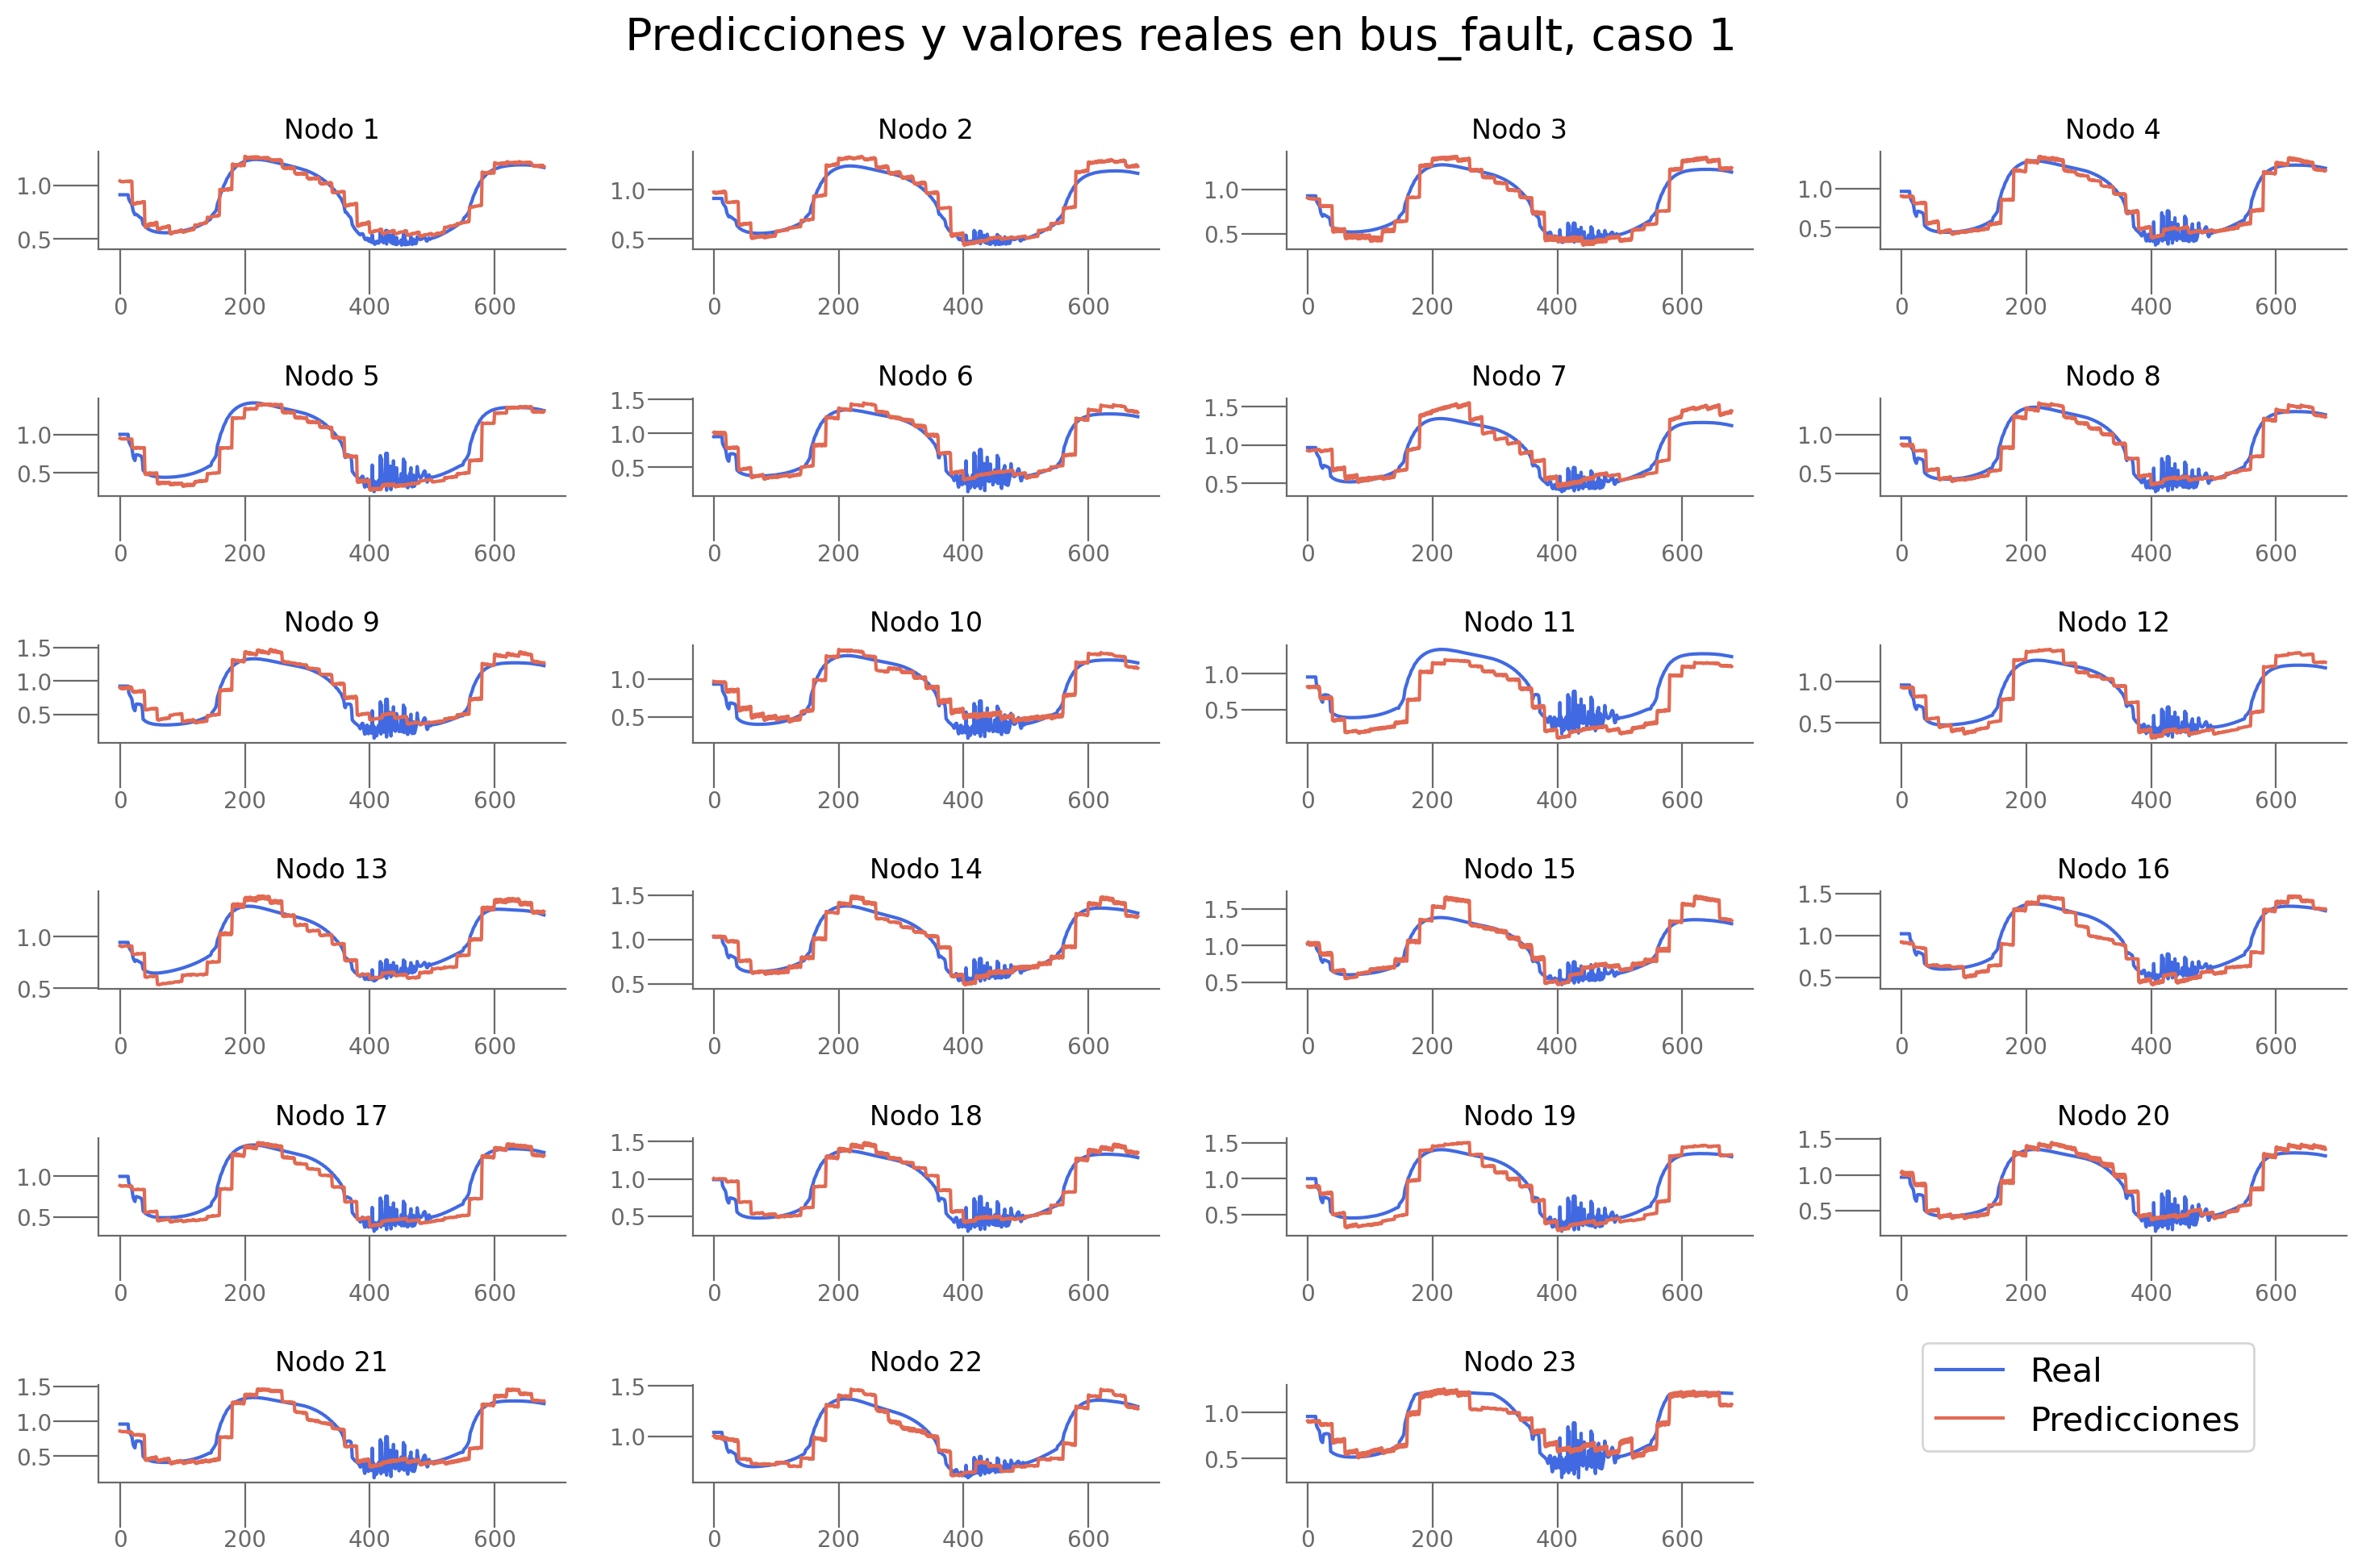

In [26]:
_,_,_, predictions_bf_ajuste,real_bf_ajuste = trainer_bf.test()
plot_predictions(predictions_bf_ajuste, real_bf_ajuste, n_target, 1, n_div_bf, problem_bf)

In [27]:
trainer_bf.save_model(path_save_experiment=path_save_experiment_bf, params = params_bf)


==================== GUARDANDO RESULTADOS ===================

         Modelo                                             Params  \
0          LSTM                                                NaN   
1  LSTM_NOBATCH                                                NaN   
2     MPNN_LSTM                {'hidden_size': 64, 'dropout': 0.2}   
3   DyGrEncoder             {'aggr': 'mean', 'conv': 1, 'lstm': 1}   
4        MSTGCN  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_...   
5     EvolveGCN                                                NaN   
6        ASTGCN  {'nb_block': 1, 'nb_chev_filter': 4, 'nb_time_...   
7         DCRNN                                     {'hidden': 40}   
8         MTGNN  {'gcn_depth': 1, 'conv_channels': 16, 'kernel_...   
9         AGCRN             {'hidden': 10, 'K': 2, 'embedding': 3}   

                      Fichero_resultados_experimento  Loss_tst     R2_tst  \
0                                                NaN  0.017298   0.603716   
1          

### Branch Fault

In [28]:
problem_brf = "branch_fault"
dataset_brf, situations_brf = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem_brf)


Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  92


In [29]:

n_div_brf = loader.div
n_nodes =dataset_brf.features[0].shape[0]
n_target = dataset_brf.targets[0].shape[1]
n_features = dataset_brf[0].x.shape[1]
embedding_dim =5

#### Sencilla 

In [74]:
model_brf = RecurrentGCN(n_features=n_features, n_nodes=n_nodes, embedding_dim=embedding_dim, n_target=n_target, name="AGCRN")
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

model_brf.to(device)
trainer_brf = TrainerAGCRN(model_brf, dataset_brf,device, f"./results/{problem_brf}", dataloader_params2)

losses,eval_losses, r2scores  = trainer_brf.train(num_epochs=num_epochs, steps=200, num_early_stop=num_early_stop)




==================== DATASET INFO ===================

Train dataset: 2160
Validation dataset: 465
Test dataset: 469

==================== DATALOADER INFO ===================

DataLoader for train set:
Number of batches: 432
DataLoader for val set:
Number of batches: 93
DataLoader for test set:
Number of batches: 93

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.1014 | Eval Loss: 0.0667 | Eval R2: -0.4596 | 
Epoch 2/30 | Train Loss: 0.0388 | Eval Loss: 0.0514 | Eval R2: 0.0382 | 
Epoch 3/30 | Train Loss: 0.0331 | Eval Loss: 0.0471 | Eval R2: 0.1788 | 
Epoch 4/30 | Train Loss: 0.0308 | Eval Loss: 0.0415 | Eval R2: 0.3115 | 
Epoch 5/30 | Train Loss: 0.0284 | Eval Loss: 0.0444 | Eval R2: 0.2686 | 
Epoch 6/30 | Train Loss: 0.0274 | Eval Loss: 0.0410 | Eval R2: 0.3514 | 
Epoch 7/30 | Train Loss: 0.0260 | Eval Loss: 0.0390 | Eval R2: 0.3967 | 
Epoch 8/30 | Train Loss: 0.0253 | Eval Loss: 0.0362 | Eval R2: 0.4543 | 
Epoch 9/30 | Train Loss: 0.0244 | Eval Los

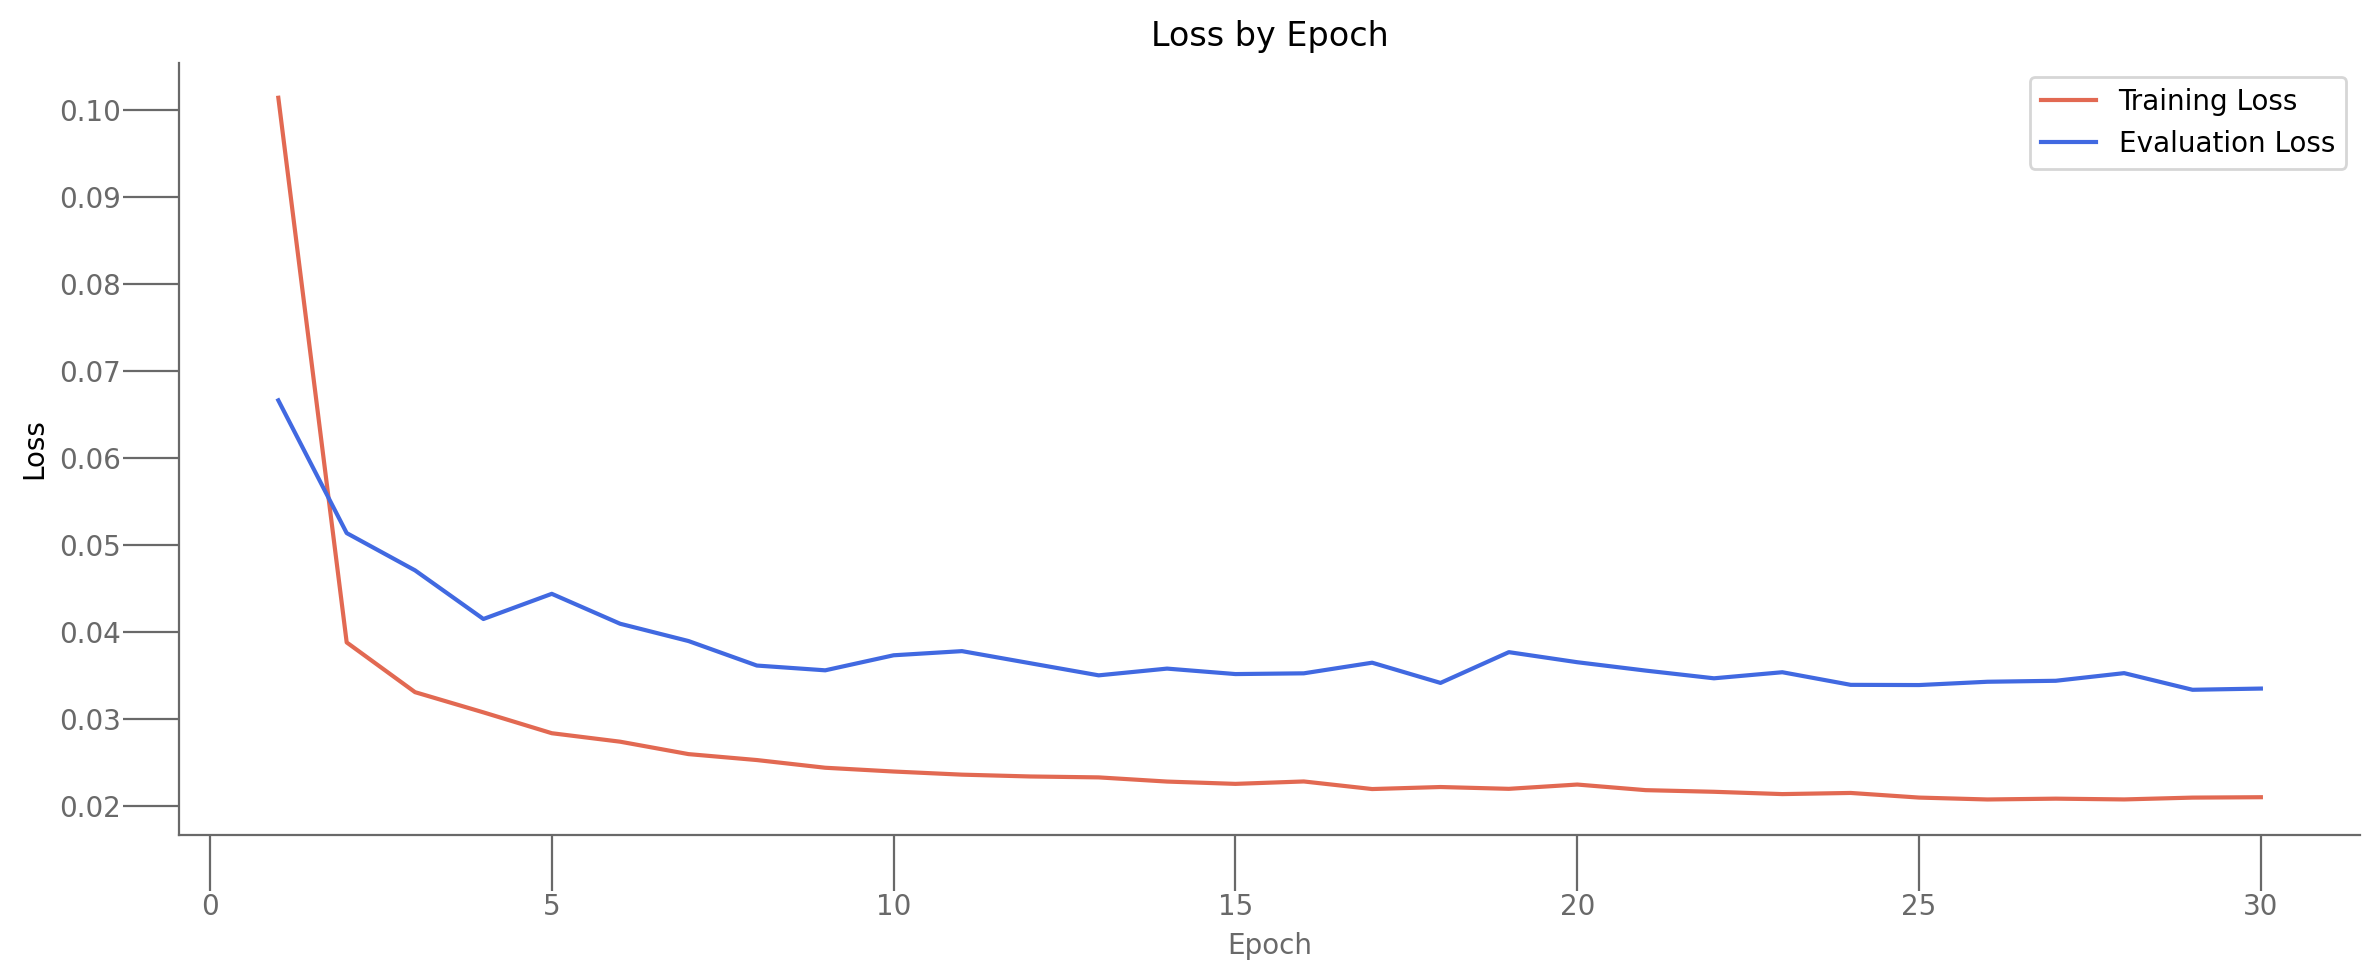


==================== TEST INFO ===================

preds:  (5, 23, 20)
test loss: 0.027778, test r2score 0.508333


In [75]:
plot_training_and_eval_losses(np.array(losses), np.array(eval_losses), num_epochs, format_plot)
losses_tst, r2score_tst, loss_nodes, predictions_brf, real_brf = trainer_brf.test()



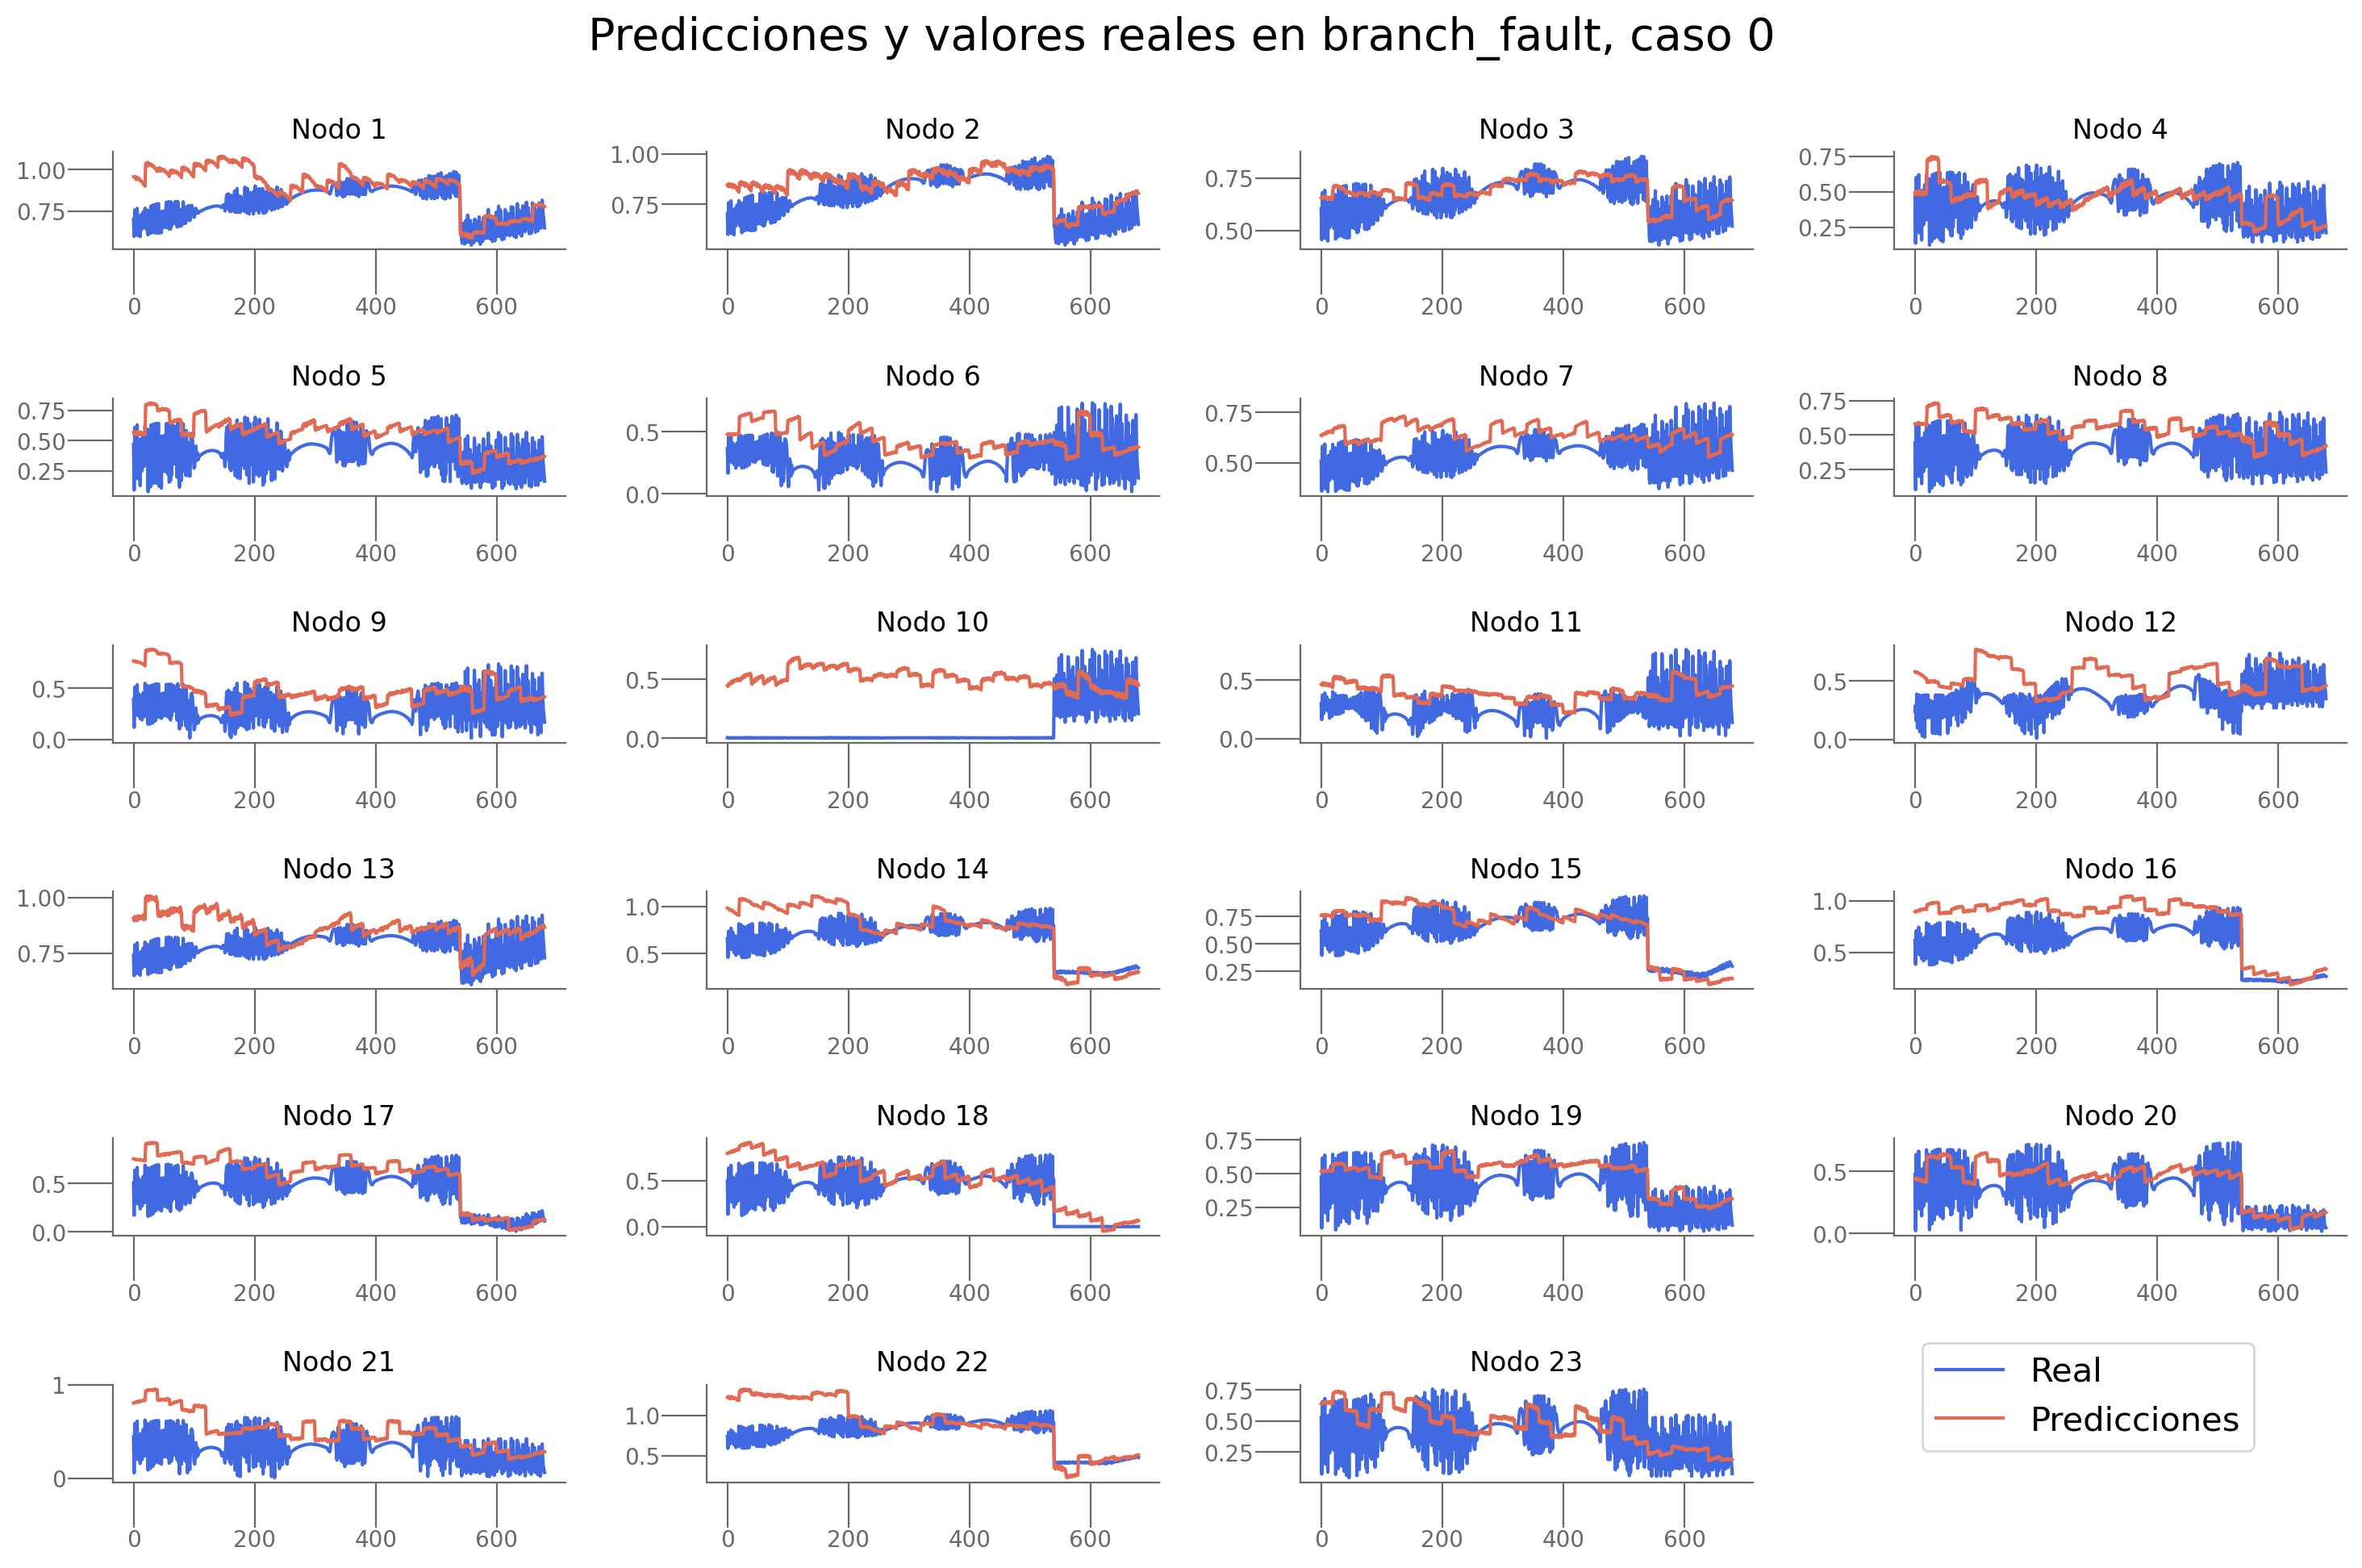

In [76]:
plot_predictions(predictions_brf, real_brf, n_target, 0, n_div_brf, problem_brf)

#### Ajuste de parámetros

In [30]:


trainer_brf,params_brf, resultados_final_brf, resultados_brf = entrenar_y_evaluar_modelos(param_grid, dataset_brf, dataloader_params2, num_early_stop=num_early_stop, num_epochs=num_epochs, problem=problem_brf)

  0%|          | 0/48 [00:00<?, ?it/s]


==================== DATASET INFO ===================

Train dataset: 2176
Validation dataset: 476
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoader for train set:
Number of batches: 435
DataLoader for val set:
Number of batches: 95
DataLoader for test set:
Number of batches: 88

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.1709 | Eval Loss: 0.1098 | Eval R2: -2.0858 | LR: 0.0010 | 
Epoch 2/30 | Train Loss: 0.0606 | Eval Loss: 0.0677 | Eval R2: -0.6788 | LR: 0.0010 | 
Epoch 3/30 | Train Loss: 0.0443 | Eval Loss: 0.0533 | Eval R2: -0.1613 | LR: 0.0010 | 
Epoch 4/30 | Train Loss: 0.0388 | Eval Loss: 0.0458 | Eval R2: 0.0927 | LR: 0.0010 | 
Epoch 5/30 | Train Loss: 0.0352 | Eval Loss: 0.0412 | Eval R2: 0.2419 | LR: 0.0010 | 
Epoch 6/30 | Train Loss: 0.0324 | Eval Loss: 0.0387 | Eval R2: 0.3290 | LR: 0.0010 | 
Epoch 7/30 | Train Loss: 0.0309 | Eval Loss: 0.0381 | Eval R2: 0.3598 | LR: 0.0010 | 
Epoch 8/30 | Train Los

  2%|▏         | 1/48 [03:27<2:42:18, 207.20s/it]

preds:  (5, 23, 20)
test loss: 0.027659, test R2 score: 0.554015
Parámetros:  10 2 3
Resultados:  {'Embedding': 3, 'k': 2, 'Hidden': 10, 'Loss_final': 0.021981095895171165, 'R2_eval': 0.5360419750213623, 'Loss_eval': 0.03306036442518234, 'R2_tst': 0.554015425893197, 'Loss_tst': 0.027658574283123016, 'Loss_nodes': [0.009107617661356926, 0.00783311203122139, 0.01740647293627262, 0.033132754266262054, 0.029993562027812004, 0.033171672374010086, 0.017051344737410545, 0.02684563212096691, 0.04282425716519356, 0.02613324485719204, 0.03642020747065544, 0.01946781761944294, 0.014748353511095047, 0.04348142445087433, 0.027741795405745506, 0.03430035337805748, 0.030392182990908623, 0.03401705250144005, 0.030951036140322685, 0.033777866512537, 0.03794371709227562, 0.024629009887576103, 0.024776695296168327]}

==================== DATASET INFO ===================

Train dataset: 2176
Validation dataset: 476
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoader for

  4%|▍         | 2/48 [07:09<2:45:32, 215.93s/it]

preds:  (5, 23, 20)
test loss: 0.038466, test R2 score: 0.223052
Parámetros:  10 3 3
Resultados:  {'Embedding': 3, 'k': 3, 'Hidden': 10, 'Loss_final': 0.023785557597875595, 'R2_eval': 0.10556735098361969, 'Loss_eval': 0.04806094989180565, 'R2_tst': 0.22305236288781402, 'Loss_tst': 0.038465723395347595, 'Loss_nodes': [0.023235267028212547, 0.015856418758630753, 0.02107568085193634, 0.02814963459968567, 0.04056985303759575, 0.06260670721530914, 0.025079792365431786, 0.042014967650175095, 0.036705732345581055, 0.042259618639945984, 0.04731322452425957, 0.019650204107165337, 0.017444858327507973, 0.053953029215335846, 0.09437685459852219, 0.030738351866602898, 0.030855657532811165, 0.04172758385539055, 0.03215598687529564, 0.05631190165877342, 0.034915875643491745, 0.049248289316892624, 0.03846609964966774]}

==================== DATASET INFO ===================

Train dataset: 2176
Validation dataset: 476
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoa

  6%|▋         | 3/48 [11:02<2:47:42, 223.62s/it]

preds:  (5, 23, 20)
test loss: 0.047093, test R2 score: 0.019486
Parámetros:  10 4 3
Resultados:  {'Embedding': 3, 'k': 4, 'Hidden': 10, 'Loss_final': 0.027933742851018906, 'R2_eval': -0.03515033796429634, 'Loss_eval': 0.055551327764987946, 'R2_tst': 0.019485943918908465, 'Loss_tst': 0.04709331691265106, 'Loss_nodes': [0.03281192481517792, 0.012155367992818356, 0.021321861073374748, 0.06323179602622986, 0.03601321205496788, 0.06145868077874184, 0.055708207190036774, 0.030528591945767403, 0.07604295760393143, 0.0320545993745327, 0.051036249846220016, 0.03133812174201012, 0.03125527873635292, 0.04729011282324791, 0.05998053401708603, 0.07146663218736649, 0.048000577837228775, 0.05051066726446152, 0.061450984328985214, 0.06314874440431595, 0.05951545387506485, 0.04706220328807831, 0.03976348415017128]}

==================== DATASET INFO ===================

Train dataset: 2176
Validation dataset: 476
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoader f

  8%|▊         | 4/48 [14:24<2:37:58, 215.42s/it]

preds:  (5, 23, 20)
test loss: 0.031571, test R2 score: 0.441593
Parámetros:  20 2 3
Resultados:  {'Embedding': 3, 'k': 2, 'Hidden': 20, 'Loss_final': 0.020465558394789696, 'R2_eval': 0.43903374671936035, 'Loss_eval': 0.034876272082328796, 'R2_tst': 0.44159348224790607, 'Loss_tst': 0.031570639461278915, 'Loss_nodes': [0.01445863489061594, 0.014402959495782852, 0.02129790000617504, 0.029895013198256493, 0.02736796624958515, 0.036455366760492325, 0.03121328540146351, 0.025748616084456444, 0.04668153449892998, 0.0325002484023571, 0.03590596839785576, 0.021580399945378304, 0.02165348082780838, 0.03323286399245262, 0.036459825932979584, 0.041286174207925797, 0.031576693058013916, 0.04924178123474121, 0.032929275184869766, 0.039797551929950714, 0.0427495576441288, 0.0301103163510561, 0.02957932837307453]}

==================== DATASET INFO ===================

Train dataset: 2176
Validation dataset: 476
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoader f

 10%|█         | 5/48 [18:13<2:37:41, 220.04s/it]

preds:  (5, 23, 20)
test loss: 0.034564, test R2 score: 0.370801
Parámetros:  20 3 3
Resultados:  {'Embedding': 3, 'k': 3, 'Hidden': 20, 'Loss_final': 0.020991329103708267, 'R2_eval': 0.22993989288806915, 'Loss_eval': 0.04305439814925194, 'R2_tst': 0.37080125301805666, 'Loss_tst': 0.034564316272735596, 'Loss_nodes': [0.01562979631125927, 0.011435199528932571, 0.031035013496875763, 0.03032349981367588, 0.028709812089800835, 0.03663153946399689, 0.042374685406684875, 0.03349296376109123, 0.04415493831038475, 0.04106052592396736, 0.03364089876413345, 0.02637471631169319, 0.023847298696637154, 0.03759622201323509, 0.04025903716683388, 0.040792081505060196, 0.03792360797524452, 0.04730626195669174, 0.03334904462099075, 0.041728775948286057, 0.041548267006874084, 0.03490029275417328, 0.04086481034755707]}

==================== DATASET INFO ===================

Train dataset: 2176
Validation dataset: 476
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoader f

 12%|█▎        | 6/48 [22:20<2:40:26, 229.21s/it]

preds:  (5, 23, 20)
test loss: 0.039371, test R2 score: 0.272200
Parámetros:  20 4 3
Resultados:  {'Embedding': 3, 'k': 4, 'Hidden': 20, 'Loss_final': 0.022808212786912918, 'R2_eval': 0.08987170457839966, 'Loss_eval': 0.04855024442076683, 'R2_tst': 0.2721999023920825, 'Loss_tst': 0.03937120735645294, 'Loss_nodes': [0.03808220475912094, 0.014528513886034489, 0.018179284408688545, 0.030588561668992043, 0.030482826754450798, 0.05984934791922569, 0.030324624851346016, 0.03663894534111023, 0.036756593734025955, 0.04589652642607689, 0.056652773171663284, 0.022961299866437912, 0.012715930119156837, 0.06104689836502075, 0.08979788422584534, 0.03235890716314316, 0.03470233455300331, 0.04175932705402374, 0.03340191766619682, 0.05888665094971657, 0.0378677137196064, 0.036226484924554825, 0.04583222046494484]}

==================== DATASET INFO ===================

Train dataset: 2176
Validation dataset: 476
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoader fo

 15%|█▍        | 7/48 [26:08<2:36:33, 229.10s/it]

preds:  (5, 23, 20)
test loss: 0.033530, test R2 score: 0.385395
Parámetros:  50 2 3
Resultados:  {'Embedding': 3, 'k': 2, 'Hidden': 50, 'Loss_final': 0.01915326900780201, 'R2_eval': 0.33752813935279846, 'Loss_eval': 0.036578524857759476, 'R2_tst': 0.38539526988869, 'Loss_tst': 0.03352993354201317, 'Loss_nodes': [0.01746223121881485, 0.017997216433286667, 0.029970873147249222, 0.029893219470977783, 0.029721451923251152, 0.03699825704097748, 0.02827213890850544, 0.02897901087999344, 0.04172233119606972, 0.0369332991540432, 0.03772931173443794, 0.026146767660975456, 0.019630543887615204, 0.024810612201690674, 0.040941208600997925, 0.045436836779117584, 0.03442775458097458, 0.03953937441110611, 0.03557874262332916, 0.04732401669025421, 0.04486028850078583, 0.04311782866716385, 0.033695146441459656]}

==================== DATASET INFO ===================

Train dataset: 2176
Validation dataset: 476
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoader for 

 17%|█▋        | 8/48 [30:38<2:41:20, 242.00s/it]

preds:  (5, 23, 20)
test loss: 0.039360, test R2 score: 0.253011
Parámetros:  50 3 3
Resultados:  {'Embedding': 3, 'k': 3, 'Hidden': 50, 'Loss_final': 0.019349422305822372, 'R2_eval': 0.06719062477350235, 'Loss_eval': 0.046467915177345276, 'R2_tst': 0.25301097357217245, 'Loss_tst': 0.039359960705041885, 'Loss_nodes': [0.02224607765674591, 0.025431811809539795, 0.022271614521741867, 0.033485569059848785, 0.030878452584147453, 0.048488304018974304, 0.02540656179189682, 0.037134673446416855, 0.04770868644118309, 0.04352850094437599, 0.034397970885038376, 0.026923654600977898, 0.028255552053451538, 0.0418032743036747, 0.06838906556367874, 0.0437387190759182, 0.043999314308166504, 0.048922691494226456, 0.04178881645202637, 0.059540580958127975, 0.05039418861269951, 0.040233708918094635, 0.04031144082546234]}

==================== DATASET INFO ===================

Train dataset: 2176
Validation dataset: 476
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoad

 19%|█▉        | 9/48 [35:29<2:47:17, 257.37s/it]

preds:  (5, 23, 20)
test loss: 0.035399, test R2 score: 0.367942
Parámetros:  50 4 3
Resultados:  {'Embedding': 3, 'k': 4, 'Hidden': 50, 'Loss_final': 0.020668059587478638, 'R2_eval': 0.1368899643421173, 'Loss_eval': 0.04303685575723648, 'R2_tst': 0.36794194583314005, 'Loss_tst': 0.035399358719587326, 'Loss_nodes': [0.02274554967880249, 0.01697533391416073, 0.022125422954559326, 0.035696033388376236, 0.03293875232338905, 0.04967367276549339, 0.022548725828528404, 0.028767092153429985, 0.044585708528757095, 0.029861146584153175, 0.04109099879860878, 0.028707515448331833, 0.013192878104746342, 0.04241946339607239, 0.05539878457784653, 0.04194086417555809, 0.0341082438826561, 0.04237287864089012, 0.03534286841750145, 0.05115684121847153, 0.041275832802057266, 0.051690079271793365, 0.029570428654551506]}

==================== DATASET INFO ===================

Train dataset: 2176
Validation dataset: 476
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoader 

 21%|██        | 10/48 [41:05<2:58:20, 281.60s/it]

preds:  (5, 23, 20)
test loss: 0.033483, test R2 score: 0.372608
Parámetros:  100 2 3
Resultados:  {'Embedding': 3, 'k': 2, 'Hidden': 100, 'Loss_final': 0.018606074154376984, 'R2_eval': 0.32270708680152893, 'Loss_eval': 0.0369248129427433, 'R2_tst': 0.3726081394163023, 'Loss_tst': 0.033483389765024185, 'Loss_nodes': [0.01708306558430195, 0.014498520642518997, 0.025794409215450287, 0.028752606362104416, 0.02599913440644741, 0.04097273200750351, 0.029187148436903954, 0.031238246709108353, 0.03954056277871132, 0.041205428540706635, 0.03424053639173508, 0.025055550038814545, 0.02481953427195549, 0.028991268947720528, 0.04405565932393074, 0.0369512178003788, 0.03951222822070122, 0.04799269512295723, 0.03720759227871895, 0.042794421315193176, 0.040935829281806946, 0.03267964348196983, 0.04060995951294899]}

==================== DATASET INFO ===================

Train dataset: 2176
Validation dataset: 476
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoader 

 23%|██▎       | 11/48 [47:47<3:16:17, 318.32s/it]

preds:  (5, 23, 20)
test loss: 0.031570, test R2 score: 0.425642
Parámetros:  100 3 3
Resultados:  {'Embedding': 3, 'k': 3, 'Hidden': 100, 'Loss_final': 0.019635481759905815, 'R2_eval': 0.2908684313297272, 'Loss_eval': 0.03733823448419571, 'R2_tst': 0.42564157393114466, 'Loss_tst': 0.03156990557909012, 'Loss_nodes': [0.015644682571291924, 0.01270585972815752, 0.014934215694665909, 0.03411063179373741, 0.02696644701063633, 0.03823252394795418, 0.02343880943953991, 0.029892612248659134, 0.04480740427970886, 0.03311767056584358, 0.032185085117816925, 0.02127428725361824, 0.024784183129668236, 0.028117315843701363, 0.03976329788565636, 0.03871423378586769, 0.03295338898897171, 0.04991801083087921, 0.035425104200839996, 0.037382178008556366, 0.043028805404901505, 0.030516022816300392, 0.038195013999938965]}

==================== DATASET INFO ===================

Train dataset: 2176
Validation dataset: 476
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoade

 25%|██▌       | 12/48 [55:31<3:37:42, 362.85s/it]

preds:  (5, 23, 20)
test loss: 0.034816, test R2 score: 0.343646
Parámetros:  100 4 3
Resultados:  {'Embedding': 3, 'k': 4, 'Hidden': 100, 'Loss_final': 0.020904982462525368, 'R2_eval': 0.16151247918605804, 'Loss_eval': 0.04130934923887253, 'R2_tst': 0.343645565151152, 'Loss_tst': 0.034816060215234756, 'Loss_nodes': [0.01708173006772995, 0.014947435818612576, 0.02356722205877304, 0.033425625413656235, 0.0365048311650753, 0.043853167444467545, 0.03491609916090965, 0.03706962987780571, 0.04155853018164635, 0.039899278432130814, 0.04518263041973114, 0.024364618584513664, 0.01827135495841503, 0.033400751650333405, 0.044318705797195435, 0.04118574783205986, 0.03642137348651886, 0.04384584352374077, 0.03424493968486786, 0.04012474790215492, 0.041013482958078384, 0.03420460596680641, 0.0413670539855957]}

==================== DATASET INFO ===================

Train dataset: 2176
Validation dataset: 476
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoader for

 27%|██▋       | 13/48 [59:05<3:05:21, 317.75s/it]

preds:  (5, 23, 20)
test loss: 0.028944, test R2 score: 0.509985
Parámetros:  10 2 5
Resultados:  {'Embedding': 5, 'k': 2, 'Hidden': 10, 'Loss_final': 0.0219863411039114, 'R2_eval': 0.5230098366737366, 'Loss_eval': 0.03261151537299156, 'R2_tst': 0.5099854669808846, 'Loss_tst': 0.02894389070570469, 'Loss_nodes': [0.017986785620450974, 0.013818372040987015, 0.017040975391864777, 0.028010619804263115, 0.03330502286553383, 0.035597797483205795, 0.02475898154079914, 0.025863265618681908, 0.03689853474497795, 0.027748174965381622, 0.037223946303129196, 0.022669898346066475, 0.011127695441246033, 0.02989249676465988, 0.03465171158313751, 0.02913353405892849, 0.03240499272942543, 0.04833277687430382, 0.030087394639849663, 0.03369715064764023, 0.037125494331121445, 0.03192461282014847, 0.026409262791275978]}

==================== DATASET INFO ===================

Train dataset: 2176
Validation dataset: 476
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoader f

 29%|██▉       | 14/48 [1:02:42<2:42:43, 287.16s/it]

preds:  (5, 23, 20)
test loss: 0.037831, test R2 score: 0.282459
Parámetros:  10 3 5
Resultados:  {'Embedding': 5, 'k': 3, 'Hidden': 10, 'Loss_final': 0.022782089188694954, 'R2_eval': 0.20043374598026276, 'Loss_eval': 0.045298982411623, 'R2_tst': 0.28245858839482324, 'Loss_tst': 0.03783078491687775, 'Loss_nodes': [0.019277872517704964, 0.027914518490433693, 0.03534768894314766, 0.03325621783733368, 0.03897128626704216, 0.0430527962744236, 0.01868605799973011, 0.04077836126089096, 0.04066196084022522, 0.03643826022744179, 0.038110923022031784, 0.034665510058403015, 0.014045891351997852, 0.03789372742176056, 0.03964610770344734, 0.031294386833906174, 0.039449017494916916, 0.12125719338655472, 0.02723640203475952, 0.03775821626186371, 0.042349737137556076, 0.042969342321157455, 0.029046589508652687]}

==================== DATASET INFO ===================

Train dataset: 2176
Validation dataset: 476
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoader for

 31%|███▏      | 15/48 [1:06:24<2:27:06, 267.46s/it]

preds:  (5, 23, 20)
test loss: 0.037512, test R2 score: 0.291593
Parámetros:  10 4 5
Resultados:  {'Embedding': 5, 'k': 4, 'Hidden': 10, 'Loss_final': 0.025128589943051338, 'R2_eval': 0.10960362106561661, 'Loss_eval': 0.0477992407977581, 'R2_tst': 0.2915932649108431, 'Loss_tst': 0.037511661648750305, 'Loss_nodes': [0.025160836055874825, 0.02403515763580799, 0.021390613168478012, 0.03322224318981171, 0.03804291784763336, 0.0493762344121933, 0.028681349009275436, 0.03765331208705902, 0.04953192546963692, 0.029365209862589836, 0.04019602760672569, 0.03912337124347687, 0.014893158338963985, 0.049678873270750046, 0.031409282237291336, 0.05120592191815376, 0.039323143661022186, 0.04011521115899086, 0.03409191966056824, 0.04438997805118561, 0.06350073218345642, 0.048495423048734665, 0.02988537959754467]}

==================== DATASET INFO ===================

Train dataset: 2176
Validation dataset: 476
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoader for

 33%|███▎      | 16/48 [1:09:56<2:13:45, 250.79s/it]

preds:  (5, 23, 20)
test loss: 0.027804, test R2 score: 0.534110
Parámetros:  20 2 5
Resultados:  {'Embedding': 5, 'k': 2, 'Hidden': 20, 'Loss_final': 0.020555224269628525, 'R2_eval': 0.5055102109909058, 'Loss_eval': 0.032826557755470276, 'R2_tst': 0.5341100178618103, 'Loss_tst': 0.027804095298051834, 'Loss_nodes': [0.015845878049731255, 0.008944403380155563, 0.011700510047376156, 0.026339584961533546, 0.033049993216991425, 0.034694697707891464, 0.016104139387607574, 0.027793139219284058, 0.04302893206477165, 0.027197225019335747, 0.03398832306265831, 0.028558481484651566, 0.012519137002527714, 0.02976827509701252, 0.027478117495775223, 0.032136425375938416, 0.03216123953461647, 0.03491338714957237, 0.03147904574871063, 0.03406866639852524, 0.039504457265138626, 0.030198555439710617, 0.028021562844514847]}

==================== DATASET INFO ===================

Train dataset: 2176
Validation dataset: 476
Test dataset: 442

==================== DATALOADER INFO ===================

DataL

 35%|███▌      | 17/48 [1:13:47<2:06:35, 245.01s/it]

preds:  (5, 23, 20)
test loss: 0.041591, test R2 score: 0.179616
Parámetros:  20 3 5
Resultados:  {'Embedding': 5, 'k': 3, 'Hidden': 20, 'Loss_final': 0.02135176584124565, 'R2_eval': 0.016378197818994522, 'Loss_eval': 0.05077534541487694, 'R2_tst': 0.1796155522499345, 'Loss_tst': 0.04159089922904968, 'Loss_nodes': [0.01412343978881836, 0.014445134438574314, 0.024171235039830208, 0.029589248821139336, 0.06018814817070961, 0.04232114925980568, 0.018022652715444565, 0.0471763052046299, 0.06058565527200699, 0.041785869747400284, 0.06977718323469162, 0.03169586881995201, 0.04504821076989174, 0.03700604289770126, 0.06232505664229393, 0.035815369337797165, 0.04379625618457794, 0.05019873008131981, 0.06865071505308151, 0.05049004405736923, 0.037073008716106415, 0.03616145998239517, 0.03614385053515434]}

==================== DATASET INFO ===================

Train dataset: 2176
Validation dataset: 476
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoader for t

 38%|███▊      | 18/48 [1:17:57<2:03:10, 246.36s/it]

preds:  (5, 23, 20)
test loss: 0.042551, test R2 score: 0.155244
Parámetros:  20 4 5
Resultados:  {'Embedding': 5, 'k': 4, 'Hidden': 20, 'Loss_final': 0.02307688258588314, 'R2_eval': -0.06296195834875107, 'Loss_eval': 0.053316619247198105, 'R2_tst': 0.15524366215981616, 'Loss_tst': 0.042550958693027496, 'Loss_nodes': [0.024390934035182, 0.026056326925754547, 0.023723114281892776, 0.0365370437502861, 0.03877152130007744, 0.0732247456908226, 0.02191508561372757, 0.04042588174343109, 0.044235434383153915, 0.04832793399691582, 0.04120170325040817, 0.0293051116168499, 0.022656654939055443, 0.0464165173470974, 0.02996872551739216, 0.08299782872200012, 0.05571852624416351, 0.052146926522254944, 0.03152433782815933, 0.035809729248285294, 0.08608546108007431, 0.04274355247616768, 0.04448886215686798]}

==================== DATASET INFO ===================

Train dataset: 2176
Validation dataset: 476
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoader for trai

 40%|███▉      | 19/48 [1:21:29<1:54:07, 236.12s/it]

preds:  (5, 23, 20)
test loss: 0.034194, test R2 score: 0.358123
Parámetros:  50 2 5
Resultados:  {'Embedding': 5, 'k': 2, 'Hidden': 50, 'Loss_final': 0.018908608704805374, 'R2_eval': 0.309731125831604, 'Loss_eval': 0.03811810165643692, 'R2_tst': 0.3581231900537125, 'Loss_tst': 0.03419429436326027, 'Loss_nodes': [0.02603737637400627, 0.01801810972392559, 0.014668785966932774, 0.029037294909358025, 0.047356367111206055, 0.039407338947057724, 0.021090192720294, 0.02953820675611496, 0.047135140746831894, 0.028942467644810677, 0.03589843958616257, 0.029673902317881584, 0.0221844632178545, 0.03907310590147972, 0.033822622150182724, 0.029311442747712135, 0.04600602015852928, 0.061341989785432816, 0.030761396512389183, 0.034757986664772034, 0.04597686231136322, 0.0488438755273819, 0.027585403993725777]}

==================== DATASET INFO ===================

Train dataset: 2176
Validation dataset: 476
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoader for 

 42%|████▏     | 20/48 [1:26:06<1:55:57, 248.47s/it]

preds:  (5, 23, 20)
test loss: 0.034000, test R2 score: 0.375575
Parámetros:  50 3 5
Resultados:  {'Embedding': 5, 'k': 3, 'Hidden': 50, 'Loss_final': 0.020400693640112877, 'R2_eval': 0.22531554102897644, 'Loss_eval': 0.04065736010670662, 'R2_tst': 0.3755749953535295, 'Loss_tst': 0.033999744802713394, 'Loss_nodes': [0.029371289536356926, 0.021532483398914337, 0.015730177983641624, 0.039280641824007034, 0.04341256618499756, 0.04197254404425621, 0.021968601271510124, 0.029884684830904007, 0.04327033460140228, 0.02787730097770691, 0.03569257631897926, 0.02989068068563938, 0.015179535374045372, 0.03777994215488434, 0.03217031806707382, 0.032962001860141754, 0.03754231333732605, 0.0428035669028759, 0.044991735368967056, 0.04783502593636513, 0.04147240146994591, 0.04311906546354294, 0.026254288852214813]}

==================== DATASET INFO ===================

Train dataset: 2176
Validation dataset: 476
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoader f

 44%|████▍     | 21/48 [1:31:11<1:59:20, 265.20s/it]

preds:  (5, 23, 20)
test loss: 0.036595, test R2 score: 0.294316
Parámetros:  50 4 5
Resultados:  {'Embedding': 5, 'k': 4, 'Hidden': 50, 'Loss_final': 0.022414861246943474, 'R2_eval': 0.11281415820121765, 'Loss_eval': 0.04426128417253494, 'R2_tst': 0.29431606356077916, 'Loss_tst': 0.03659500554203987, 'Loss_nodes': [0.03250370919704437, 0.022543882951140404, 0.02472822740674019, 0.03864656388759613, 0.0403115414083004, 0.04238471761345863, 0.02120378613471985, 0.03812078759074211, 0.048105236142873764, 0.0359027236700058, 0.04861997440457344, 0.03510682284832001, 0.03192231431603432, 0.03498901426792145, 0.03012673929333687, 0.03628000244498253, 0.03828687220811844, 0.045919109135866165, 0.04005584865808487, 0.038676511496305466, 0.04152541235089302, 0.043646544218063354, 0.03207891434431076]}

==================== DATASET INFO ===================

Train dataset: 2176
Validation dataset: 476
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoader for tra

 46%|████▌     | 22/48 [1:36:26<2:01:26, 280.27s/it]

preds:  (5, 23, 20)
test loss: 0.033659, test R2 score: 0.370267
Parámetros:  100 2 5
Resultados:  {'Embedding': 5, 'k': 2, 'Hidden': 100, 'Loss_final': 0.01907520554959774, 'R2_eval': 0.27454882860183716, 'Loss_eval': 0.038789816200733185, 'R2_tst': 0.37026671019240387, 'Loss_tst': 0.03365937992930412, 'Loss_nodes': [0.021117644384503365, 0.03328622877597809, 0.013445880264043808, 0.028867237269878387, 0.03981946408748627, 0.04058769717812538, 0.02861245721578598, 0.02804434299468994, 0.04588444158434868, 0.03750210255384445, 0.03285833075642586, 0.024950306862592697, 0.039751455187797546, 0.03261614218354225, 0.028959626331925392, 0.03813229873776436, 0.03790346160531044, 0.046866144984960556, 0.031441669911146164, 0.034308452159166336, 0.038626302033662796, 0.03821275383234024, 0.03237123787403107]}

==================== DATASET INFO ===================

Train dataset: 2176
Validation dataset: 476
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoade

 48%|████▊     | 23/48 [1:43:16<2:12:58, 319.16s/it]

preds:  (5, 23, 20)
test loss: 0.031616, test R2 score: 0.429901
Parámetros:  100 3 5
Resultados:  {'Embedding': 5, 'k': 3, 'Hidden': 100, 'Loss_final': 0.02078245021402836, 'R2_eval': 0.24921993911266327, 'Loss_eval': 0.03848128020763397, 'R2_tst': 0.4299014610110905, 'Loss_tst': 0.03161559998989105, 'Loss_nodes': [0.018076695501804352, 0.028245119377970695, 0.016180571168661118, 0.027588142082095146, 0.04078712686896324, 0.03944854438304901, 0.026828331872820854, 0.028262417763471603, 0.0405854769051075, 0.02863718383014202, 0.03728765621781349, 0.030529821291565895, 0.019411949440836906, 0.03356499597430229, 0.028151284903287888, 0.03090941719710827, 0.03531119227409363, 0.03803082928061485, 0.040729645639657974, 0.03787621483206749, 0.03846349939703941, 0.03202715143561363, 0.030225610360503197]}

==================== DATASET INFO ===================

Train dataset: 2176
Validation dataset: 476
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoader 

 50%|█████     | 24/48 [1:50:57<2:24:45, 361.90s/it]

preds:  (5, 23, 20)
test loss: 0.036975, test R2 score: 0.319555
Parámetros:  100 4 5
Resultados:  {'Embedding': 5, 'k': 4, 'Hidden': 100, 'Loss_final': 0.02209075540304184, 'R2_eval': 0.010914578102529049, 'Loss_eval': 0.0450771227478981, 'R2_tst': 0.31955484600450196, 'Loss_tst': 0.0369751900434494, 'Loss_nodes': [0.025206660851836205, 0.025757556781172752, 0.029878364875912666, 0.035778287798166275, 0.03959845006465912, 0.043306708335876465, 0.029240258038043976, 0.0357917882502079, 0.05003112182021141, 0.04366869479417801, 0.042522333562374115, 0.03349586948752403, 0.01917247287929058, 0.042472656816244125, 0.03141431510448456, 0.042956430464982986, 0.036837778985500336, 0.042443957179784775, 0.036533430218696594, 0.037457771599292755, 0.04971742630004883, 0.0378410667181015, 0.03930601477622986]}

==================== DATASET INFO ===================

Train dataset: 2176
Validation dataset: 476
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoader

 52%|█████▏    | 25/48 [1:54:15<1:59:50, 312.64s/it]

preds:  (5, 23, 20)
test loss: 0.038759, test R2 score: 0.218043
Parámetros:  10 2 10
Resultados:  {'Embedding': 10, 'k': 2, 'Hidden': 10, 'Loss_final': 0.02416549250483513, 'R2_eval': 0.06824414432048798, 'Loss_eval': 0.05094454064965248, 'R2_tst': 0.2180434774237426, 'Loss_tst': 0.03875909373164177, 'Loss_nodes': [0.0151413818821311, 0.011187637224793434, 0.04652540385723114, 0.02868018113076687, 0.03366094455122948, 0.04847731813788414, 0.034388549625873566, 0.03904128447175026, 0.04206003248691559, 0.042227134108543396, 0.061905618757009506, 0.024955876171588898, 0.024660157039761543, 0.02844759076833725, 0.038344576954841614, 0.10147395730018616, 0.03273425251245499, 0.047270141541957855, 0.04239968582987785, 0.035217564553022385, 0.03785599768161774, 0.041319847106933594, 0.03348401561379433]}

==================== DATASET INFO ===================

Train dataset: 2176
Validation dataset: 476
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoader f

 54%|█████▍    | 26/48 [1:57:58<1:44:46, 285.76s/it]

preds:  (5, 23, 20)
test loss: 0.032927, test R2 score: 0.411407
Parámetros:  10 3 10
Resultados:  {'Embedding': 10, 'k': 3, 'Hidden': 10, 'Loss_final': 0.027050094678997993, 'R2_eval': 0.2959790825843811, 'Loss_eval': 0.041186682879924774, 'R2_tst': 0.4114067451950389, 'Loss_tst': 0.0329267643392086, 'Loss_nodes': [0.015994960442185402, 0.010255576111376286, 0.01987668126821518, 0.028282273560762405, 0.03562028333544731, 0.035796310752630234, 0.02117943949997425, 0.033287163823843, 0.04118721932172775, 0.027877531945705414, 0.07050369679927826, 0.034059468656778336, 0.010773246176540852, 0.03244537487626076, 0.02872353047132492, 0.030906427651643753, 0.04231421649456024, 0.046243976801633835, 0.043780554085969925, 0.038911376148462296, 0.034694232046604156, 0.029680641368031502, 0.044921353459358215]}

==================== DATASET INFO ===================

Train dataset: 2176
Validation dataset: 476
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoade

 56%|█████▋    | 27/48 [2:01:53<1:34:39, 270.45s/it]

preds:  (5, 23, 20)
test loss: 0.037797, test R2 score: 0.264753
Parámetros:  10 4 10
Resultados:  {'Embedding': 10, 'k': 4, 'Hidden': 10, 'Loss_final': 0.02967349998652935, 'R2_eval': 0.02649511955678463, 'Loss_eval': 0.05024494230747223, 'R2_tst': 0.2647534883475005, 'Loss_tst': 0.037797294557094574, 'Loss_nodes': [0.018134592100977898, 0.017315614968538284, 0.033197250217199326, 0.031232820823788643, 0.04706097021698952, 0.04066067561507225, 0.026396144181489944, 0.035824965685606, 0.05049740895628929, 0.0350944958627224, 0.04021279513835907, 0.031198715791106224, 0.018997399136424065, 0.03412024304270744, 0.031660109758377075, 0.03515481576323509, 0.056713126599788666, 0.050098661333322525, 0.0560382604598999, 0.06766917556524277, 0.05186732858419418, 0.03294895589351654, 0.027243245393037796]}

==================== DATASET INFO ===================

Train dataset: 2176
Validation dataset: 476
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoader fo

 58%|█████▊    | 28/48 [2:05:31<1:24:54, 254.73s/it]

preds:  (5, 23, 20)
test loss: 0.030805, test R2 score: 0.466237
Parámetros:  20 2 10
Resultados:  {'Embedding': 10, 'k': 2, 'Hidden': 20, 'Loss_final': 0.022434214130043983, 'R2_eval': 0.39564546942710876, 'Loss_eval': 0.03695476055145264, 'R2_tst': 0.4662365006535247, 'Loss_tst': 0.03080507554113865, 'Loss_nodes': [0.011994127184152603, 0.014335308223962784, 0.019206663593649864, 0.03095836564898491, 0.039543624967336655, 0.03998332843184471, 0.02463959902524948, 0.025193536654114723, 0.05789982154965401, 0.02724285237491131, 0.03525287285447121, 0.02662208117544651, 0.012041334062814713, 0.03266960009932518, 0.033239301294088364, 0.03744300827383995, 0.03697800263762474, 0.0367664210498333, 0.033515095710754395, 0.036719150841236115, 0.03684303164482117, 0.033847060054540634, 0.025582533329725266]}

==================== DATASET INFO ===================

Train dataset: 2176
Validation dataset: 476
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoader

 60%|██████    | 29/48 [2:09:19<1:18:07, 246.69s/it]

preds:  (5, 23, 20)
test loss: 0.035822, test R2 score: 0.325913
Parámetros:  20 3 10
Resultados:  {'Embedding': 10, 'k': 3, 'Hidden': 20, 'Loss_final': 0.024881413206458092, 'R2_eval': 0.1074419692158699, 'Loss_eval': 0.046390350908041, 'R2_tst': 0.32591291885331414, 'Loss_tst': 0.03582247719168663, 'Loss_nodes': [0.022723659873008728, 0.014754355885088444, 0.021035462617874146, 0.030638478696346283, 0.0435820110142231, 0.040474262088537216, 0.03346925228834152, 0.03741172328591347, 0.06185150519013405, 0.037324849516153336, 0.044983960688114166, 0.03239656612277031, 0.013727780431509018, 0.02966522052884102, 0.039528582245111465, 0.04372318089008331, 0.037235796451568604, 0.04437967389822006, 0.036005180329084396, 0.04838648810982704, 0.045248135924339294, 0.03580790385603905, 0.029562897980213165]}

==================== DATASET INFO ===================

Train dataset: 2176
Validation dataset: 476
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoader

 62%|██████▎   | 30/48 [2:13:35<1:14:50, 249.49s/it]

preds:  (5, 23, 20)
test loss: 0.040623, test R2 score: 0.213931
Parámetros:  20 4 10
Resultados:  {'Embedding': 10, 'k': 4, 'Hidden': 20, 'Loss_final': 0.0253321323543787, 'R2_eval': -0.06546619534492493, 'Loss_eval': 0.05199569836258888, 'R2_tst': 0.21393077099311283, 'Loss_tst': 0.04062315449118614, 'Loss_nodes': [0.022618621587753296, 0.013226741924881935, 0.042235590517520905, 0.03730097785592079, 0.04569877311587334, 0.04992133006453514, 0.039494723081588745, 0.031049994751811028, 0.0651254653930664, 0.03134661540389061, 0.04822949320077896, 0.03816245496273041, 0.019355054944753647, 0.0652879998087883, 0.037509046494960785, 0.03555777296423912, 0.039736583828926086, 0.05524325370788574, 0.04407554492354393, 0.03698467090725899, 0.04839295521378517, 0.05881260335445404, 0.028966378420591354]}

==================== DATASET INFO ===================

Train dataset: 2176
Validation dataset: 476
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoader fo

 65%|██████▍   | 31/48 [2:17:33<1:09:42, 246.04s/it]

preds:  (5, 23, 20)
test loss: 0.035358, test R2 score: 0.349644
Parámetros:  50 2 10
Resultados:  {'Embedding': 10, 'k': 2, 'Hidden': 50, 'Loss_final': 0.021750086918473244, 'R2_eval': 0.16659513115882874, 'Loss_eval': 0.04328431561589241, 'R2_tst': 0.3496440120847491, 'Loss_tst': 0.03535814955830574, 'Loss_nodes': [0.017244281247258186, 0.01451483927667141, 0.028296608477830887, 0.03243425115942955, 0.05567608028650284, 0.051808957010507584, 0.033642884343862534, 0.032745592296123505, 0.04294504225254059, 0.029165970161557198, 0.04498268663883209, 0.029342496767640114, 0.02066287212073803, 0.03743494302034378, 0.046227872371673584, 0.03144678846001625, 0.03879880532622337, 0.0378301702439785, 0.04452304169535637, 0.035558607429265976, 0.036437928676605225, 0.041694022715091705, 0.02982269413769245]}

==================== DATASET INFO ===================

Train dataset: 2176
Validation dataset: 476
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoader

 67%|██████▋   | 32/48 [2:22:23<1:09:06, 259.14s/it]

preds:  (5, 23, 20)
test loss: 0.039940, test R2 score: 0.205367
Parámetros:  50 3 10
Resultados:  {'Embedding': 10, 'k': 3, 'Hidden': 50, 'Loss_final': 0.023232560604810715, 'R2_eval': -0.05765508860349655, 'Loss_eval': 0.048610836267471313, 'R2_tst': 0.2053667200120487, 'Loss_tst': 0.039939604699611664, 'Loss_nodes': [0.030371207743883133, 0.01904050074517727, 0.027508318424224854, 0.03724059462547302, 0.04148457571864128, 0.04789344221353531, 0.038362208753824234, 0.04331253841519356, 0.052382588386535645, 0.043391987681388855, 0.05482132360339165, 0.044887036085128784, 0.026164986193180084, 0.04468649998307228, 0.04342871531844139, 0.04389510676264763, 0.03545740246772766, 0.046105194836854935, 0.0429956316947937, 0.04145851358771324, 0.041468508541584015, 0.04380543902516365, 0.028448600322008133]}

==================== DATASET INFO ===================

Train dataset: 2176
Validation dataset: 476
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoad

 69%|██████▉   | 33/48 [2:27:31<1:08:28, 273.92s/it]

preds:  (5, 23, 20)
test loss: 0.040105, test R2 score: 0.231814
Parámetros:  50 4 10
Resultados:  {'Embedding': 10, 'k': 4, 'Hidden': 50, 'Loss_final': 0.025686491280794144, 'R2_eval': -0.05992414429783821, 'Loss_eval': 0.04932880401611328, 'R2_tst': 0.23181439020681613, 'Loss_tst': 0.04010545834898949, 'Loss_nodes': [0.03185576573014259, 0.026245655491948128, 0.02806985378265381, 0.04343609884381294, 0.051172707229852676, 0.05044974014163017, 0.032885730266571045, 0.0418386347591877, 0.052452217787504196, 0.03993576020002365, 0.04467066749930382, 0.030194396153092384, 0.021168043836951256, 0.032090622931718826, 0.04068930074572563, 0.04720647260546684, 0.07074400037527084, 0.0454472191631794, 0.04627738893032074, 0.038936715573072433, 0.0395081527531147, 0.03501302748918533, 0.032137319445610046]}

==================== DATASET INFO ===================

Train dataset: 2176
Validation dataset: 476
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoader f

 71%|███████   | 34/48 [2:33:41<1:10:36, 302.60s/it]

preds:  (5, 23, 20)
test loss: 0.037824, test R2 score: 0.274114
Parámetros:  100 2 10
Resultados:  {'Embedding': 10, 'k': 2, 'Hidden': 100, 'Loss_final': 0.02222098782658577, 'R2_eval': 0.0845532938838005, 'Loss_eval': 0.04437176510691643, 'R2_tst': 0.27411445547893004, 'Loss_tst': 0.03782382979989052, 'Loss_nodes': [0.01988290250301361, 0.016334684565663338, 0.020460007712244987, 0.031440652906894684, 0.04369700327515602, 0.04903781786561012, 0.03283257037401199, 0.03171560540795326, 0.05721971020102501, 0.03178887069225311, 0.03992826119065285, 0.029582588002085686, 0.01793338544666767, 0.04535714536905289, 0.03675033152103424, 0.039255257695913315, 0.04974133148789406, 0.057928577065467834, 0.06634041666984558, 0.03891288489103317, 0.04417083039879799, 0.038555096834897995, 0.031082147732377052]}

==================== DATASET INFO ===================

Train dataset: 2176
Validation dataset: 476
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoader 

 73%|███████▎  | 35/48 [2:41:21<1:15:49, 349.97s/it]

preds:  (5, 23, 20)
test loss: 0.036434, test R2 score: 0.314991
Parámetros:  100 3 10
Resultados:  {'Embedding': 10, 'k': 3, 'Hidden': 100, 'Loss_final': 0.02362782694399357, 'R2_eval': 0.07115400582551956, 'Loss_eval': 0.04374682903289795, 'R2_tst': 0.3149913593707716, 'Loss_tst': 0.036434028297662735, 'Loss_nodes': [0.02650928683578968, 0.023545118048787117, 0.022076411172747612, 0.039338234812021255, 0.03997432813048363, 0.03988957032561302, 0.029358549043536186, 0.037102874368429184, 0.045764826238155365, 0.036277592182159424, 0.042286600917577744, 0.028510259464383125, 0.021857842803001404, 0.03506111353635788, 0.04378549009561539, 0.03377757593989372, 0.045453306287527084, 0.036651235073804855, 0.047043606638908386, 0.044595230370759964, 0.04334799945354462, 0.03186887875199318, 0.043906763195991516]}

==================== DATASET INFO ===================

Train dataset: 2176
Validation dataset: 476
Test dataset: 442

==================== DATALOADER INFO ===================

Dat

 75%|███████▌  | 36/48 [2:50:23<1:21:32, 407.70s/it]

preds:  (5, 23, 20)
test loss: 0.042719, test R2 score: 0.175196
Parámetros:  100 4 10
Resultados:  {'Embedding': 10, 'k': 4, 'Hidden': 100, 'Loss_final': 0.026268545538187027, 'R2_eval': -0.14875495433807373, 'Loss_eval': 0.04961838573217392, 'R2_tst': 0.17519648976211769, 'Loss_tst': 0.04271942377090454, 'Loss_nodes': [0.05338393151760101, 0.019298499450087547, 0.030373085290193558, 0.050458844751119614, 0.05013873428106308, 0.046497952193021774, 0.03977832943201065, 0.041599079966545105, 0.04938586801290512, 0.042874034494161606, 0.050476085394620895, 0.04099766165018082, 0.02901538461446762, 0.037995342165231705, 0.039680421352386475, 0.04340327903628349, 0.05440515652298927, 0.05198981985449791, 0.054535720497369766, 0.04102909192442894, 0.04425029456615448, 0.032851431518793106, 0.03812861815094948]}

==================== DATASET INFO ===================

Train dataset: 2176
Validation dataset: 476
Test dataset: 442

==================== DATALOADER INFO ===================

DataL

 77%|███████▋  | 37/48 [2:53:57<1:04:03, 349.41s/it]

preds:  (5, 23, 20)
test loss: 0.035351, test R2 score: 0.336064
Parámetros:  10 2 15
Resultados:  {'Embedding': 15, 'k': 2, 'Hidden': 10, 'Loss_final': 0.026135850697755814, 'R2_eval': 0.2682701051235199, 'Loss_eval': 0.042638346552848816, 'R2_tst': 0.33606424966858706, 'Loss_tst': 0.0353514701128006, 'Loss_nodes': [0.011236426420509815, 0.03908787667751312, 0.04773828014731407, 0.02773434668779373, 0.028426533564925194, 0.03435790538787842, 0.02585524506866932, 0.04179384559392929, 0.055445555597543716, 0.06874531507492065, 0.033255696296691895, 0.029898513108491898, 0.02219894900918007, 0.028365688398480415, 0.027415413409471512, 0.03475057706236839, 0.036446306854486465, 0.04811221733689308, 0.04510458931326866, 0.03341840207576752, 0.03913233056664467, 0.02173861861228943, 0.032825205475091934]}

==================== DATASET INFO ===================

Train dataset: 2176
Validation dataset: 476
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoader 

 79%|███████▉  | 38/48 [2:57:33<51:34, 309.44s/it]  

preds:  (5, 23, 20)
test loss: 0.043670, test R2 score: 0.124568
Parámetros:  10 3 15
Resultados:  {'Embedding': 15, 'k': 3, 'Hidden': 10, 'Loss_final': 0.02762497402727604, 'R2_eval': -0.060999032109975815, 'Loss_eval': 0.054371513426303864, 'R2_tst': 0.12456809835695261, 'Loss_tst': 0.04367031529545784, 'Loss_nodes': [0.02064405009150505, 0.014133956283330917, 0.043984606862068176, 0.034155044704675674, 0.032842252403497696, 0.04030226171016693, 0.03147898614406586, 0.031445108354091644, 0.04654582962393761, 0.05531424656510353, 0.06365485489368439, 0.044255152344703674, 0.02539626508951187, 0.051426563411951065, 0.09203188866376877, 0.05026483163237572, 0.05179024115204811, 0.046386782079935074, 0.05566277354955673, 0.051904384046792984, 0.049311473965644836, 0.04355119168758392, 0.027934523299336433]}

==================== DATASET INFO ===================

Train dataset: 2176
Validation dataset: 476
Test dataset: 442

==================== DATALOADER INFO ===================

DataLo

 81%|████████▏ | 39/48 [3:01:17<42:34, 283.79s/it]

preds:  (5, 23, 20)
test loss: 0.041099, test R2 score: 0.138843
Parámetros:  10 4 15
Resultados:  {'Embedding': 15, 'k': 4, 'Hidden': 10, 'Loss_final': 0.0350792333483696, 'R2_eval': -0.2433827519416809, 'Loss_eval': 0.060511514544487, 'R2_tst': 0.13884261303232717, 'Loss_tst': 0.04109874740242958, 'Loss_nodes': [0.01740156300365925, 0.017042914405465126, 0.033876411616802216, 0.03609314560890198, 0.03986702486872673, 0.04097096249461174, 0.03722716495394707, 0.055333152413368225, 0.053632333874702454, 0.032479722052812576, 0.07152603566646576, 0.04653707891702652, 0.01568656414747238, 0.04616527259349823, 0.03778739273548126, 0.03604495897889137, 0.047408804297447205, 0.05861557647585869, 0.06052488461136818, 0.04467224329710007, 0.04003253951668739, 0.034964367747306824, 0.0413811020553112]}

==================== DATASET INFO ===================

Train dataset: 2176
Validation dataset: 476
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoader for tr

 83%|████████▎ | 40/48 [3:04:52<35:05, 263.15s/it]

preds:  (5, 23, 20)
test loss: 0.042103, test R2 score: 0.151688
Parámetros:  20 2 15
Resultados:  {'Embedding': 15, 'k': 2, 'Hidden': 20, 'Loss_final': 0.025278670713305473, 'R2_eval': -0.001936056767590344, 'Loss_eval': 0.05186544731259346, 'R2_tst': 0.1516881636272604, 'Loss_tst': 0.04210333898663521, 'Loss_nodes': [0.041390009224414825, 0.09080740809440613, 0.027209823951125145, 0.05226263776421547, 0.030693499371409416, 0.038417622447013855, 0.04756877198815346, 0.0325014665722847, 0.04215822368860245, 0.03334495797753334, 0.05090406909584999, 0.033511821180582047, 0.01923893205821514, 0.03431710600852966, 0.026929980143904686, 0.0656052902340889, 0.0636792927980423, 0.03215508162975311, 0.03610517084598541, 0.036042410880327225, 0.03799513727426529, 0.044080618768930435, 0.05145734176039696]}

==================== DATASET INFO ===================

Train dataset: 2176
Validation dataset: 476
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoader fo

 85%|████████▌ | 41/48 [3:08:54<29:58, 256.97s/it]

preds:  (5, 23, 20)
test loss: 0.037410, test R2 score: 0.256231
Parámetros:  20 3 15
Resultados:  {'Embedding': 15, 'k': 3, 'Hidden': 20, 'Loss_final': 0.027260109782218933, 'R2_eval': 0.018371472135186195, 'Loss_eval': 0.04883217066526413, 'R2_tst': 0.2562307807155947, 'Loss_tst': 0.03741033375263214, 'Loss_nodes': [0.017122140154242516, 0.018839403986930847, 0.02428796887397766, 0.03514644131064415, 0.043837714940309525, 0.03981504216790199, 0.04953693225979805, 0.035209350287914276, 0.048750992864370346, 0.03456766903400421, 0.054335299879312515, 0.03476359322667122, 0.02033032290637493, 0.057185981422662735, 0.03483784571290016, 0.03176141530275345, 0.032492827624082565, 0.05053495243191719, 0.04802738130092621, 0.03883613273501396, 0.0396425724029541, 0.03629951924085617, 0.034276172518730164]}

==================== DATASET INFO ===================

Train dataset: 2176
Validation dataset: 476
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoader 

 88%|████████▊ | 42/48 [3:13:13<25:44, 257.36s/it]

preds:  (5, 23, 20)
test loss: 0.045335, test R2 score: 0.038527
Parámetros:  20 4 15
Resultados:  {'Embedding': 15, 'k': 4, 'Hidden': 20, 'Loss_final': 0.03095119073987007, 'R2_eval': -0.17023392021656036, 'Loss_eval': 0.05716971680521965, 'R2_tst': 0.03852675576224193, 'Loss_tst': 0.045335277915000916, 'Loss_nodes': [0.026364119723439217, 0.026318645104765892, 0.06430628895759583, 0.05101976543664932, 0.07792919129133224, 0.04859805479645729, 0.032286662608385086, 0.06047861650586128, 0.04493717849254608, 0.033932775259017944, 0.04392409697175026, 0.027238233014941216, 0.03572764992713928, 0.041060008108615875, 0.044520024210214615, 0.05158933252096176, 0.036308228969573975, 0.045868419110774994, 0.07421501725912094, 0.04225693270564079, 0.059920575469732285, 0.03260102868080139, 0.04131056368350983]}

==================== DATASET INFO ===================

Train dataset: 2176
Validation dataset: 476
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoad

 90%|████████▉ | 43/48 [3:16:53<20:31, 246.22s/it]

preds:  (5, 23, 20)
test loss: 0.036753, test R2 score: 0.311317
Parámetros:  50 2 15
Resultados:  {'Embedding': 15, 'k': 2, 'Hidden': 50, 'Loss_final': 0.024663327261805534, 'R2_eval': 0.09221462160348892, 'Loss_eval': 0.044411856681108475, 'R2_tst': 0.31131694333574733, 'Loss_tst': 0.03675264120101929, 'Loss_nodes': [0.019068626686930656, 0.02162741683423519, 0.021091947332024574, 0.033304546028375626, 0.03419492021203041, 0.06217951700091362, 0.027240948751568794, 0.04184531792998314, 0.044826533645391464, 0.05413049831986427, 0.046800170093774796, 0.03685447946190834, 0.027294205501675606, 0.03645329549908638, 0.04200904816389084, 0.03799191489815712, 0.038794662803411484, 0.0438859686255455, 0.03371540084481239, 0.03911074250936508, 0.03754313290119171, 0.0335179828107357, 0.03182948753237724]}

==================== DATASET INFO ===================

Train dataset: 2176
Validation dataset: 476
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoader f

 92%|█████████▏| 44/48 [3:21:47<17:22, 260.67s/it]

preds:  (5, 23, 20)
test loss: 0.038617, test R2 score: 0.272565
Parámetros:  50 3 15
Resultados:  {'Embedding': 15, 'k': 3, 'Hidden': 50, 'Loss_final': 0.026130182668566704, 'R2_eval': -0.046466756612062454, 'Loss_eval': 0.048458099365234375, 'R2_tst': 0.27256489592041744, 'Loss_tst': 0.03861735761165619, 'Loss_nodes': [0.02165214717388153, 0.029735475778579712, 0.021323315799236298, 0.04266533628106117, 0.044016074389219284, 0.040372494608163834, 0.030755698680877686, 0.03928786516189575, 0.05743131414055824, 0.03916974365711212, 0.0492677316069603, 0.029078150168061256, 0.021765761077404022, 0.034639809280633926, 0.03834401071071625, 0.03953838348388672, 0.04548664018511772, 0.0510035865008831, 0.05336266756057739, 0.038349684327840805, 0.038884829729795456, 0.04317086935043335, 0.03889765962958336]}

==================== DATASET INFO ===================

Train dataset: 2176
Validation dataset: 476
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoad

 94%|█████████▍| 45/48 [3:27:20<14:06, 282.33s/it]

preds:  (5, 23, 20)
test loss: 0.043018, test R2 score: 0.167068
Parámetros:  50 4 15
Resultados:  {'Embedding': 15, 'k': 4, 'Hidden': 50, 'Loss_final': 0.02827499620616436, 'R2_eval': -0.15824955701828003, 'Loss_eval': 0.051776666194200516, 'R2_tst': 0.16706825000057401, 'Loss_tst': 0.04301818460226059, 'Loss_nodes': [0.027431761845946312, 0.023617584258317947, 0.03634199500083923, 0.03864068165421486, 0.04177791252732277, 0.044565703719854355, 0.049823518842458725, 0.05586322396993637, 0.04867764934897423, 0.038178324699401855, 0.05157897248864174, 0.03748669847846031, 0.028286658227443695, 0.040016379207372665, 0.05094636604189873, 0.05445118993520737, 0.04488338530063629, 0.045945700258016586, 0.048126086592674255, 0.052972402423620224, 0.05664588510990143, 0.04209147393703461, 0.03106871247291565]}

==================== DATASET INFO ===================

Train dataset: 2176
Validation dataset: 476
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoad

 96%|█████████▌| 46/48 [3:33:20<10:11, 305.66s/it]

preds:  (5, 23, 20)
test loss: 0.037795, test R2 score: 0.281570
Parámetros:  100 2 15
Resultados:  {'Embedding': 15, 'k': 2, 'Hidden': 100, 'Loss_final': 0.02426529861986637, 'R2_eval': 0.07514351606369019, 'Loss_eval': 0.04364870861172676, 'R2_tst': 0.2815701752541513, 'Loss_tst': 0.037794601172208786, 'Loss_nodes': [0.022182771936058998, 0.02392076887190342, 0.02353041246533394, 0.036153700202703476, 0.03988974541425705, 0.04659220948815346, 0.034512124955654144, 0.03527172654867172, 0.0445750392973423, 0.03924502432346344, 0.041998736560344696, 0.032564133405685425, 0.01815558783710003, 0.041518937796354294, 0.04849390685558319, 0.04347636550664902, 0.03528187423944473, 0.05150460824370384, 0.047230158001184464, 0.04304787144064903, 0.03759448602795601, 0.04595028981566429, 0.03658532351255417]}

==================== DATASET INFO ===================

Train dataset: 2176
Validation dataset: 476
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoader f

 98%|█████████▊| 47/48 [3:41:14<05:56, 356.09s/it]

preds:  (5, 23, 20)
test loss: 0.044907, test R2 score: 0.120878
Parámetros:  100 3 15
Resultados:  {'Embedding': 15, 'k': 3, 'Hidden': 100, 'Loss_final': 0.02810072712600231, 'R2_eval': -0.23299388587474823, 'Loss_eval': 0.05242288112640381, 'R2_tst': 0.12087847900253214, 'Loss_tst': 0.04490724951028824, 'Loss_nodes': [0.03274236619472504, 0.041403353214263916, 0.03834112733602524, 0.04053548723459244, 0.06687073409557343, 0.0505504347383976, 0.04770737886428833, 0.03732266649603844, 0.04742983728647232, 0.04165860265493393, 0.056747112423181534, 0.04101303592324257, 0.03807307779788971, 0.04447261616587639, 0.040841370820999146, 0.04308505356311798, 0.04893457517027855, 0.04247613996267319, 0.0515960194170475, 0.042731162160634995, 0.04971710592508316, 0.04609135538339615, 0.04252614825963974]}

==================== DATASET INFO ===================

Train dataset: 2176
Validation dataset: 476
Test dataset: 442

==================== DATALOADER INFO ===================

DataLoader for 

100%|██████████| 48/48 [3:50:14<00:00, 287.79s/it]

preds:  (5, 23, 20)
test loss: 0.049689, test R2 score: -0.005446
Parámetros:  100 4 15
Resultados:  {'Embedding': 15, 'k': 4, 'Hidden': 100, 'Loss_final': 0.029020853340625763, 'R2_eval': -0.31046977639198303, 'Loss_eval': 0.05719379708170891, 'R2_tst': -0.005445599606599466, 'Loss_tst': 0.04968874156475067, 'Loss_nodes': [0.03337518498301506, 0.039809249341487885, 0.03665973246097565, 0.047198083251714706, 0.05215835198760033, 0.04822342470288277, 0.08476203680038452, 0.0400734581053257, 0.048321351408958435, 0.04327275976538658, 0.049509093165397644, 0.06850718706846237, 0.03241660073399544, 0.07321836054325104, 0.051053486764431, 0.0482921376824379, 0.07251035422086716, 0.047978196293115616, 0.048147618770599365, 0.04551130533218384, 0.04915035143494606, 0.044299401342868805, 0.03839331865310669]}


In [31]:
path_save_experiment_brf = results_save_path+f"/{problem_brf}"+ f"/ajustes/{name_model}_results.csv"
resultados_brf.to_csv(path_save_experiment_brf, index=False)


==================== TEST INFO ===================

preds:  (5, 23, 20)
test loss: 0.027659, test R2 score: 0.554015


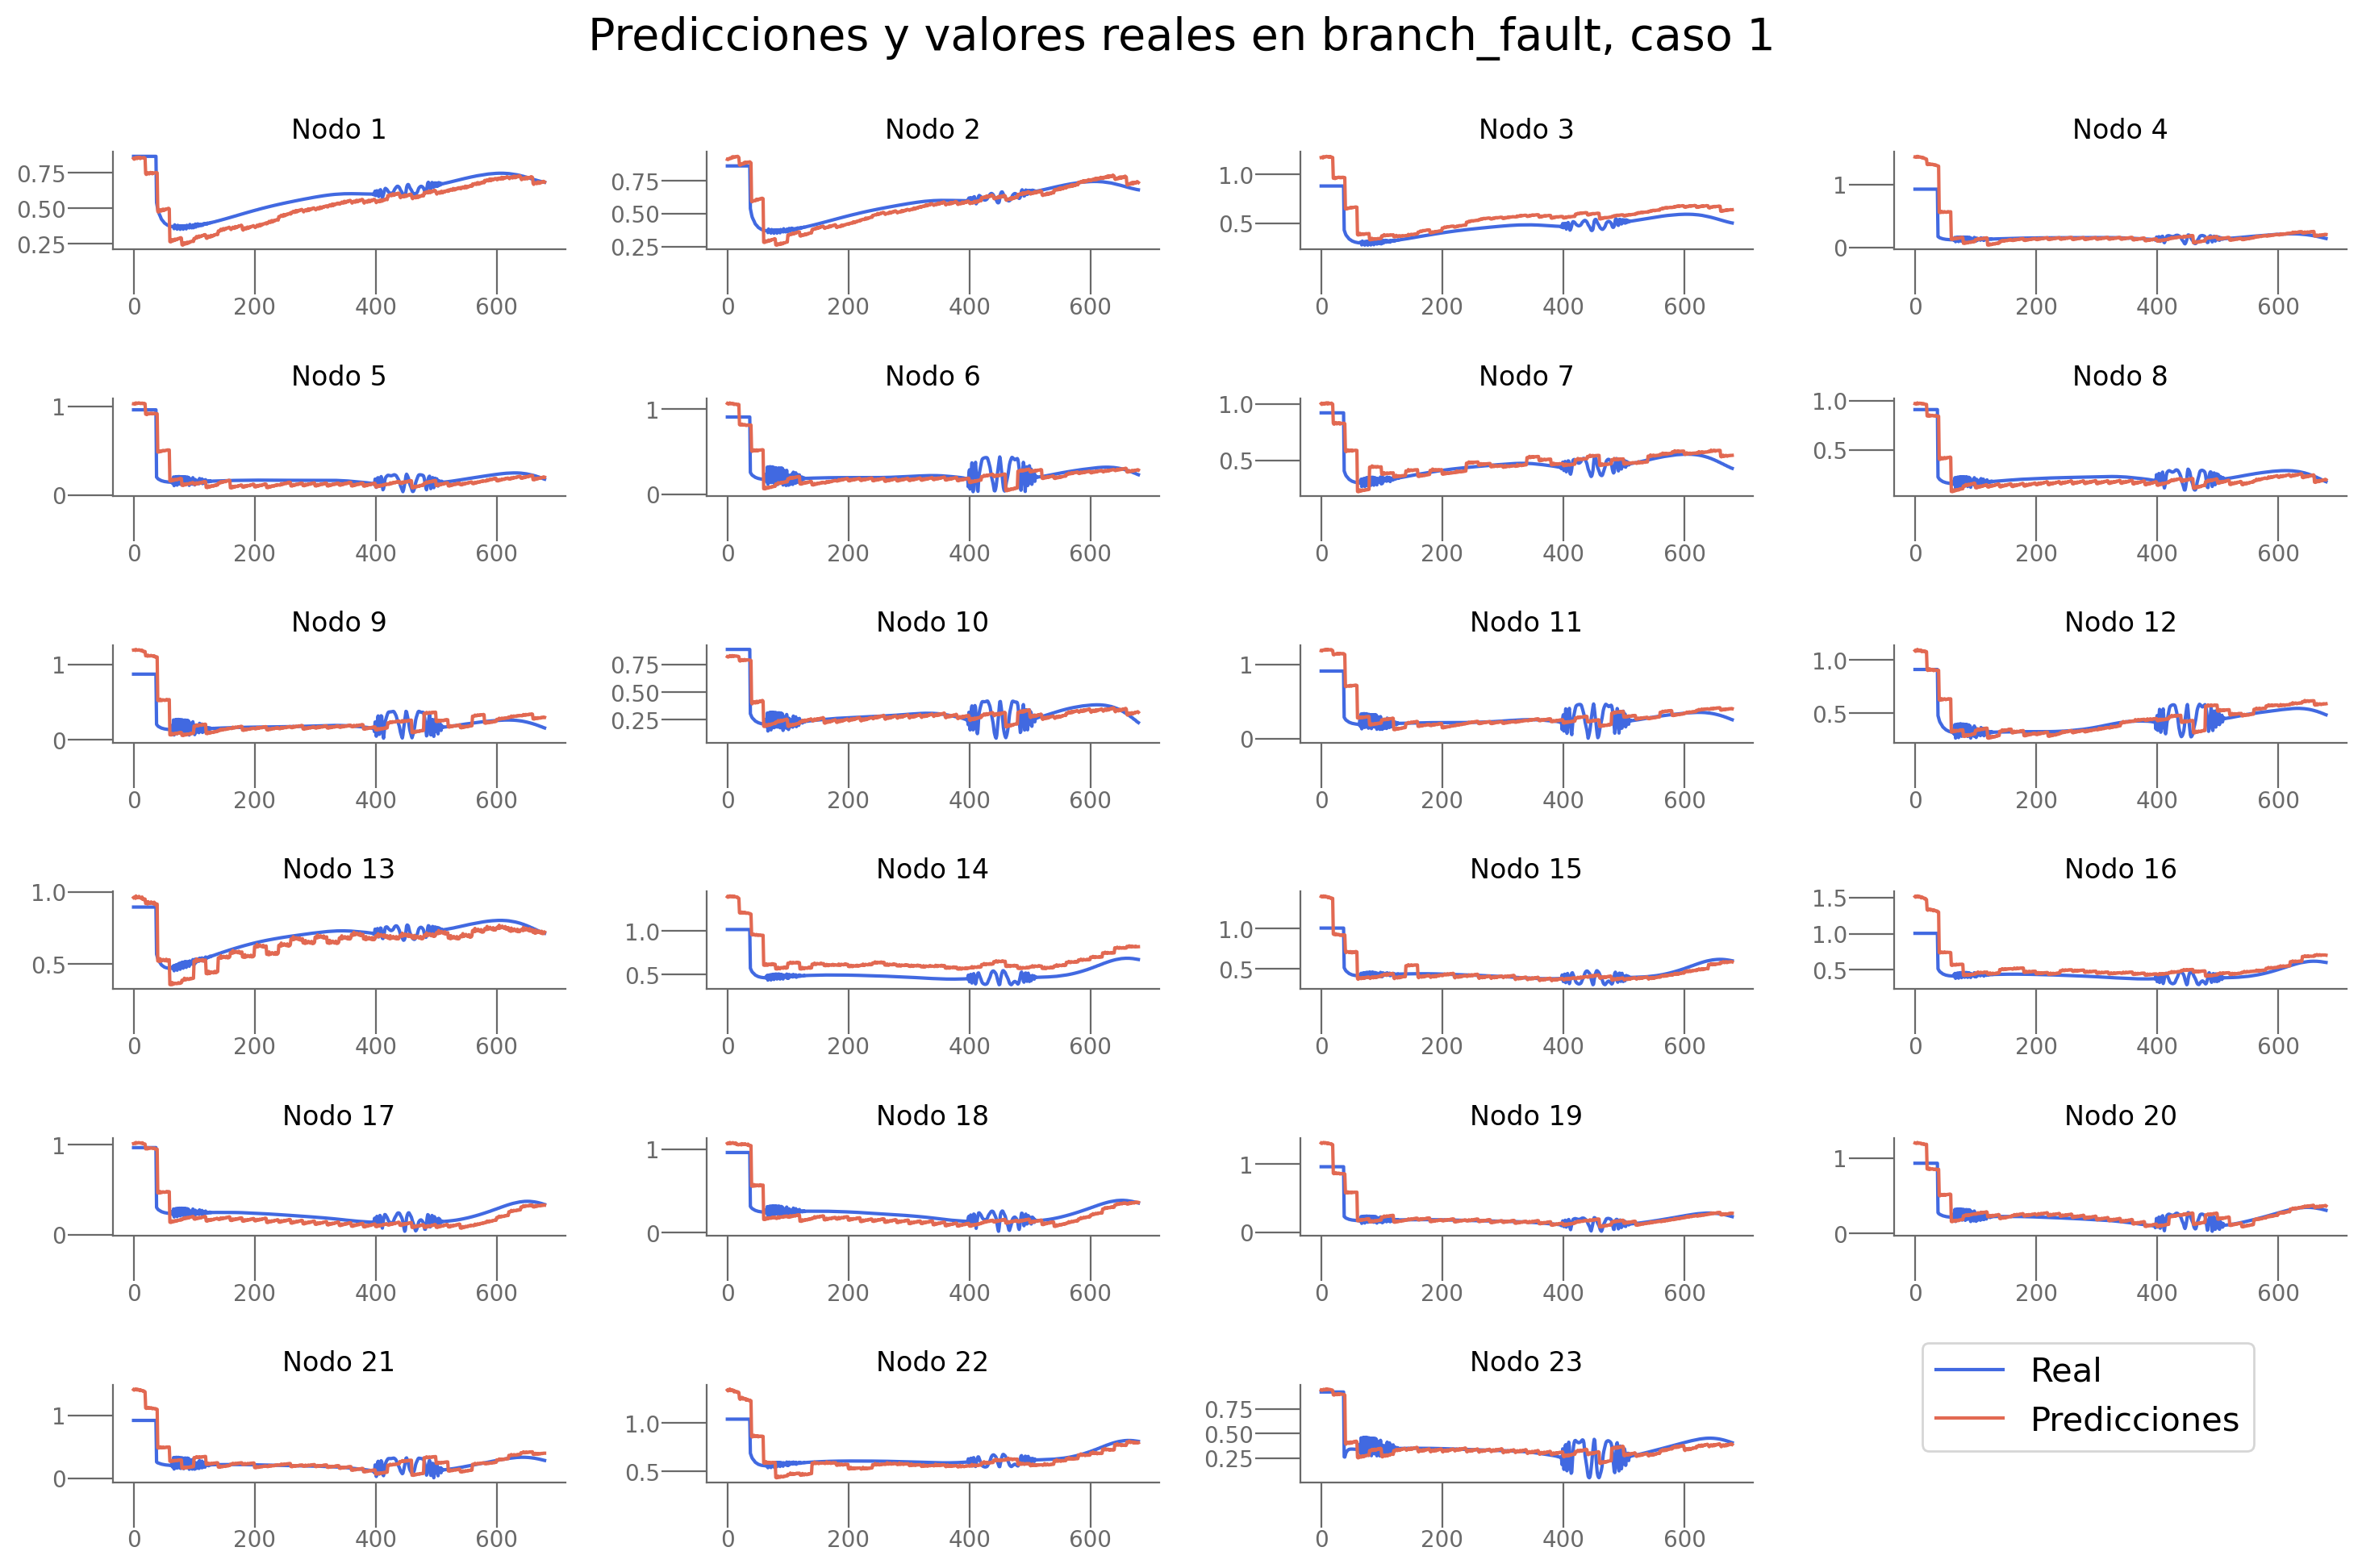

In [32]:
_,_,_, predictions_brf_ajuste,real_brf_ajuste = trainer_brf.test()
plot_predictions(predictions_brf_ajuste, real_brf_ajuste, n_target, 1, n_div_brf, problem_brf)

In [33]:
trainer_brf.save_model(path_save_experiment=path_save_experiment_brf, params = params_brf)


==================== GUARDANDO RESULTADOS ===================

         Modelo                                             Params  \
0          LSTM                                                NaN   
1  LSTM_NOBATCH                                                NaN   
2   DyGrEncoder              {'aggr': 'add', 'conv': 1, 'lstm': 1}   
3     MPNN_LSTM                {'hidden_size': 64, 'dropout': 0.2}   
4        MSTGCN  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_...   
5     EvolveGCN                                                NaN   
6        ASTGCN                                                NaN   
7         DCRNN                                     {'hidden': 60}   
8         AGCRN             {'hidden': 10, 'K': 2, 'embedding': 3}   

                      Fichero_resultados_experimento  Loss_tst     R2_tst  \
0                                                NaN  0.023216   0.608045   
1                                                NaN  0.021628  -1.528487   
2  .

### Branch trip

In [34]:
problem_brt = "branch_trip"
dataset_brt, situations_brt = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem_brt)




Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  101


In [35]:

n_div_brt = loader.div
n_nodes =dataset_brt.features[0].shape[0]
n_target = dataset_brt.targets[0].shape[1]
n_features = dataset_brt[0].x.shape[1]
embedding_dim =5

#### Sencilla 

In [83]:
model_brt = RecurrentGCN(n_features=n_features, n_nodes=n_nodes, embedding_dim=embedding_dim, n_target=n_target, name="AGCRN")
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

model_brt.to(device)
trainer_brt = TrainerAGCRN(model_brt, dataset_brt,device, f"./results/{problem_brt}", dataloader_params2)

losses,eval_losses, r2scores  = trainer_brt.train(num_epochs=num_epochs, steps=200, num_early_stop=num_early_stop)




==================== DATASET INFO ===================

Train dataset: 2385
Validation dataset: 510
Test dataset: 505

==================== DATALOADER INFO ===================

DataLoader for train set:
Number of batches: 477
DataLoader for val set:
Number of batches: 102
DataLoader for test set:
Number of batches: 101

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.1003 | Eval Loss: 0.0262 | Eval R2: -4.0592 | 
Epoch 2/30 | Train Loss: 0.0161 | Eval Loss: 0.0175 | Eval R2: -3.8412 | 
Epoch 3/30 | Train Loss: 0.0110 | Eval Loss: 0.0146 | Eval R2: -3.2269 | 
Epoch 4/30 | Train Loss: 0.0092 | Eval Loss: 0.0136 | Eval R2: -3.1816 | 
Epoch 5/30 | Train Loss: 0.0084 | Eval Loss: 0.0123 | Eval R2: -2.7259 | 
Epoch 6/30 | Train Loss: 0.0078 | Eval Loss: 0.0122 | Eval R2: -2.7709 | 
Epoch 7/30 | Train Loss: 0.0074 | Eval Loss: 0.0110 | Eval R2: -2.1012 | 
Epoch 8/30 | Train Loss: 0.0069 | Eval Loss: 0.0114 | Eval R2: -2.2568 | 
Epoch 9/30 | Train Loss: 0.0068 |

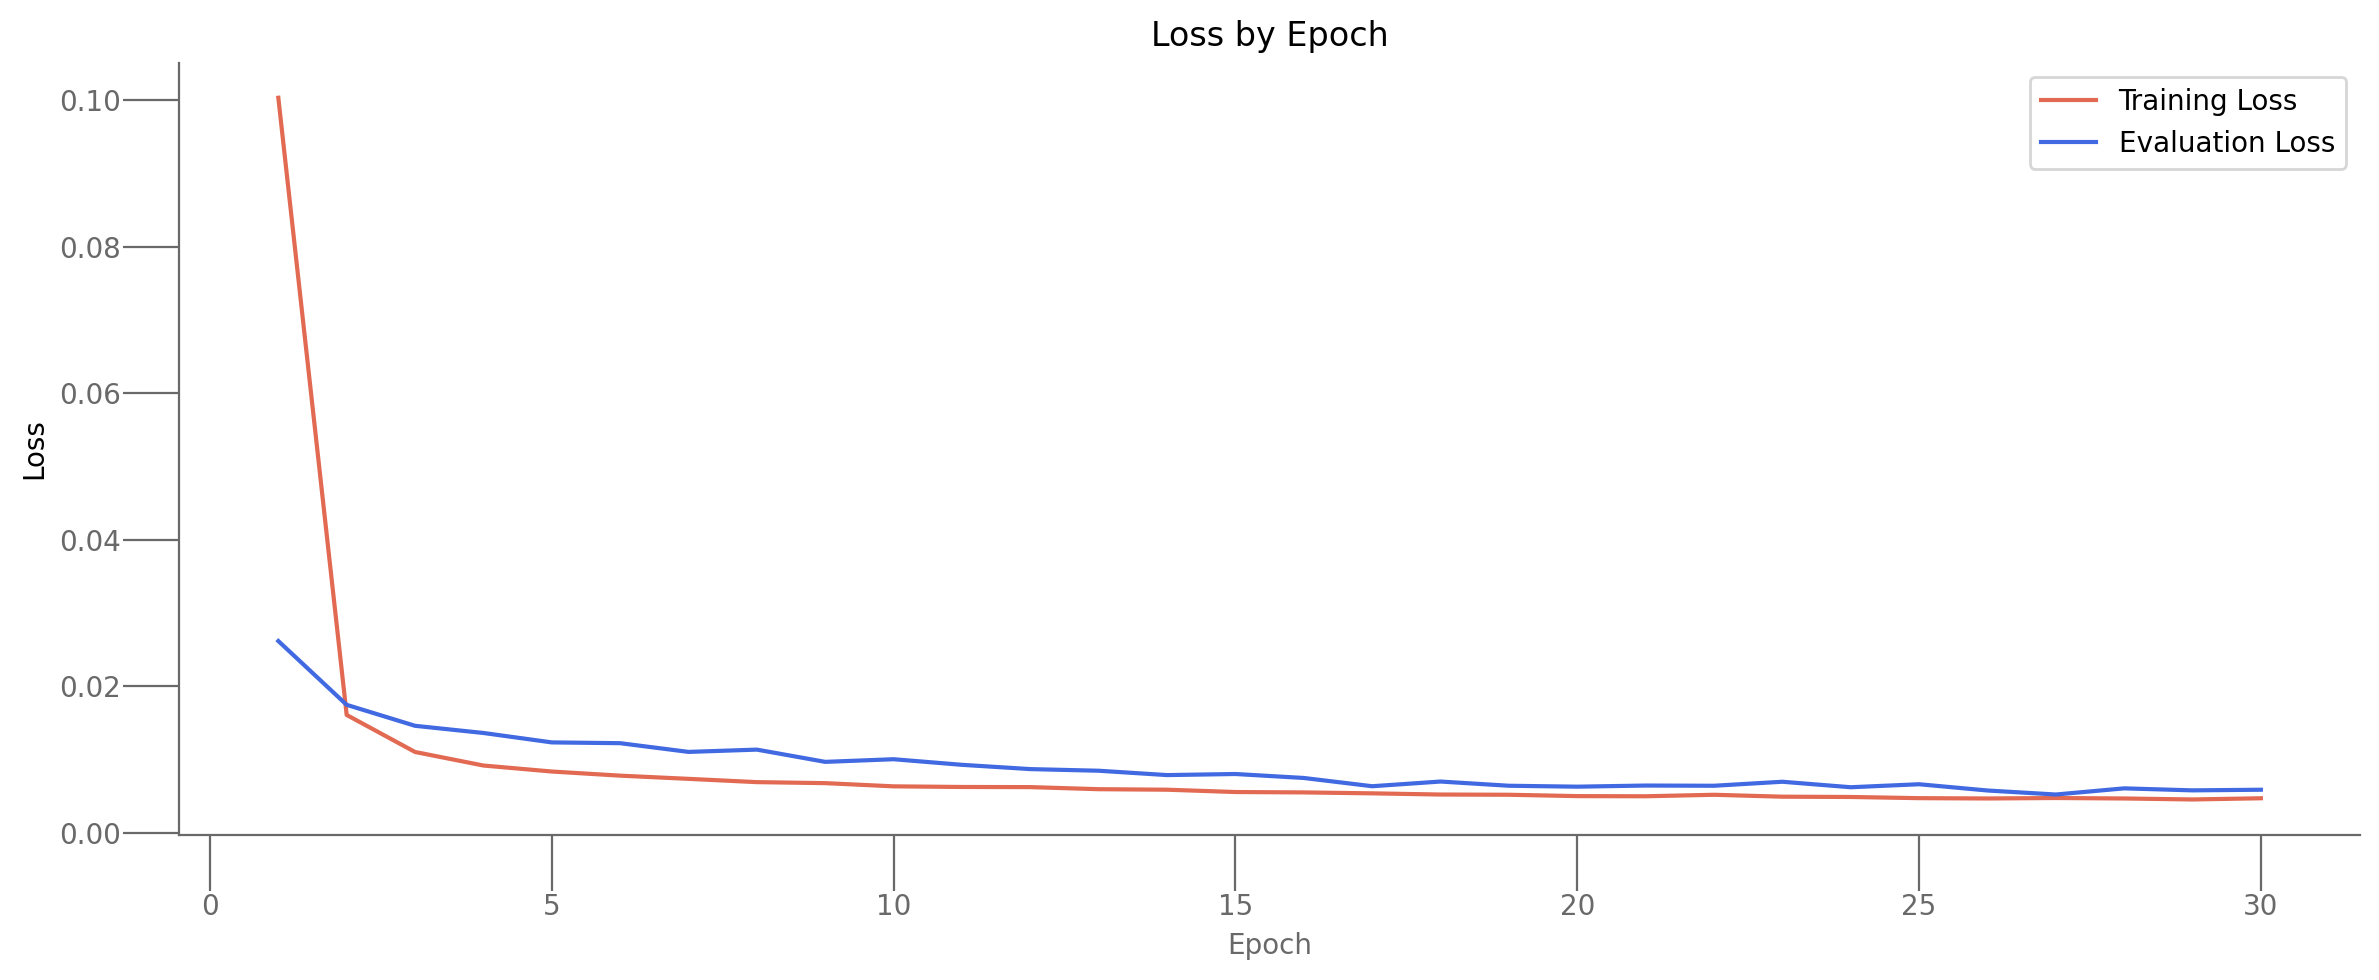


==================== TEST INFO ===================

preds:  (5, 23, 20)
test loss: 0.006017, test r2score -0.386800


In [84]:
plot_training_and_eval_losses(np.array(losses), np.array(eval_losses), num_epochs, format_plot)
losses_tst, r2score_tst, loss_nodes, predictions_brt, real_brt = trainer_brt.test()



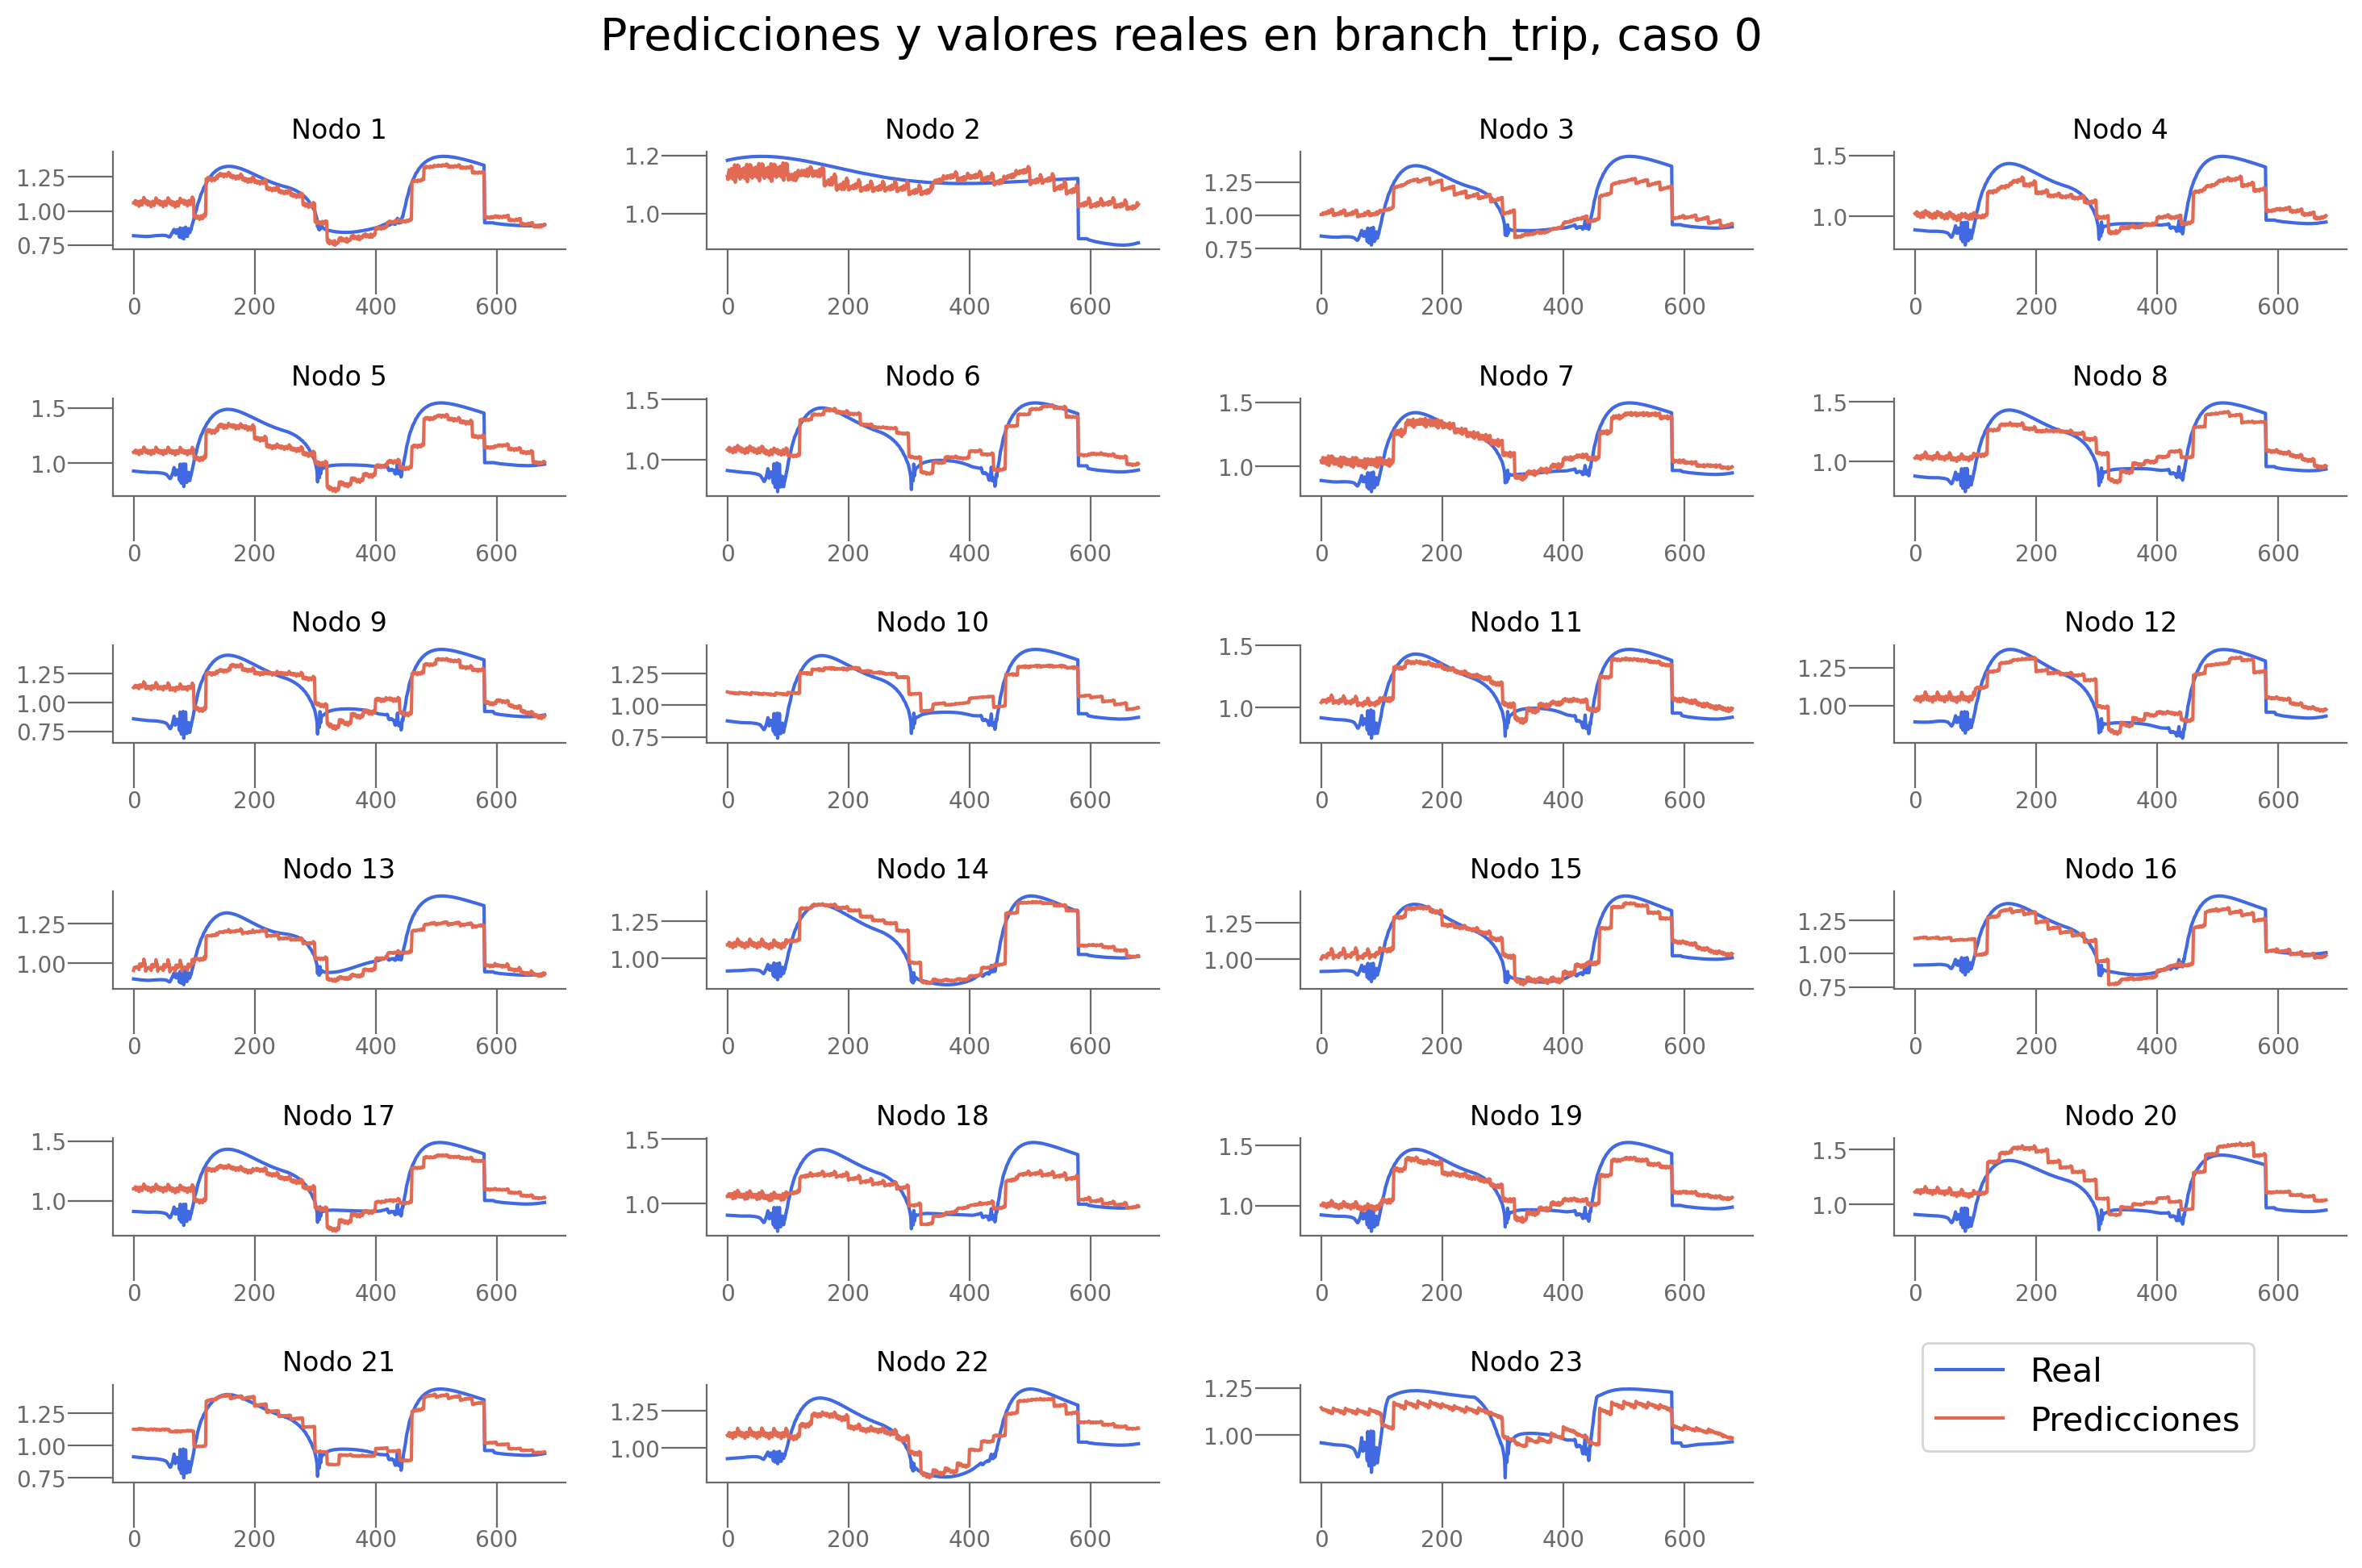

In [85]:
plot_predictions(predictions_brt, real_brt, n_target, 0, n_div_brt, problem_brt)

#### Ajuste de parámetros

In [36]:

trainer_brt,params_brt, resultados_final_brt, resultados_brt = entrenar_y_evaluar_modelos(param_grid, dataset_brt, dataloader_params2, num_early_stop=num_early_stop, num_epochs=num_epochs, problem=problem_brt)

  0%|          | 0/48 [00:00<?, ?it/s]


==================== DATASET INFO ===================

Train dataset: 2380
Validation dataset: 510
Test dataset: 510

==================== DATALOADER INFO ===================

DataLoader for train set:
Number of batches: 476
DataLoader for val set:
Number of batches: 102
DataLoader for test set:
Number of batches: 102

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.2185 | Eval Loss: 0.0428 | Eval R2: -7.2562 | LR: 0.0010 | 
Epoch 2/30 | Train Loss: 0.0295 | Eval Loss: 0.0269 | Eval R2: -4.3193 | LR: 0.0010 | 
Epoch 3/30 | Train Loss: 0.0201 | Eval Loss: 0.0269 | Eval R2: -6.2224 | LR: 0.0010 | 
Epoch 4/30 | Train Loss: 0.0156 | Eval Loss: 0.0189 | Eval R2: -3.9950 | LR: 0.0010 | 
Epoch 5/30 | Train Loss: 0.0130 | Eval Loss: 0.0196 | Eval R2: -4.7520 | LR: 0.0010 | 
Epoch 6/30 | Train Loss: 0.0114 | Eval Loss: 0.0138 | Eval R2: -2.4627 | LR: 0.0010 | 
Epoch 7/30 | Train Loss: 0.0102 | Eval Loss: 0.0126 | Eval R2: -2.2735 | LR: 0.0010 | 
Epoch 8/30 | Tra

  2%|▏         | 1/48 [03:47<2:58:23, 227.74s/it]

preds:  (5, 23, 20)
test loss: 0.006657, test R2 score: -0.324354
Parámetros:  10 2 3
Resultados:  {'Embedding': 3, 'k': 2, 'Hidden': 10, 'Loss_final': 0.005490880459547043, 'R2_eval': -0.1600155383348465, 'Loss_eval': 0.00626506470143795, 'R2_tst': -0.3243540718663043, 'Loss_tst': 0.006657008081674576, 'Loss_nodes': [0.006978441495448351, 0.004459163174033165, 0.012919793836772442, 0.004325479734688997, 0.007191822398453951, 0.00875630509108305, 0.005209658294916153, 0.005106952041387558, 0.008101281709969044, 0.007054403889924288, 0.008503787219524384, 0.004987228196114302, 0.004764442332088947, 0.00985098909586668, 0.005601966287940741, 0.00619445601478219, 0.005191686563193798, 0.006062777247279882, 0.006296602077782154, 0.008756671100854874, 0.007455163635313511, 0.00507161021232605, 0.004270527977496386]}

==================== DATASET INFO ===================

Train dataset: 2380
Validation dataset: 510
Test dataset: 510

==================== DATALOADER INFO ===================



  4%|▍         | 2/48 [07:49<3:00:53, 235.95s/it]

preds:  (5, 23, 20)
test loss: 0.007644, test R2 score: -0.742300
Parámetros:  10 3 3
Resultados:  {'Embedding': 3, 'k': 3, 'Hidden': 10, 'Loss_final': 0.006391224451363087, 'R2_eval': -0.6449180245399475, 'Loss_eval': 0.007429184857755899, 'R2_tst': -0.7422998603313637, 'Loss_tst': 0.007644194643944502, 'Loss_nodes': [0.005272659007459879, 0.0026218516286462545, 0.007412482053041458, 0.0065409354865550995, 0.007900620810687542, 0.009817201644182205, 0.007078468333929777, 0.008058356121182442, 0.007841079495847225, 0.009102706797420979, 0.007779825944453478, 0.00472286157310009, 0.005067838821560144, 0.006921769585460424, 0.009317861869931221, 0.00864050630480051, 0.007604867219924927, 0.0060906484723091125, 0.008788242004811764, 0.012140774168074131, 0.013314086943864822, 0.007762810215353966, 0.006018010899424553]}

==================== DATASET INFO ===================

Train dataset: 2380
Validation dataset: 510
Test dataset: 510

==================== DATALOADER INFO ===============

  6%|▋         | 3/48 [12:03<3:03:08, 244.19s/it]

preds:  (5, 23, 20)
test loss: 0.006807, test R2 score: -0.423569
Parámetros:  10 4 3
Resultados:  {'Embedding': 3, 'k': 4, 'Hidden': 10, 'Loss_final': 0.005661830771714449, 'R2_eval': -0.14131125807762146, 'Loss_eval': 0.006989736109972, 'R2_tst': -0.4235685562980215, 'Loss_tst': 0.00680724298581481, 'Loss_nodes': [0.004201402887701988, 0.003499755170196295, 0.0075396341271698475, 0.0075377109460532665, 0.008774659596383572, 0.008233441039919853, 0.006536740809679031, 0.0058659897185862064, 0.01158201601356268, 0.008469317108392715, 0.008787073194980621, 0.004340877756476402, 0.004770959727466106, 0.006070105824619532, 0.007753709796816111, 0.005278225056827068, 0.005488178227096796, 0.007596155162900686, 0.007719336077570915, 0.008098814636468887, 0.007671267259865999, 0.0047135003842413425, 0.006037724204361439]}

==================== DATASET INFO ===================

Train dataset: 2380
Validation dataset: 510
Test dataset: 510

==================== DATALOADER INFO ================

  8%|▊         | 4/48 [15:32<2:48:59, 230.43s/it]

preds:  (5, 23, 20)
test loss: 0.008321, test R2 score: -1.388439
Parámetros:  20 2 3
Resultados:  {'Embedding': 3, 'k': 2, 'Hidden': 20, 'Loss_final': 0.0041356440633535385, 'R2_eval': -1.2092617750167847, 'Loss_eval': 0.00879666768014431, 'R2_tst': -1.3884390504186759, 'Loss_tst': 0.00832109060138464, 'Loss_nodes': [0.003620325354859233, 0.005843253340572119, 0.006015756633132696, 0.007164931856095791, 0.014090359210968018, 0.008277571760118008, 0.006107280496507883, 0.0064511955715715885, 0.023916251957416534, 0.011509175412356853, 0.007212393917143345, 0.0039001761469990015, 0.0029324234928935766, 0.0097318971529603, 0.009497622959315777, 0.00665027741342783, 0.004849327728152275, 0.010951455682516098, 0.006541634444147348, 0.011545740067958832, 0.009720568545162678, 0.008447183296084404, 0.006408278830349445]}

==================== DATASET INFO ===================

Train dataset: 2380
Validation dataset: 510
Test dataset: 510

==================== DATALOADER INFO =================

 10%|█         | 5/48 [19:52<2:52:46, 241.08s/it]

preds:  (5, 23, 20)
test loss: 0.011155, test R2 score: -2.395496
Parámetros:  20 3 3
Resultados:  {'Embedding': 3, 'k': 3, 'Hidden': 20, 'Loss_final': 0.004374469164758921, 'R2_eval': -2.401205062866211, 'Loss_eval': 0.012126483023166656, 'R2_tst': -2.395495975301076, 'Loss_tst': 0.011155295185744762, 'Loss_nodes': [0.0067344470880925655, 0.012759757228195667, 0.012894885614514351, 0.0067666638642549515, 0.008271320722997189, 0.01325034350156784, 0.014027089811861515, 0.011427784338593483, 0.008597602136433125, 0.027328480035066605, 0.013373770751059055, 0.006500429939478636, 0.004591332282871008, 0.007010621018707752, 0.009538854472339153, 0.007631047163158655, 0.0076025971211493015, 0.007676044013351202, 0.014649474062025547, 0.023715820163488388, 0.011643209494650364, 0.011562827974557877, 0.009017390199005604]}

==================== DATASET INFO ===================

Train dataset: 2380
Validation dataset: 510
Test dataset: 510

==================== DATALOADER INFO ================

 12%|█▎        | 6/48 [24:24<2:56:09, 251.66s/it]

preds:  (5, 23, 20)
test loss: 0.007446, test R2 score: -0.643599
Parámetros:  20 4 3
Resultados:  {'Embedding': 3, 'k': 4, 'Hidden': 20, 'Loss_final': 0.005022290162742138, 'R2_eval': -0.4773457944393158, 'Loss_eval': 0.008173290640115738, 'R2_tst': -0.6435986882000726, 'Loss_tst': 0.0074455952271819115, 'Loss_nodes': [0.007952189072966576, 0.004179541487246752, 0.005406535230576992, 0.009270128794014454, 0.006647575180977583, 0.009584029205143452, 0.009023512713611126, 0.0076838391833007336, 0.00980156846344471, 0.009506949223577976, 0.009531195275485516, 0.004587708041071892, 0.0036023235879838467, 0.007850073277950287, 0.009045983664691448, 0.005244312342256308, 0.008376551792025566, 0.008143210783600807, 0.0066610416397452354, 0.011617510579526424, 0.006814479827880859, 0.0037649411242455244, 0.006953503470867872]}

==================== DATASET INFO ===================

Train dataset: 2380
Validation dataset: 510
Test dataset: 510

==================== DATALOADER INFO ============

 15%|█▍        | 7/48 [28:40<2:52:47, 252.87s/it]

preds:  (5, 23, 20)
test loss: 0.018803, test R2 score: -4.835081
Parámetros:  50 2 3
Resultados:  {'Embedding': 3, 'k': 2, 'Hidden': 50, 'Loss_final': 0.003787669353187084, 'R2_eval': -5.62403678894043, 'Loss_eval': 0.019875895231962204, 'R2_tst': -4.835081338116576, 'Loss_tst': 0.0188029482960701, 'Loss_nodes': [0.013297955505549908, 0.012375588528811932, 0.011836133897304535, 0.01690402626991272, 0.01094552967697382, 0.02386127971112728, 0.01860726624727249, 0.021429162472486496, 0.014813427813351154, 0.019019536674022675, 0.015153400599956512, 0.007598767522722483, 0.018715383484959602, 0.02359173074364662, 0.04094455763697624, 0.027611788362264633, 0.012818465940654278, 0.01476647611707449, 0.011271733790636063, 0.0349990539252758, 0.031613223254680634, 0.016557488590478897, 0.013735858723521233]}

==================== DATASET INFO ===================

Train dataset: 2380
Validation dataset: 510
Test dataset: 510

==================== DATALOADER INFO ===================

DataLoade

 17%|█▋        | 8/48 [33:38<2:58:14, 267.35s/it]

preds:  (5, 23, 20)
test loss: 0.012214, test R2 score: -2.399542
Parámetros:  50 3 3
Resultados:  {'Embedding': 3, 'k': 3, 'Hidden': 50, 'Loss_final': 0.0048333825543522835, 'R2_eval': -2.6281659603118896, 'Loss_eval': 0.013298749923706055, 'R2_tst': -2.39954244242889, 'Loss_tst': 0.012214219197630882, 'Loss_nodes': [0.005286307539790869, 0.008714421652257442, 0.021523108705878258, 0.007006245665252209, 0.01095001120120287, 0.014445372857153416, 0.012648221105337143, 0.01661542057991028, 0.011576843447983265, 0.009971769526600838, 0.01357601210474968, 0.008916973136365414, 0.008371366187930107, 0.029364977031946182, 0.014285331591963768, 0.007244692649692297, 0.018381690606474876, 0.006434672046452761, 0.01509071420878172, 0.011586570180952549, 0.012797494418919086, 0.008597515523433685, 0.007541298400610685]}

==================== DATASET INFO ===================

Train dataset: 2380
Validation dataset: 510
Test dataset: 510

==================== DATALOADER INFO ===================



 19%|█▉        | 9/48 [39:12<3:07:15, 288.09s/it]

preds:  (5, 23, 20)
test loss: 0.011041, test R2 score: -2.174489
Parámetros:  50 4 3
Resultados:  {'Embedding': 3, 'k': 4, 'Hidden': 50, 'Loss_final': 0.005073112901300192, 'R2_eval': -1.977396845817566, 'Loss_eval': 0.012038697488605976, 'R2_tst': -2.1744893683849025, 'Loss_tst': 0.011041002348065376, 'Loss_nodes': [0.01011977344751358, 0.006451232358813286, 0.008021516725420952, 0.008041225373744965, 0.006272603292018175, 0.01510996650904417, 0.015323009341955185, 0.013655622489750385, 0.01631019078195095, 0.017140179872512817, 0.00787086971104145, 0.010535106062889099, 0.010026871226727962, 0.011058908887207508, 0.01453267689794302, 0.006359408143907785, 0.012365707196295261, 0.012797677889466286, 0.01211309153586626, 0.014605306088924408, 0.009271923452615738, 0.007279394660145044, 0.008680766448378563]}

==================== DATASET INFO ===================

Train dataset: 2380
Validation dataset: 510
Test dataset: 510

==================== DATALOADER INFO ===================

Da

 21%|██        | 10/48 [4:35:46<48:21:22, 4581.12s/it]

preds:  (5, 23, 20)
test loss: 0.011796, test R2 score: -2.012667
Parámetros:  100 2 3
Resultados:  {'Embedding': 3, 'k': 2, 'Hidden': 100, 'Loss_final': 0.0040853265672922134, 'R2_eval': -1.6542640924453735, 'Loss_eval': 0.012525087222456932, 'R2_tst': -2.0126671707323713, 'Loss_tst': 0.011795831844210625, 'Loss_nodes': [0.008972208946943283, 0.00509714474901557, 0.011654597707092762, 0.009028738364577293, 0.00955590233206749, 0.016305508092045784, 0.018271684646606445, 0.01718803308904171, 0.00962077546864748, 0.022251488640904427, 0.012959664687514305, 0.004501949995756149, 0.010255235247313976, 0.015752892941236496, 0.01693224348127842, 0.00696201715618372, 0.011069548316299915, 0.0061792731285095215, 0.009279465302824974, 0.01837415061891079, 0.009453707374632359, 0.006768593564629555, 0.014869267120957375]}

==================== DATASET INFO ===================

Train dataset: 2380
Validation dataset: 510
Test dataset: 510

==================== DATALOADER INFO ===================

 23%|██▎       | 11/48 [8:07:07<72:33:41, 7060.03s/it]

preds:  (5, 23, 20)
test loss: 0.012678, test R2 score: -2.572890
Parámetros:  100 3 3
Resultados:  {'Embedding': 3, 'k': 3, 'Hidden': 100, 'Loss_final': 0.004517705645412207, 'R2_eval': -2.5228748321533203, 'Loss_eval': 0.01371978223323822, 'R2_tst': -2.5728896570487714, 'Loss_tst': 0.012677609920501709, 'Loss_nodes': [0.020177971571683884, 0.011023139581084251, 0.007336798124015331, 0.010322881862521172, 0.008166658692061901, 0.011974732391536236, 0.010480630211532116, 0.016537809744477272, 0.012356474064290524, 0.02186410315334797, 0.007340523414313793, 0.00537381786853075, 0.011399369686841965, 0.012118208222091198, 0.011404578574001789, 0.020009582862257957, 0.019651787355542183, 0.012078318744897842, 0.008196795359253883, 0.013304155319929123, 0.02047450840473175, 0.004557772073894739, 0.01543441228568554]}

==================== DATASET INFO ===================

Train dataset: 2380
Validation dataset: 510
Test dataset: 510

==================== DATALOADER INFO ===================

 25%|██▌       | 12/48 [8:15:50<50:42:58, 5071.64s/it]

preds:  (5, 23, 20)
test loss: 0.010584, test R2 score: -1.740392
Parámetros:  100 4 3
Resultados:  {'Embedding': 3, 'k': 4, 'Hidden': 100, 'Loss_final': 0.006102934945374727, 'R2_eval': -1.8149865865707397, 'Loss_eval': 0.011723347939550877, 'R2_tst': -1.7403915659843974, 'Loss_tst': 0.010583809576928616, 'Loss_nodes': [0.010820630006492138, 0.004848587792366743, 0.009408307261765003, 0.00881318747997284, 0.014726097695529461, 0.01254012156277895, 0.006979838479310274, 0.014767047949135303, 0.01345363911241293, 0.021032312884926796, 0.010278216563165188, 0.005954686552286148, 0.01047395821660757, 0.008739315904676914, 0.015658985823392868, 0.00804218091070652, 0.009815987199544907, 0.011860397644340992, 0.009649474173784256, 0.012181667611002922, 0.008845259435474873, 0.00792066939175129, 0.006617096718400717]}

==================== DATASET INFO ===================

Train dataset: 2380
Validation dataset: 510
Test dataset: 510

==================== DATALOADER INFO ===================


 27%|██▋       | 13/48 [8:19:37<35:02:16, 3603.89s/it]

preds:  (5, 23, 20)
test loss: 0.007526, test R2 score: -0.984284
Parámetros:  10 2 5
Resultados:  {'Embedding': 5, 'k': 2, 'Hidden': 10, 'Loss_final': 0.004619333893060684, 'R2_eval': -0.8308205604553223, 'Loss_eval': 0.007630595006048679, 'R2_tst': -0.9842841391705054, 'Loss_tst': 0.007525954395532608, 'Loss_nodes': [0.006390186958014965, 0.003962388727813959, 0.006632100325077772, 0.006295476108789444, 0.01643781177699566, 0.006474717520177364, 0.005486362148076296, 0.00524343503639102, 0.007589370012283325, 0.009304788894951344, 0.005318742711097002, 0.005311441142112017, 0.004747684113681316, 0.0034123340155929327, 0.0037660275120288134, 0.009885906241834164, 0.008183583617210388, 0.006974284537136555, 0.015098809264600277, 0.01479866448789835, 0.01210014708340168, 0.004986098501831293, 0.004696572665125132]}

==================== DATASET INFO ===================

Train dataset: 2380
Validation dataset: 510
Test dataset: 510

==================== DATALOADER INFO ==================

 29%|██▉       | 14/48 [8:23:53<24:29:12, 2592.71s/it]

preds:  (5, 23, 20)
test loss: 0.010316, test R2 score: -2.320411
Parámetros:  10 3 5
Resultados:  {'Embedding': 5, 'k': 3, 'Hidden': 10, 'Loss_final': 0.005875741597265005, 'R2_eval': -2.134459972381592, 'Loss_eval': 0.0111253522336483, 'R2_tst': -2.320411485809444, 'Loss_tst': 0.010316092520952225, 'Loss_nodes': [0.010534768924117088, 0.004118295386433601, 0.006655224598944187, 0.01097318809479475, 0.014715085737407207, 0.008561418391764164, 0.006922685541212559, 0.009784458205103874, 0.015159936621785164, 0.015687141567468643, 0.020730923861265182, 0.007137348875403404, 0.009981343522667885, 0.010739680379629135, 0.014627780765295029, 0.005400591529905796, 0.012525553815066814, 0.008812147192656994, 0.006457141600549221, 0.010199378244578838, 0.008662605658173561, 0.010189409367740154, 0.008694062940776348]}

==================== DATASET INFO ===================

Train dataset: 2380
Validation dataset: 510
Test dataset: 510

==================== DATALOADER INFO ===================



 31%|███▏      | 15/48 [8:28:35<17:22:55, 1896.24s/it]

preds:  (5, 23, 20)
test loss: 0.011108, test R2 score: -1.844184
Parámetros:  10 4 5
Resultados:  {'Embedding': 5, 'k': 4, 'Hidden': 10, 'Loss_final': 0.008397583849728107, 'R2_eval': -1.3543676137924194, 'Loss_eval': 0.010048947297036648, 'R2_tst': -1.8441838869242166, 'Loss_tst': 0.011107802391052246, 'Loss_nodes': [0.008025174960494041, 0.018088579177856445, 0.007148825563490391, 0.013074633665382862, 0.010599974542856216, 0.010443780571222305, 0.0058256275951862335, 0.008881330490112305, 0.013253755867481232, 0.012258494272828102, 0.015323183499276638, 0.012962575070559978, 0.011018107645213604, 0.00971092190593481, 0.007255068514496088, 0.007366010919213295, 0.008172192610800266, 0.010292168706655502, 0.01031151507049799, 0.01282770186662674, 0.027509139850735664, 0.008826643228530884, 0.006304036360234022]}

==================== DATASET INFO ===================

Train dataset: 2380
Validation dataset: 510
Test dataset: 510

==================== DATALOADER INFO ==================

 33%|███▎      | 16/48 [8:32:43<12:26:38, 1399.95s/it]

preds:  (5, 23, 20)
test loss: 0.008673, test R2 score: -1.440970
Parámetros:  20 2 5
Resultados:  {'Embedding': 5, 'k': 2, 'Hidden': 20, 'Loss_final': 0.00431863684207201, 'R2_eval': -1.2957220077514648, 'Loss_eval': 0.009254968725144863, 'R2_tst': -1.4409702111871454, 'Loss_tst': 0.00867253728210926, 'Loss_nodes': [0.00542426249012351, 0.0024322913959622383, 0.008485201746225357, 0.007691583596169949, 0.01001366600394249, 0.009066291153430939, 0.005068184807896614, 0.007773946970701218, 0.012693163007497787, 0.015123609453439713, 0.006807475816458464, 0.009615561924874783, 0.003501668805256486, 0.006946071516722441, 0.007290075067430735, 0.00705221900716424, 0.008690573275089264, 0.008380786515772343, 0.016066091135144234, 0.009357192553579807, 0.007690063677728176, 0.011558587662875652, 0.01273979153484106]}

==================== DATASET INFO ===================

Train dataset: 2380
Validation dataset: 510
Test dataset: 510

==================== DATALOADER INFO ===================



 35%|███▌      | 17/48 [8:36:56<9:05:09, 1055.16s/it] 

preds:  (5, 23, 20)
test loss: 0.008983, test R2 score: -1.448704
Parámetros:  20 3 5
Resultados:  {'Embedding': 5, 'k': 3, 'Hidden': 20, 'Loss_final': 0.004851247183978558, 'R2_eval': -1.2852743864059448, 'Loss_eval': 0.00981791689991951, 'R2_tst': -1.4487040840493237, 'Loss_tst': 0.008982795290648937, 'Loss_nodes': [0.006197158247232437, 0.0025252013001590967, 0.014950050972402096, 0.00873592495918274, 0.010861680842936039, 0.007154260296374559, 0.006893770769238472, 0.005959366448223591, 0.010510027408599854, 0.01320179644972086, 0.008851822465658188, 0.006196029484272003, 0.006373107898980379, 0.005828250199556351, 0.010748907923698425, 0.00845839362591505, 0.007106902077794075, 0.02343391254544258, 0.005732187535613775, 0.009667467325925827, 0.011185913346707821, 0.00709692295640707, 0.008935227058827877]}

==================== DATASET INFO ===================

Train dataset: 2380
Validation dataset: 510
Test dataset: 510

==================== DATALOADER INFO ===================



 38%|███▊      | 18/48 [8:41:47<6:52:48, 825.62s/it] 

preds:  (5, 23, 20)
test loss: 0.009827, test R2 score: -1.592529
Parámetros:  20 4 5
Resultados:  {'Embedding': 5, 'k': 4, 'Hidden': 20, 'Loss_final': 0.006533345207571983, 'R2_eval': -1.5454270839691162, 'Loss_eval': 0.011047844775021076, 'R2_tst': -1.5925286260255895, 'Loss_tst': 0.009827127680182457, 'Loss_nodes': [0.005326172336935997, 0.005777989514172077, 0.006345794536173344, 0.015721594914793968, 0.010972023010253906, 0.009650572203099728, 0.007034166716039181, 0.011278485879302025, 0.0201070848852396, 0.010363418608903885, 0.015217243693768978, 0.010182226076722145, 0.010721773840487003, 0.00864067766815424, 0.01151248998939991, 0.007233395706862211, 0.009273692965507507, 0.007136875297874212, 0.009920516051352024, 0.007725740782916546, 0.009805449284613132, 0.009389790706336498, 0.006686762906610966]}

==================== DATASET INFO ===================

Train dataset: 2380
Validation dataset: 510
Test dataset: 510

==================== DATALOADER INFO ===================


 40%|███▉      | 19/48 [8:46:17<5:18:17, 658.54s/it]

preds:  (5, 23, 20)
test loss: 0.014041, test R2 score: -3.307982
Parámetros:  50 2 5
Resultados:  {'Embedding': 5, 'k': 2, 'Hidden': 50, 'Loss_final': 0.0045367516577243805, 'R2_eval': -3.6203808784484863, 'Loss_eval': 0.01516397763043642, 'R2_tst': -3.307982412048128, 'Loss_tst': 0.014040648937225342, 'Loss_nodes': [0.014495602808892727, 0.0027192162815481424, 0.004195253364741802, 0.0164538212120533, 0.021103650331497192, 0.014491795562207699, 0.0070594982244074345, 0.008515162393450737, 0.029492875561118126, 0.02663140743970871, 0.009813354350626469, 0.010095721110701561, 0.013266674242913723, 0.017642848193645477, 0.010733656585216522, 0.011666640639305115, 0.014363016933202744, 0.030269643291831017, 0.011457226239144802, 0.012013278901576996, 0.00991585198789835, 0.012116112746298313, 0.01442264299839735]}

==================== DATASET INFO ===================

Train dataset: 2380
Validation dataset: 510
Test dataset: 510

==================== DATALOADER INFO ===================


 42%|████▏     | 20/48 [8:51:36<4:19:47, 556.68s/it]

preds:  (5, 23, 20)
test loss: 0.008126, test R2 score: -0.790592
Parámetros:  50 3 5
Resultados:  {'Embedding': 5, 'k': 3, 'Hidden': 50, 'Loss_final': 0.005404702853411436, 'R2_eval': -0.634216845035553, 'Loss_eval': 0.008906693197786808, 'R2_tst': -0.7905915729680029, 'Loss_tst': 0.008126071654260159, 'Loss_nodes': [0.006285013165324926, 0.0045327856205403805, 0.008544201031327248, 0.007952407002449036, 0.009103143587708473, 0.014120380394160748, 0.00625483738258481, 0.008085762150585651, 0.011562039144337177, 0.009194680489599705, 0.009836646728217602, 0.006084864027798176, 0.006526355165988207, 0.0071063898503780365, 0.005948515143245459, 0.008962721563875675, 0.010670396499335766, 0.008875272236764431, 0.007874812930822372, 0.008114926517009735, 0.00783973466604948, 0.0063102697022259235, 0.007113501895219088]}

==================== DATASET INFO ===================

Train dataset: 2380
Validation dataset: 510
Test dataset: 510

==================== DATALOADER INFO ================

 44%|████▍     | 21/48 [8:57:31<3:43:17, 496.19s/it]

preds:  (5, 23, 20)
test loss: 0.007953, test R2 score: -0.764467
Parámetros:  50 4 5
Resultados:  {'Embedding': 5, 'k': 4, 'Hidden': 50, 'Loss_final': 0.006499030627310276, 'R2_eval': -0.4824517071247101, 'Loss_eval': 0.008635084144771099, 'R2_tst': -0.7644671321273816, 'Loss_tst': 0.007953050546348095, 'Loss_nodes': [0.011379755102097988, 0.005025915801525116, 0.005038597621023655, 0.007773056160658598, 0.010515245608985424, 0.007984528318047523, 0.007576623931527138, 0.008648527786135674, 0.010060816071927547, 0.010586550459265709, 0.01017205510288477, 0.0065335724502801895, 0.007040426600724459, 0.006828376557677984, 0.008301392197608948, 0.007218535523861647, 0.007925807498395443, 0.0074115414172410965, 0.0077453600242733955, 0.008417339064180851, 0.009491544216871262, 0.005733436439186335, 0.0055111669935286045]}

==================== DATASET INFO ===================

Train dataset: 2380
Validation dataset: 510
Test dataset: 510

==================== DATALOADER INFO =============

 46%|████▌     | 22/48 [9:03:32<3:17:24, 455.56s/it]

preds:  (5, 23, 20)
test loss: 0.013095, test R2 score: -3.098989
Parámetros:  100 2 5
Resultados:  {'Embedding': 5, 'k': 2, 'Hidden': 100, 'Loss_final': 0.004623355809599161, 'R2_eval': -3.278672456741333, 'Loss_eval': 0.014864425174891949, 'R2_tst': -3.098988507614041, 'Loss_tst': 0.013095403090119362, 'Loss_nodes': [0.01327106449753046, 0.010768822394311428, 0.004142025951296091, 0.00934648234397173, 0.017808005213737488, 0.009388884529471397, 0.008987524546682835, 0.007029624190181494, 0.017724113538861275, 0.020327594131231308, 0.00871228240430355, 0.01083683967590332, 0.00966313574463129, 0.008568109944462776, 0.007909201085567474, 0.021038707345724106, 0.011751784011721611, 0.012444082647562027, 0.010272281244397163, 0.018610071390867233, 0.03908795490860939, 0.013312863186001778, 0.010192807763814926]}

==================== DATASET INFO ===================

Train dataset: 2380
Validation dataset: 510
Test dataset: 510

==================== DATALOADER INFO ===================

D

 48%|████▊     | 23/48 [9:10:43<3:06:46, 448.25s/it]

preds:  (5, 23, 20)
test loss: 0.008746, test R2 score: -1.065291
Parámetros:  100 3 5
Resultados:  {'Embedding': 5, 'k': 3, 'Hidden': 100, 'Loss_final': 0.006144472397863865, 'R2_eval': -1.1537975072860718, 'Loss_eval': 0.009987740777432919, 'R2_tst': -1.0652908469231672, 'Loss_tst': 0.008746354840695858, 'Loss_nodes': [0.0077764056622982025, 0.004880243446677923, 0.005994581617414951, 0.00821939017623663, 0.011454835534095764, 0.009607452899217606, 0.006033031269907951, 0.010525472462177277, 0.009716138243675232, 0.011712380684912205, 0.007818718440830708, 0.007869179360568523, 0.0051016719080507755, 0.005438628606498241, 0.006768426392227411, 0.010918744839727879, 0.01011019479483366, 0.012163184583187103, 0.011807260103523731, 0.009508095681667328, 0.009559266269207, 0.008332544006407261, 0.009850318543612957]}

==================== DATASET INFO ===================

Train dataset: 2380
Validation dataset: 510
Test dataset: 510

==================== DATALOADER INFO =================

 50%|█████     | 24/48 [9:18:52<3:04:12, 460.53s/it]

preds:  (5, 23, 20)
test loss: 0.009278, test R2 score: -1.345589
Parámetros:  100 4 5
Resultados:  {'Embedding': 5, 'k': 4, 'Hidden': 100, 'Loss_final': 0.006553551647812128, 'R2_eval': -1.185986042022705, 'Loss_eval': 0.01043425127863884, 'R2_tst': -1.3455891885164664, 'Loss_tst': 0.0092783747240901, 'Loss_nodes': [0.00797228328883648, 0.006665165536105633, 0.006372937001287937, 0.009416627697646618, 0.010704942047595978, 0.010824709199368954, 0.009980798698961735, 0.00875051785260439, 0.012093276716768742, 0.009543035179376602, 0.00839234609156847, 0.007313037756830454, 0.006708143744617701, 0.008136969991028309, 0.011987043544650078, 0.0076609342359006405, 0.010591752827167511, 0.014861955307424068, 0.009425276890397072, 0.008558979257941246, 0.010831452906131744, 0.006359883584082127, 0.010250560939311981]}

==================== DATASET INFO ===================

Train dataset: 2380
Validation dataset: 510
Test dataset: 510

==================== DATALOADER INFO ===================


 52%|█████▏    | 25/48 [9:22:51<2:31:01, 393.97s/it]

preds:  (5, 23, 20)
test loss: 0.007184, test R2 score: -0.901082
Parámetros:  10 2 10
Resultados:  {'Embedding': 10, 'k': 2, 'Hidden': 10, 'Loss_final': 0.004925572779029608, 'R2_eval': -0.7117047905921936, 'Loss_eval': 0.007214086130261421, 'R2_tst': -0.9010822763632182, 'Loss_tst': 0.00718425028026104, 'Loss_nodes': [0.007205933798104525, 0.0034239611122757196, 0.004099323879927397, 0.008657648228108883, 0.009828039444983006, 0.01279856450855732, 0.006017024628818035, 0.009930584579706192, 0.007773949299007654, 0.005612801294773817, 0.008296403102576733, 0.004466783720999956, 0.0033941781148314476, 0.003927651792764664, 0.0047456687316298485, 0.006587436888366938, 0.008915801532566547, 0.0049132914282381535, 0.019891537725925446, 0.007688139099627733, 0.007636410184204578, 0.00402016332373023, 0.005406467244029045]}

==================== DATASET INFO ===================

Train dataset: 2380
Validation dataset: 510
Test dataset: 510

==================== DATALOADER INFO =============

 54%|█████▍    | 26/48 [9:26:42<2:06:31, 345.07s/it]

preds:  (5, 23, 20)
test loss: 0.009116, test R2 score: -1.550253
Parámetros:  10 3 10
Resultados:  {'Embedding': 10, 'k': 3, 'Hidden': 10, 'Loss_final': 0.0061125373467803, 'R2_eval': -1.2443599700927734, 'Loss_eval': 0.009962151758372784, 'R2_tst': -1.5502529523852826, 'Loss_tst': 0.009115820750594139, 'Loss_nodes': [0.009266491048038006, 0.005913544911891222, 0.009102684445679188, 0.008429717272520065, 0.013744430616497993, 0.009713923558592796, 0.009557204321026802, 0.00929319392889738, 0.01096004992723465, 0.01269946526736021, 0.010611144825816154, 0.010354352183640003, 0.011066892184317112, 0.0071204411797225475, 0.011940510012209415, 0.008702673017978668, 0.007849186658859253, 0.006031338591128588, 0.011087067425251007, 0.00707921152934432, 0.008757241070270538, 0.004034014884382486, 0.0063491142354905605]}

==================== DATASET INFO ===================

Train dataset: 2380
Validation dataset: 510
Test dataset: 510

==================== DATALOADER INFO ==================

 56%|█████▋    | 27/48 [9:30:58<1:51:26, 318.38s/it]

preds:  (5, 23, 20)
test loss: 0.017988, test R2 score: -4.352521
Parámetros:  10 4 10
Resultados:  {'Embedding': 10, 'k': 4, 'Hidden': 10, 'Loss_final': 0.010076564736664295, 'R2_eval': -3.6260437965393066, 'Loss_eval': 0.017310505732893944, 'R2_tst': -4.352520779160103, 'Loss_tst': 0.017988400533795357, 'Loss_nodes': [0.02520342729985714, 0.006474340800195932, 0.01245230995118618, 0.02617797628045082, 0.01705869473516941, 0.011843865737318993, 0.013335405848920345, 0.017290383577346802, 0.017417429015040398, 0.013907155953347683, 0.022897236049175262, 0.02238515578210354, 0.013008425943553448, 0.01434914767742157, 0.01307789795100689, 0.01623285561800003, 0.0204838365316391, 0.015891848132014275, 0.05785032734274864, 0.019145704805850983, 0.01889493688941002, 0.010292604565620422, 0.008062231354415417]}

==================== DATASET INFO ===================

Train dataset: 2380
Validation dataset: 510
Test dataset: 510

==================== DATALOADER INFO ===================

DataLo

 58%|█████▊    | 28/48 [9:34:53<1:37:44, 293.22s/it]

preds:  (5, 23, 20)
test loss: 0.008050, test R2 score: -0.964987
Parámetros:  20 2 10
Resultados:  {'Embedding': 10, 'k': 2, 'Hidden': 20, 'Loss_final': 0.005165111273527145, 'R2_eval': -0.7163004279136658, 'Loss_eval': 0.008438359014689922, 'R2_tst': -0.9649874042583246, 'Loss_tst': 0.008050362579524517, 'Loss_nodes': [0.005504647269845009, 0.0024706672411412, 0.012304947711527348, 0.008462445810437202, 0.01611684076488018, 0.008838032372295856, 0.008524026721715927, 0.01303364522755146, 0.008675603196024895, 0.00740817328915, 0.009105640463531017, 0.007751992903649807, 0.004195997957140207, 0.0064799548126757145, 0.009158656001091003, 0.006181106902658939, 0.008223925717175007, 0.004729727748781443, 0.00802554003894329, 0.008111783303320408, 0.0060942028649151325, 0.0043451907113194466, 0.011415593326091766]}

==================== DATASET INFO ===================

Train dataset: 2380
Validation dataset: 510
Test dataset: 510

==================== DATALOADER INFO ===================


 60%|██████    | 29/48 [9:39:16<1:30:00, 284.21s/it]

preds:  (5, 23, 20)
test loss: 0.013918, test R2 score: -3.754533
Parámetros:  20 3 10
Resultados:  {'Embedding': 10, 'k': 3, 'Hidden': 20, 'Loss_final': 0.006632051896303892, 'R2_eval': -3.863962411880493, 'Loss_eval': 0.015339783392846584, 'R2_tst': -3.754533395316791, 'Loss_tst': 0.013918216340243816, 'Loss_nodes': [0.019286418333649635, 0.009737449698150158, 0.009713375940918922, 0.018251586705446243, 0.015880431979894638, 0.01190019492059946, 0.018641622737050056, 0.01527373120188713, 0.012177723459899426, 0.01981647126376629, 0.01530730351805687, 0.015370075590908527, 0.008196852169930935, 0.007080481853336096, 0.00970310065895319, 0.012970609590411186, 0.007897608913481236, 0.008348271250724792, 0.018869586288928986, 0.014351828023791313, 0.027598325163125992, 0.013565020635724068, 0.010180903598666191]}

==================== DATASET INFO ===================

Train dataset: 2380
Validation dataset: 510
Test dataset: 510

==================== DATALOADER INFO ===================



 62%|██████▎   | 30/48 [9:43:38<1:23:15, 277.51s/it]

preds:  (5, 23, 20)
test loss: 0.010627, test R2 score: -1.911724
Parámetros:  20 4 10
Resultados:  {'Embedding': 10, 'k': 4, 'Hidden': 20, 'Loss_final': 0.00761569244787097, 'R2_eval': -1.6159411668777466, 'Loss_eval': 0.01124077569693327, 'R2_tst': -1.9117239706129214, 'Loss_tst': 0.010627452284097672, 'Loss_nodes': [0.012513058260083199, 0.011168179102241993, 0.01382228173315525, 0.00895875133574009, 0.012785164639353752, 0.01648973487317562, 0.007722696289420128, 0.01049733255058527, 0.011649549007415771, 0.007709813304245472, 0.01242207270115614, 0.014301729388535023, 0.013492914848029613, 0.006917757913470268, 0.006555346306413412, 0.007850393652915955, 0.008269693702459335, 0.007337607443332672, 0.018076784908771515, 0.008914641104638577, 0.011071507818996906, 0.008449717424809933, 0.007454670965671539]}

==================== DATASET INFO ===================

Train dataset: 2380
Validation dataset: 510
Test dataset: 510

==================== DATALOADER INFO ===================



 65%|██████▍   | 31/48 [9:47:56<1:16:58, 271.66s/it]

preds:  (5, 23, 20)
test loss: 0.009297, test R2 score: -1.410482
Parámetros:  50 2 10
Resultados:  {'Embedding': 10, 'k': 2, 'Hidden': 50, 'Loss_final': 0.00560959056019783, 'R2_eval': -1.2016855478286743, 'Loss_eval': 0.009879034012556076, 'R2_tst': -1.410482375392826, 'Loss_tst': 0.00929728802293539, 'Loss_nodes': [0.006089208647608757, 0.011470855213701725, 0.011240827850997448, 0.00767404492944479, 0.01653330773115158, 0.016520611941814423, 0.01165912114083767, 0.008238419890403748, 0.010979623533785343, 0.01809115894138813, 0.010276967659592628, 0.0052258968353271484, 0.004553699400275946, 0.005304707679897547, 0.010095413774251938, 0.012525911442935467, 0.005812993273139, 0.007068213075399399, 0.0080829206854105, 0.006602612789720297, 0.007899966090917587, 0.006783412303775549, 0.005107730161398649]}

==================== DATASET INFO ===================

Train dataset: 2380
Validation dataset: 510
Test dataset: 510

==================== DATALOADER INFO ===================

Data

 67%|██████▋   | 32/48 [9:53:17<1:16:23, 286.48s/it]

preds:  (5, 23, 20)
test loss: 0.010386, test R2 score: -1.516867
Parámetros:  50 3 10
Resultados:  {'Embedding': 10, 'k': 3, 'Hidden': 50, 'Loss_final': 0.0063818977214396, 'R2_eval': -1.3771933317184448, 'Loss_eval': 0.01137880701571703, 'R2_tst': -1.5168671121029074, 'Loss_tst': 0.010385962203145027, 'Loss_nodes': [0.005597379989922047, 0.007529939990490675, 0.012415138073265553, 0.00971116404980421, 0.014618408866226673, 0.01270067598670721, 0.006869039032608271, 0.011296102777123451, 0.011914505623281002, 0.010378061793744564, 0.010594685561954975, 0.01223831158131361, 0.008567507378757, 0.013343481346964836, 0.008127600885927677, 0.010027999058365822, 0.012937101535499096, 0.011761403642594814, 0.013016159646213055, 0.009343155659735203, 0.015896832570433617, 0.004431919660419226, 0.0055605326779186726]}

==================== DATASET INFO ===================

Train dataset: 2380
Validation dataset: 510
Test dataset: 510

==================== DATALOADER INFO ===================

D

 69%|██████▉   | 33/48 [9:59:01<1:15:58, 303.90s/it]

preds:  (5, 23, 20)
test loss: 0.011371, test R2 score: -1.880477
Parámetros:  50 4 10
Resultados:  {'Embedding': 10, 'k': 4, 'Hidden': 50, 'Loss_final': 0.007723329588770866, 'R2_eval': -1.5191574096679688, 'Loss_eval': 0.012099869549274445, 'R2_tst': -1.8804766409589646, 'Loss_tst': 0.011370874010026455, 'Loss_nodes': [0.009021000005304813, 0.006048445124179125, 0.010473828762769699, 0.00886630080640316, 0.011131285689771175, 0.01870441995561123, 0.013679523020982742, 0.010696511715650558, 0.01374603807926178, 0.020598310977220535, 0.014560227282345295, 0.011045034974813461, 0.007087195757776499, 0.007658779621124268, 0.0076236603781580925, 0.012177553959190845, 0.012132384814321995, 0.014102914370596409, 0.012571990489959717, 0.011805721558630466, 0.012350817210972309, 0.008195682428777218, 0.0072524952702224255]}

==================== DATASET INFO ===================

Train dataset: 2380
Validation dataset: 510
Test dataset: 510

==================== DATALOADER INFO ===============

 71%|███████   | 34/48 [10:05:35<1:17:11, 330.81s/it]

preds:  (5, 23, 20)
test loss: 0.009957, test R2 score: -1.440244
Parámetros:  100 2 10
Resultados:  {'Embedding': 10, 'k': 2, 'Hidden': 100, 'Loss_final': 0.006905659567564726, 'R2_eval': -1.4124598503112793, 'Loss_eval': 0.011259032413363457, 'R2_tst': -1.4402438313496126, 'Loss_tst': 0.009956901893019676, 'Loss_nodes': [0.009999200701713562, 0.004400327336043119, 0.008187073282897472, 0.012775796465575695, 0.009445592761039734, 0.013875160366296768, 0.010244778357446194, 0.009158123284578323, 0.011107404716312885, 0.008730505593121052, 0.010265206918120384, 0.012766406871378422, 0.0070830583572387695, 0.009581681340932846, 0.010938906110823154, 0.010164880193769932, 0.008407099172472954, 0.009905579499900341, 0.017367776483297348, 0.008627750910818577, 0.013552629388868809, 0.006839180830866098, 0.0055846404284238815]}

==================== DATASET INFO ===================

Train dataset: 2380
Validation dataset: 510
Test dataset: 510

==================== DATALOADER INFO ==========

 73%|███████▎  | 35/48 [10:13:42<1:21:49, 377.65s/it]

preds:  (5, 23, 20)
test loss: 0.012013, test R2 score: -2.220573
Parámetros:  100 3 10
Resultados:  {'Embedding': 10, 'k': 3, 'Hidden': 100, 'Loss_final': 0.007209515664726496, 'R2_eval': -2.417973756790161, 'Loss_eval': 0.013636891730129719, 'R2_tst': -2.2205732388447763, 'Loss_tst': 0.01201283372938633, 'Loss_nodes': [0.009336265735328197, 0.004799559246748686, 0.012941403314471245, 0.016996271908283234, 0.015796471387147903, 0.022022824734449387, 0.008580348454415798, 0.013208016753196716, 0.014758750796318054, 0.01625106669962406, 0.011284063570201397, 0.012758750468492508, 0.007739442400634289, 0.007796684745699167, 0.009731498546898365, 0.010409539565443993, 0.009383142925798893, 0.007475428748875856, 0.02133798785507679, 0.014551281929016113, 0.017153920605778694, 0.0046494766138494015, 0.007332989480346441]}

==================== DATASET INFO ===================

Train dataset: 2380
Validation dataset: 510
Test dataset: 510

==================== DATALOADER INFO ===============

 75%|███████▌  | 36/48 [10:23:19<1:27:31, 437.64s/it]

preds:  (5, 23, 20)
test loss: 0.015102, test R2 score: -3.876782
Parámetros:  100 4 10
Resultados:  {'Embedding': 10, 'k': 4, 'Hidden': 100, 'Loss_final': 0.008191433735191822, 'R2_eval': -3.406811475753784, 'Loss_eval': 0.01683614030480385, 'R2_tst': -3.8767819169859137, 'Loss_tst': 0.015102253295481205, 'Loss_nodes': [0.014326627366244793, 0.0067475526593625546, 0.019431546330451965, 0.01502541359513998, 0.01589798368513584, 0.019008377566933632, 0.03162728250026703, 0.023761123418807983, 0.012638941407203674, 0.019967027008533478, 0.013021335005760193, 0.008387690410017967, 0.012279175221920013, 0.011164856143295765, 0.01344049721956253, 0.015669168904423714, 0.016412243247032166, 0.011244003660976887, 0.018736109137535095, 0.01782703958451748, 0.009714009240269661, 0.00971557479351759, 0.011308208107948303]}

==================== DATASET INFO ===================

Train dataset: 2380
Validation dataset: 510
Test dataset: 510

==================== DATALOADER INFO ===================

 77%|███████▋  | 37/48 [10:27:13<1:09:01, 376.51s/it]

preds:  (5, 23, 20)
test loss: 0.010648, test R2 score: -1.848148
Parámetros:  10 2 15
Resultados:  {'Embedding': 15, 'k': 2, 'Hidden': 10, 'Loss_final': 0.0059241680428385735, 'R2_eval': -1.489705204963684, 'Loss_eval': 0.010502328164875507, 'R2_tst': -1.8481480199606437, 'Loss_tst': 0.010647778399288654, 'Loss_nodes': [0.007816690020263195, 0.002429356798529625, 0.006517801899462938, 0.013015514239668846, 0.007827089168131351, 0.00829057116061449, 0.007160374894738197, 0.008015263825654984, 0.010035050101578236, 0.018730713054537773, 0.016254972666502, 0.006007357034832239, 0.005406182259321213, 0.03337138891220093, 0.017254387959837914, 0.0075707947835326195, 0.00860544666647911, 0.00667891139164567, 0.013192675076425076, 0.010574129410088062, 0.012544569559395313, 0.006003144197165966, 0.01159656047821045]}

==================== DATASET INFO ===================

Train dataset: 2380
Validation dataset: 510
Test dataset: 510

==================== DATALOADER INFO ===================



 79%|███████▉  | 38/48 [10:31:07<55:35, 333.55s/it]  

preds:  (5, 23, 20)
test loss: 0.013442, test R2 score: -3.476530
Parámetros:  10 3 15
Resultados:  {'Embedding': 15, 'k': 3, 'Hidden': 10, 'Loss_final': 0.008423827588558197, 'R2_eval': -3.138448476791382, 'Loss_eval': 0.0144070815294981, 'R2_tst': -3.476530197722385, 'Loss_tst': 0.01344179268926382, 'Loss_nodes': [0.010493174195289612, 0.00539533281698823, 0.008398851379752159, 0.016180282458662987, 0.02296464517712593, 0.025420956313610077, 0.015239902772009373, 0.01184360682964325, 0.011492593213915825, 0.009378090500831604, 0.04975389316678047, 0.007187691982835531, 0.008501618169248104, 0.009762133471667767, 0.008538980036973953, 0.01009721402078867, 0.016131361946463585, 0.012081765569746494, 0.01310912985354662, 0.007728148251771927, 0.013702278956770897, 0.0045135305263102055, 0.011246057227253914]}

==================== DATASET INFO ===================

Train dataset: 2380
Validation dataset: 510
Test dataset: 510

==================== DATALOADER INFO ===================

Dat

 81%|████████▏ | 39/48 [10:35:19<46:23, 309.23s/it]

preds:  (5, 23, 20)
test loss: 0.025492, test R2 score: -4.785589
Parámetros:  10 4 15
Resultados:  {'Embedding': 15, 'k': 4, 'Hidden': 10, 'Loss_final': 0.02188056707382202, 'R2_eval': -4.030828952789307, 'Loss_eval': 0.023533320054411888, 'R2_tst': -4.785588707968621, 'Loss_tst': 0.02549169957637787, 'Loss_nodes': [0.009676788933575153, 0.0395023413002491, 0.020663883537054062, 0.015845416113734245, 0.018695440143346786, 0.061561793088912964, 0.018594369292259216, 0.012718908488750458, 0.043728798627853394, 0.020817115902900696, 0.027608107775449753, 0.009162511676549911, 0.021974699571728706, 0.013338801451027393, 0.03161253780126572, 0.021374952048063278, 0.038208167999982834, 0.012853770516812801, 0.0304175466299057, 0.026098651811480522, 0.027533099055290222, 0.03240353614091873, 0.031917840242385864]}

==================== DATASET INFO ===================

Train dataset: 2380
Validation dataset: 510
Test dataset: 510

==================== DATALOADER INFO ===================

Dat

 83%|████████▎ | 40/48 [10:39:13<38:13, 286.63s/it]

preds:  (5, 23, 20)
test loss: 0.010857, test R2 score: -2.219537
Parámetros:  20 2 15
Resultados:  {'Embedding': 15, 'k': 2, 'Hidden': 20, 'Loss_final': 0.006568052340298891, 'R2_eval': -2.2648348808288574, 'Loss_eval': 0.01197510864585638, 'R2_tst': -2.219537174181323, 'Loss_tst': 0.010857227258384228, 'Loss_nodes': [0.00578623590990901, 0.03312022611498833, 0.006307506468147039, 0.009519045241177082, 0.008929501287639141, 0.009755594655871391, 0.010945594869554043, 0.012988965958356857, 0.00982204731553793, 0.012008684687316418, 0.0134999705478549, 0.013187214732170105, 0.007078169379383326, 0.005623445380479097, 0.01356753334403038, 0.005501870531588793, 0.008932961151003838, 0.00904012843966484, 0.014161555096507072, 0.007303562946617603, 0.011562815867364407, 0.0067045544274151325, 0.014369037002325058]}

==================== DATASET INFO ===================

Train dataset: 2380
Validation dataset: 510
Test dataset: 510

==================== DATALOADER INFO ===================

D

 85%|████████▌ | 41/48 [10:43:36<32:37, 279.61s/it]

preds:  (5, 23, 20)
test loss: 0.011797, test R2 score: -2.092228
Parámetros:  20 3 15
Resultados:  {'Embedding': 15, 'k': 3, 'Hidden': 20, 'Loss_final': 0.008625083602964878, 'R2_eval': -1.7914469242095947, 'Loss_eval': 0.012271055020391941, 'R2_tst': -2.0922276857163102, 'Loss_tst': 0.011796711944043636, 'Loss_nodes': [0.009508686140179634, 0.009990508668124676, 0.00906891655176878, 0.01768716610968113, 0.013964601792395115, 0.013568146154284477, 0.0074745239689946175, 0.013057075440883636, 0.011047950014472008, 0.010544481687247753, 0.020139556378126144, 0.012763206847012043, 0.012404763139784336, 0.006141370628029108, 0.007108707446604967, 0.007876608520746231, 0.010152297094464302, 0.017963334918022156, 0.018392926082015038, 0.013396041467785835, 0.01116157416254282, 0.007766325492411852, 0.010145568288862705]}

==================== DATASET INFO ===================

Train dataset: 2380
Validation dataset: 510
Test dataset: 510

==================== DATALOADER INFO ================

 88%|████████▊ | 42/48 [10:47:44<26:59, 269.94s/it]

preds:  (5, 23, 20)
test loss: 0.013823, test R2 score: -1.919560
Parámetros:  20 4 15
Resultados:  {'Embedding': 15, 'k': 4, 'Hidden': 20, 'Loss_final': 0.010588728822767735, 'R2_eval': -2.0624046325683594, 'Loss_eval': 0.014655034057796001, 'R2_tst': -1.9195602477384424, 'Loss_tst': 0.013823194429278374, 'Loss_nodes': [0.022898685187101364, 0.021618222817778587, 0.010748657397925854, 0.013175813481211662, 0.013918421231210232, 0.017307758331298828, 0.00883703213185072, 0.009841162711381912, 0.014127349480986595, 0.033951591700315475, 0.012359301559627056, 0.009139633737504482, 0.013762963935732841, 0.007832951843738556, 0.008477525785565376, 0.008207129314541817, 0.013513614423573017, 0.01193753257393837, 0.02160421386361122, 0.013326947577297688, 0.014485402032732964, 0.007924853824079037, 0.008936705999076366]}

==================== DATASET INFO ===================

Train dataset: 2380
Validation dataset: 510
Test dataset: 510

==================== DATALOADER INFO =================

 90%|████████▉ | 43/48 [10:51:40<21:39, 259.82s/it]

preds:  (5, 23, 20)
test loss: 0.012854, test R2 score: -3.041674
Parámetros:  50 2 15
Resultados:  {'Embedding': 15, 'k': 2, 'Hidden': 50, 'Loss_final': 0.00708772474899888, 'R2_eval': -3.0490355491638184, 'Loss_eval': 0.014617029577493668, 'R2_tst': -3.0416743993474955, 'Loss_tst': 0.012853658758103848, 'Loss_nodes': [0.010557848960161209, 0.012613646686077118, 0.00934655498713255, 0.012220076285302639, 0.019698577001690865, 0.014708626084029675, 0.010623160749673843, 0.016250627115368843, 0.012821671552956104, 0.01767410896718502, 0.014416033402085304, 0.015739448368549347, 0.011251101270318031, 0.010145924054086208, 0.007088461425155401, 0.0074798972345888615, 0.015078547410666943, 0.018160831183195114, 0.014183200895786285, 0.01094970852136612, 0.019517619162797928, 0.006350797135382891, 0.008757693693041801]}

==================== DATASET INFO ===================

Train dataset: 2380
Validation dataset: 510
Test dataset: 510

==================== DATALOADER INFO =================

 92%|█████████▏| 44/48 [10:56:47<18:16, 274.03s/it]

preds:  (5, 23, 20)
test loss: 0.011657, test R2 score: -2.009170
Parámetros:  50 3 15
Resultados:  {'Embedding': 15, 'k': 3, 'Hidden': 50, 'Loss_final': 0.008012128993868828, 'R2_eval': -1.7907440662384033, 'Loss_eval': 0.012437920086085796, 'R2_tst': -2.0091702966483944, 'Loss_tst': 0.011657427065074444, 'Loss_nodes': [0.00831926055252552, 0.004661644343286753, 0.018360590562224388, 0.015529594384133816, 0.01278695184737444, 0.015258084051311016, 0.012948456220328808, 0.009603437036275864, 0.013729040510952473, 0.014987685717642307, 0.012025385163724422, 0.010573978535830975, 0.011974959634244442, 0.009844237938523293, 0.010917148552834988, 0.01161516085267067, 0.017622409388422966, 0.010482222773134708, 0.009021027944982052, 0.012837130576372147, 0.01336607988923788, 0.004058225080370903, 0.007598140276968479]}

==================== DATASET INFO ===================

Train dataset: 2380
Validation dataset: 510
Test dataset: 510

==================== DATALOADER INFO ==================

 94%|█████████▍| 45/48 [11:02:57<15:08, 302.93s/it]

preds:  (5, 23, 20)
test loss: 0.012066, test R2 score: -2.182246
Parámetros:  50 4 15
Resultados:  {'Embedding': 15, 'k': 4, 'Hidden': 50, 'Loss_final': 0.009040896780788898, 'R2_eval': -1.8831146955490112, 'Loss_eval': 0.012825054116547108, 'R2_tst': -2.1822460324986914, 'Loss_tst': 0.012065579183399677, 'Loss_nodes': [0.007307771593332291, 0.012164204381406307, 0.009518175385892391, 0.010440738871693611, 0.014124898239970207, 0.016520315781235695, 0.011154663749039173, 0.012689443305134773, 0.016284387558698654, 0.014009305275976658, 0.010828789323568344, 0.009132257662713528, 0.010145222768187523, 0.008464773185551167, 0.02065776102244854, 0.00907822698354721, 0.011311638168990612, 0.010834221728146076, 0.012463457882404327, 0.015671098604798317, 0.011360296048223972, 0.012973320670425892, 0.01037334930151701]}

==================== DATASET INFO ===================

Train dataset: 2380
Validation dataset: 510
Test dataset: 510

==================== DATALOADER INFO =================

 96%|█████████▌| 46/48 [11:09:40<11:05, 332.77s/it]

preds:  (5, 23, 20)
test loss: 0.013505, test R2 score: -3.152098
Parámetros:  100 2 15
Resultados:  {'Embedding': 15, 'k': 2, 'Hidden': 100, 'Loss_final': 0.007283123210072517, 'R2_eval': -2.974442958831787, 'Loss_eval': 0.01473735086619854, 'R2_tst': -3.152097735690839, 'Loss_tst': 0.013505280949175358, 'Loss_nodes': [0.016821878030896187, 0.010950633324682713, 0.019515592604875565, 0.010230178944766521, 0.01130265835672617, 0.0174112468957901, 0.0158985685557127, 0.016792302951216698, 0.018388940021395683, 0.015211581252515316, 0.015598521567881107, 0.012356909923255444, 0.010554029606282711, 0.011762219481170177, 0.005474253557622433, 0.009415893815457821, 0.01927664317190647, 0.01715717278420925, 0.01040085032582283, 0.015090282075107098, 0.015318110585212708, 0.007366260513663292, 0.008326736278831959]}

==================== DATASET INFO ===================

Train dataset: 2380
Validation dataset: 510
Test dataset: 510

==================== DATALOADER INFO ===================

Da

 98%|█████████▊| 47/48 [11:18:31<06:32, 392.42s/it]

preds:  (5, 23, 20)
test loss: 0.017925, test R2 score: -4.910674
Parámetros:  100 3 15
Resultados:  {'Embedding': 15, 'k': 3, 'Hidden': 100, 'Loss_final': 0.00873666163533926, 'R2_eval': -4.28083610534668, 'Loss_eval': 0.01913333497941494, 'R2_tst': -4.910673628373986, 'Loss_tst': 0.017925279214978218, 'Loss_nodes': [0.019754746928811073, 0.014881937764585018, 0.010289711877703667, 0.024164780974388123, 0.025302095338702202, 0.016627386212348938, 0.015303537249565125, 0.024408752098679543, 0.01922779716551304, 0.03785572201013565, 0.016816938295960426, 0.011971349827945232, 0.01827826164662838, 0.012995037250220776, 0.011051665060222149, 0.020181914791464806, 0.01362824160605669, 0.0269667636603117, 0.012227567844092846, 0.015514516271650791, 0.024483108893036842, 0.008483759127557278, 0.011865791864693165]}

==================== DATASET INFO ===================

Train dataset: 2380
Validation dataset: 510
Test dataset: 510

==================== DATALOADER INFO ===================

Da

100%|██████████| 48/48 [11:28:39<00:00, 860.81s/it]

preds:  (5, 23, 20)
test loss: 0.015911, test R2 score: -4.257067
Parámetros:  100 4 15
Resultados:  {'Embedding': 15, 'k': 4, 'Hidden': 100, 'Loss_final': 0.009514220058918, 'R2_eval': -3.827134132385254, 'Loss_eval': 0.016946176066994667, 'R2_tst': -4.257067009596196, 'Loss_tst': 0.015910694375634193, 'Loss_nodes': [0.01245602685958147, 0.011292356997728348, 0.024368133395910263, 0.018875641748309135, 0.019660500809550285, 0.012738801538944244, 0.015049233101308346, 0.015510397963225842, 0.021693700924515724, 0.012173689901828766, 0.011012228205800056, 0.014032685197889805, 0.008017453365027905, 0.011262728832662106, 0.012944415211677551, 0.03462287783622742, 0.017401544377207756, 0.01841782033443451, 0.012703226879239082, 0.019054599106311798, 0.017560726031661034, 0.009645870886743069, 0.015451314859092236]}


In [37]:
path_save_experiment_brt = results_save_path+f"/{problem_brt}"+ f"/ajustes/{name_model}_results.csv"
resultados_brt.to_csv(path_save_experiment_brt, index=False)


==================== TEST INFO ===================

preds:  (5, 23, 20)
test loss: 0.006657, test R2 score: -0.324354


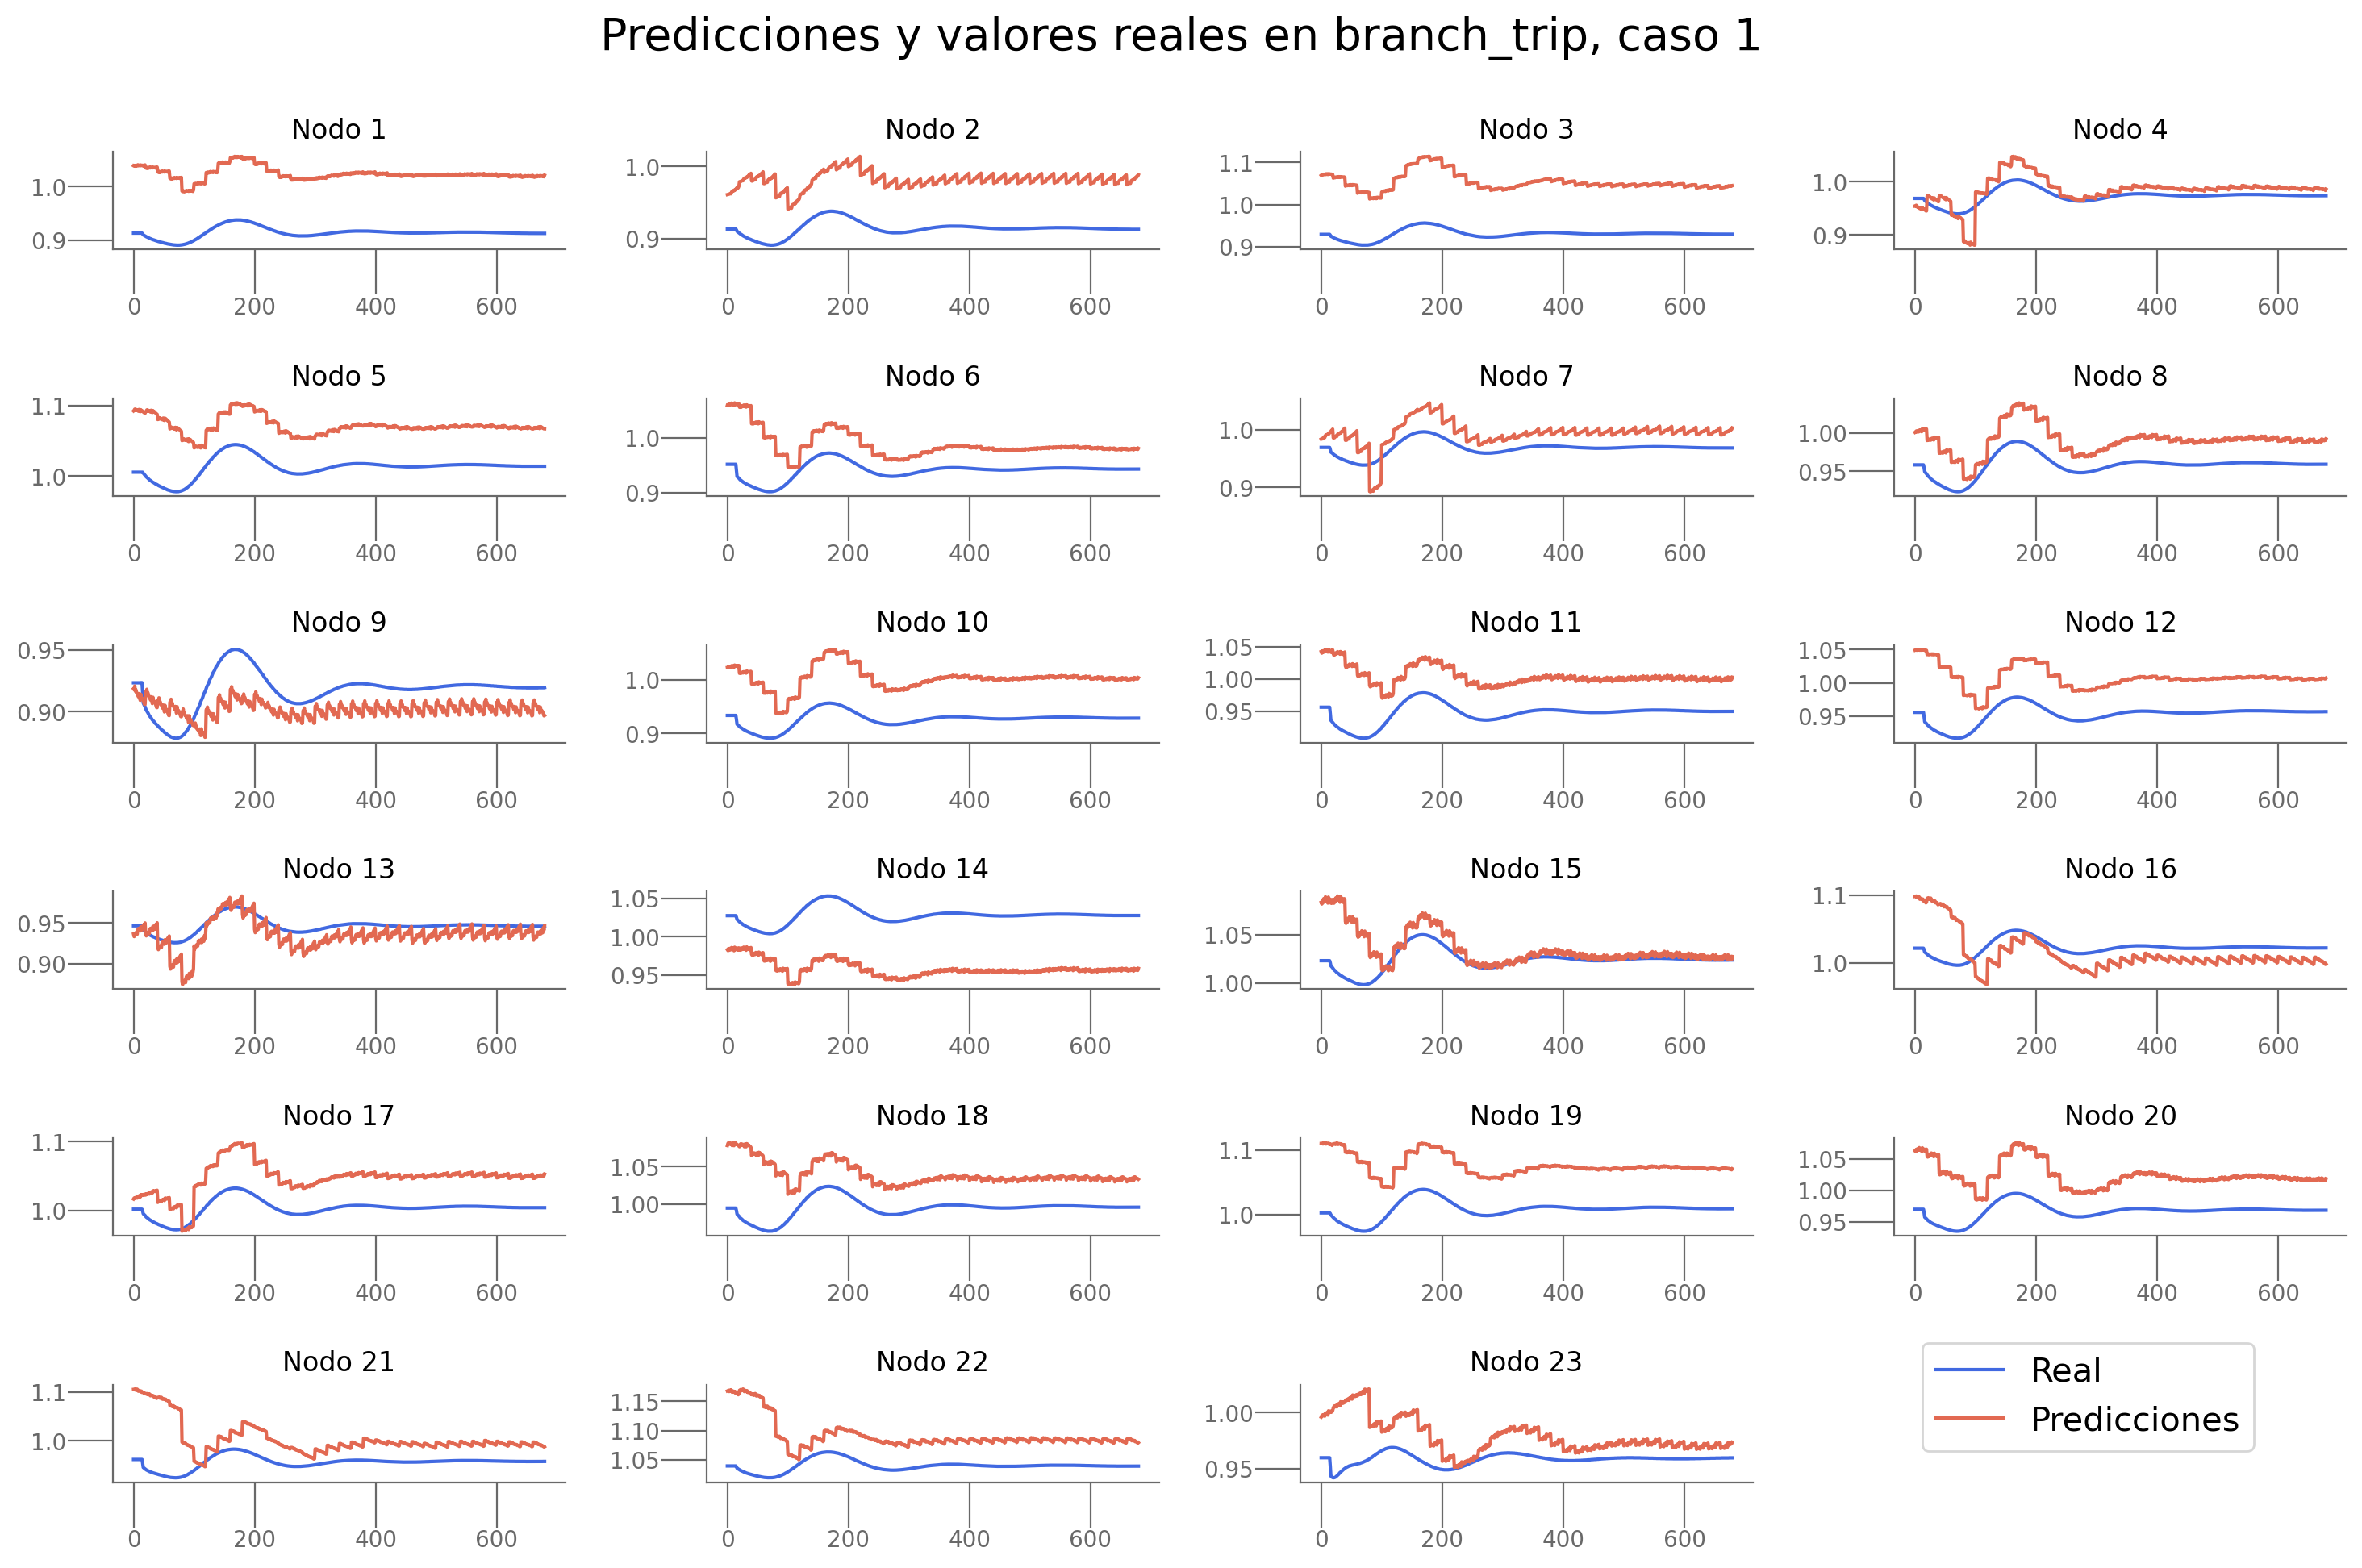

In [38]:
_,_,_, predictions_brt_ajuste,real_brt_ajuste = trainer_brt.test()
plot_predictions(predictions_brt_ajuste, real_brt_ajuste, n_target, 1, n_div_brt, problem_brt)

In [39]:
trainer_brt.save_model(path_save_experiment=path_save_experiment_brt, params = params_brt)


==================== GUARDANDO RESULTADOS ===================

         Modelo                                             Params  \
0          LSTM                                                NaN   
1  LSTM_NOBATCH                                                NaN   
2   DyGrEncoder              {'aggr': 'add', 'conv': 1, 'lstm': 2}   
3     MPNN_LSTM                {'hidden_size': 32, 'dropout': 0.8}   
4        MSTGCN  {'nb_block': 2, 'nb_chev_filter': 8, 'nb_time_...   
5     EvolveGCN                                                NaN   
6        ASTGCN                                                NaN   
7         DCRNN                                     {'hidden': 60}   
8         AGCRN             {'hidden': 10, 'K': 2, 'embedding': 3}   

                      Fichero_resultados_experimento  Loss_tst     R2_tst  \
0                                                NaN  0.003700   0.398922   
1                                                NaN  0.004787  -1.839737   
2  .